In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [2]:
train_data =pd.read_csv("../idiot/data/UNSW/UNSW_NB15_training-set.csv")
print(train_data.shape)
train_data.head()

(82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


# 1. Exploratory Data Analysis 

## 1.1 visualizing class label

Rectangle(xy=(-0.4, 0), width=0.8, height=37000, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=45332, angle=0)
[    0.   8233.2 16466.4 24699.6 32932.8 41166.  49399.2 57632.4 65865.6
 74098.8 82332. ]


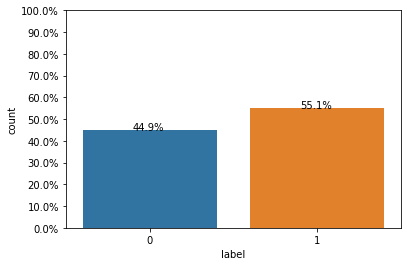

In [3]:
total = len(train_data)*1.
ax=sns.countplot(x="label", data=train_data)
for p in ax.patches:
    print(p)
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.3, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))
print(ax.yaxis.get_majorticklocs())
#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.savefig('class_label.png')
plt.show()

Above plot show that the dataset is not an imbalanced dataset

## 1.2 visualizing categorical data

In [4]:
cat_feature = train_data.select_dtypes(include=['category', object]).columns
cat_feature

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')

/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pail

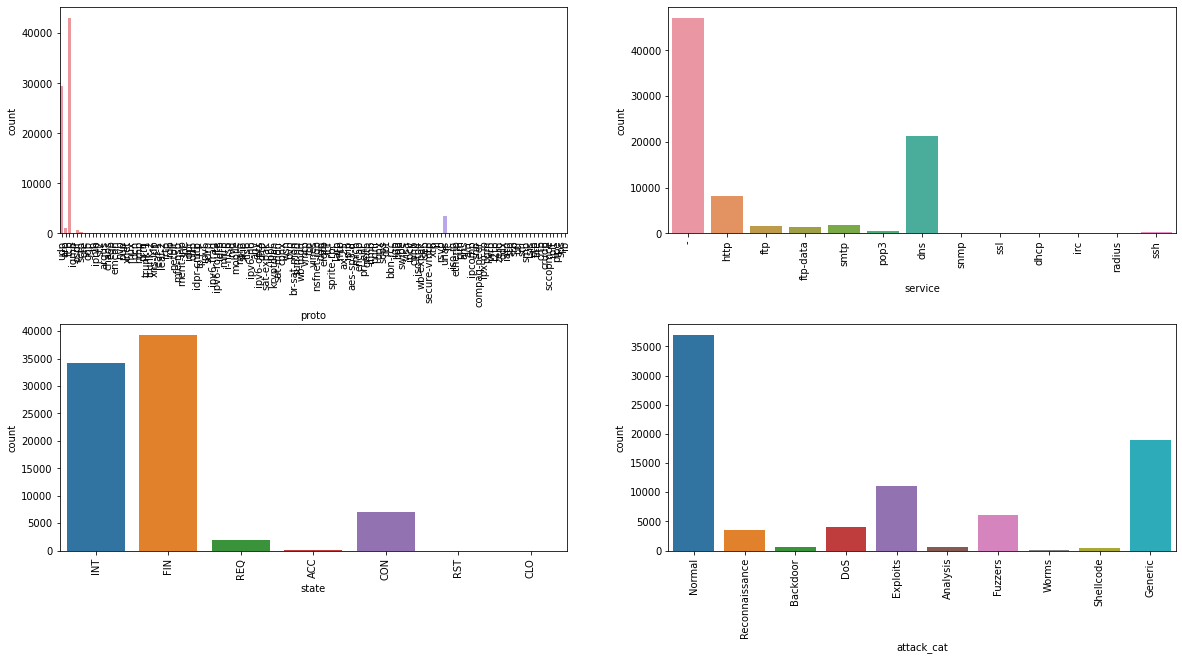

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plt.subplots_adjust(hspace = 0.4)
for col, subplot in zip(cat_feature, ax.flatten()):
    sns.countplot(train_data[col], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.savefig('cate_f.png')
plt.show()

From the categorical data we can see the data imbalance. Also “proto” category has more than 200 categories. Other columns have less than or equal 13 columns

## 3.2 visualizing numerical data and its distribution

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = train_data.drop(['id','label'], axis=1).select_dtypes(include=numerics).columns
num_features

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

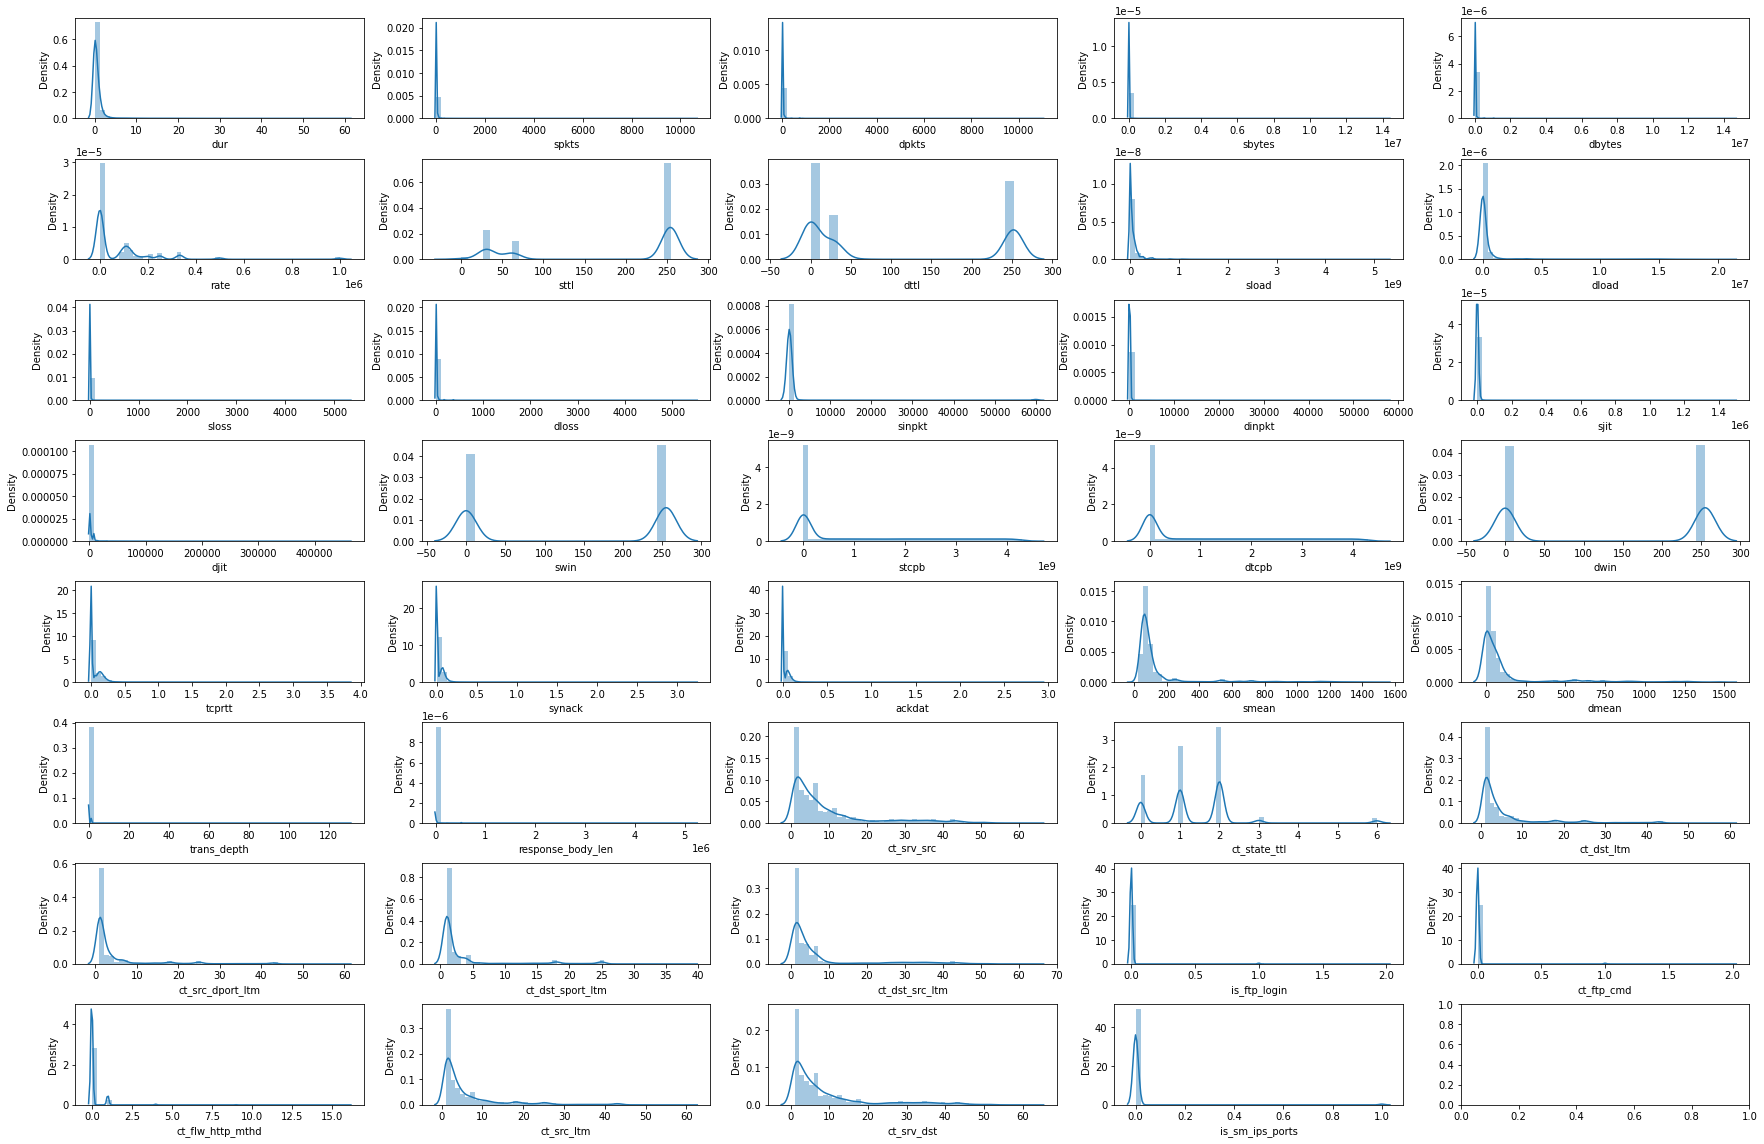

In [7]:
fig, ax = plt.subplots(8, 5, figsize=(30, 20))
plt.subplots_adjust(hspace = 0.4)
for col, splot in zip(num_features, ax.flatten()):
    sns.distplot(train_data[col], ax=splot)
plt.savefig('num_f.png')
plt.show()

from the distribution plot each feature have one value which is occurring more number of times than other values
As we can see from numerical data distribution there few features which are highly correlated with each other.

## 3.3 Correlation of data

In [8]:
df_corr = train_data.corr()

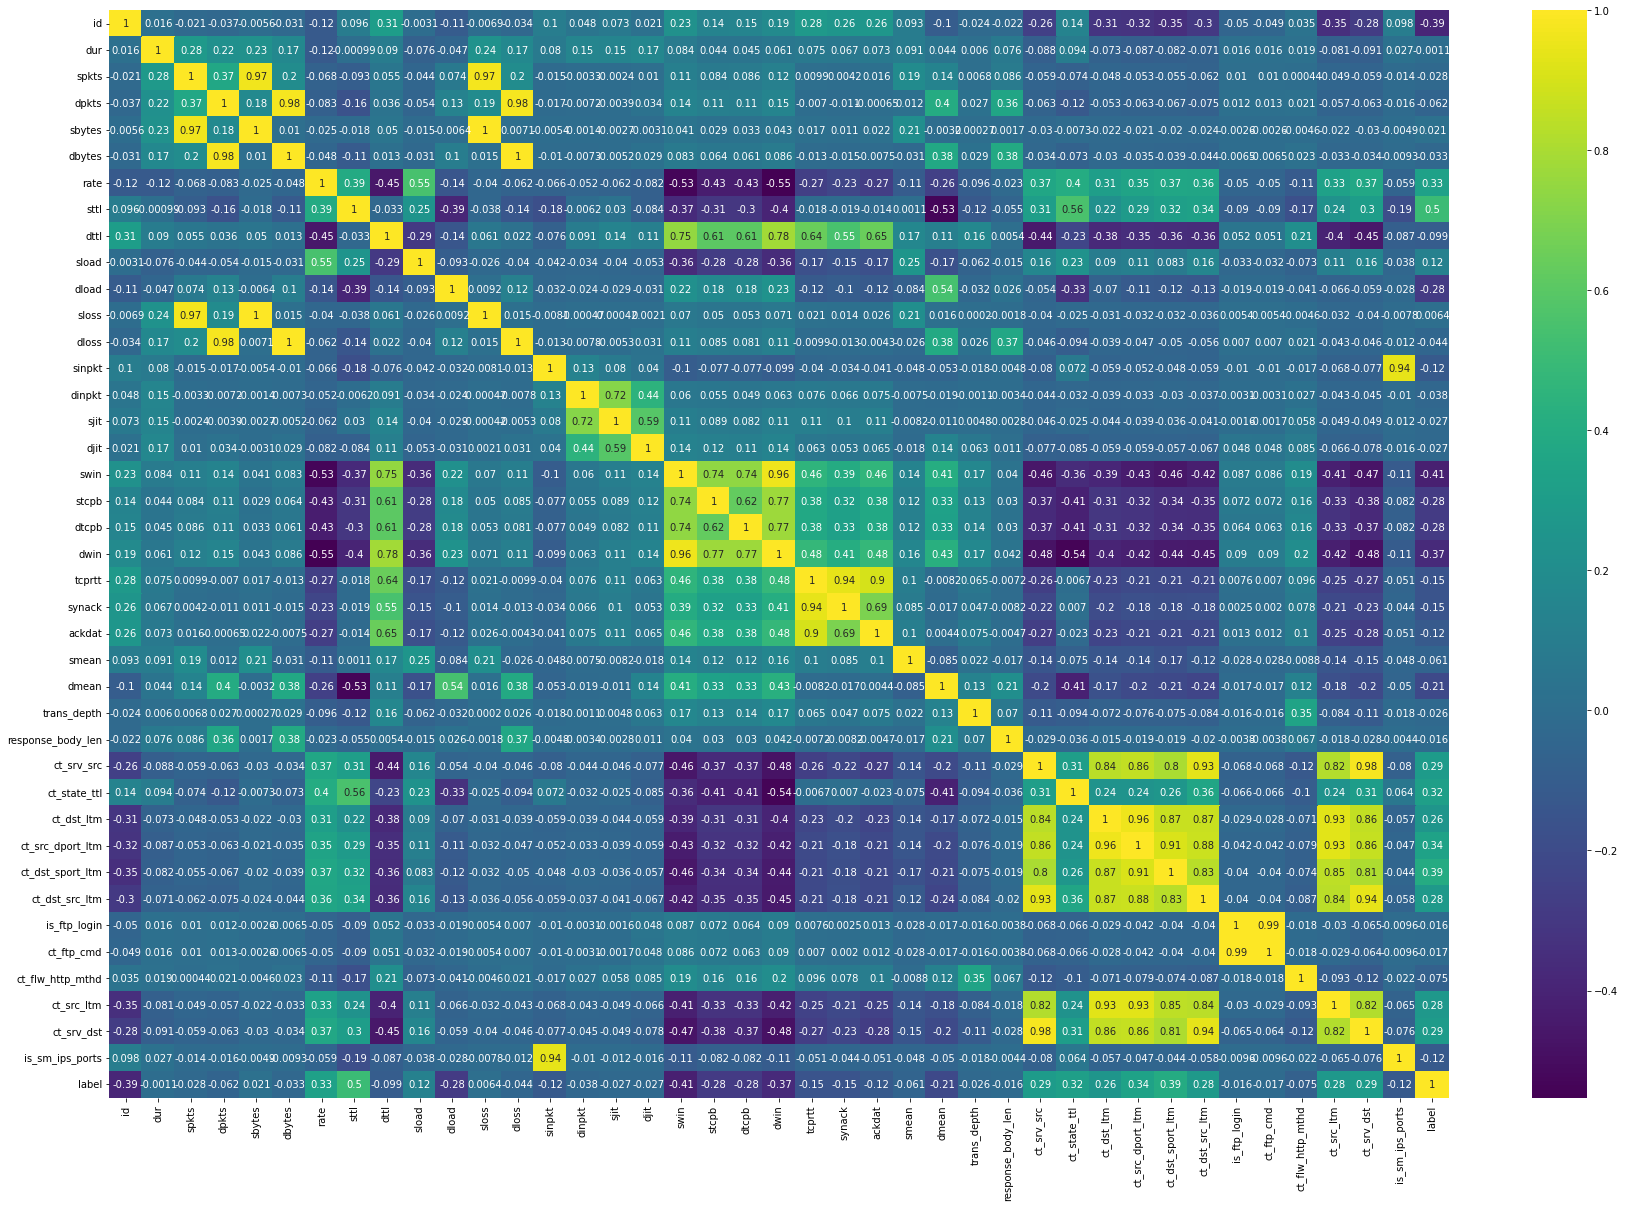

In [9]:
plt.figure(figsize=(30,20))
sns.heatmap(df_corr, annot=True, cmap=plt.cm.viridis)
plt.savefig('corr_mat.png')
plt.show()

In [10]:
high_corr_var=np.where(df_corr>0.95)

In [11]:
high_corr_var

(array([ 0,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  7,  8,
         9, 10, 11, 11, 11, 12, 12, 12, 13, 14, 15, 16, 17, 17, 18, 19, 20,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 28, 29, 30, 30, 31, 31, 32, 33,
        34, 34, 35, 35, 36, 37, 38, 38, 39, 40]),
 array([ 0,  1,  2,  4, 11,  3,  5, 12,  2,  4, 11,  3,  5, 12,  6,  7,  8,
         9, 10,  2,  4, 11,  3,  5, 12, 13, 14, 15, 16, 17, 20, 18, 19, 17,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 38, 29, 30, 31, 30, 31, 32, 33,
        34, 35, 34, 35, 36, 37, 28, 38, 39, 40]))

In [12]:
#ref: https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
high_corr_var=[(df_corr.columns[x],df_corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [13]:
high_corr_var

[('spkts', 'sbytes'),
 ('spkts', 'sloss'),
 ('dpkts', 'dbytes'),
 ('dpkts', 'dloss'),
 ('sbytes', 'sloss'),
 ('dbytes', 'dloss'),
 ('swin', 'dwin'),
 ('ct_srv_src', 'ct_srv_dst'),
 ('ct_dst_ltm', 'ct_src_dport_ltm'),
 ('is_ftp_login', 'ct_ftp_cmd')]

## 3.4 Feature Description

In [14]:
data_features =pd.read_csv("../idiot/data/UNSW/NUSW-NB15_features.csv", engine='python')
print(data_features.shape)

(49, 4)


In [15]:
data_features.head(49)

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


### 3.4.1 dur

In [16]:
data_features[6:7]

,No.,Name,Type,Description
6,7,dur,Float,Record total duration


/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

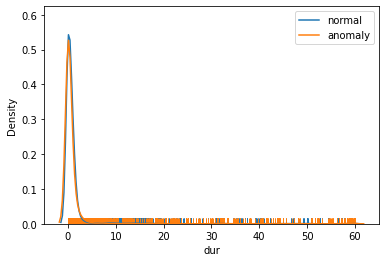

In [17]:
sns.distplot(train_data[train_data['label']==0]['dur'], label='normal', hist=False, rug=True)
sns.distplot(train_data[train_data['label']==1]['dur'], label='anomaly', hist=False, rug=True)
plt.legend()

dur is the total rocrd duration for both anomaly and normal.

### 3.4.2 sbytes - dbytes

In [18]:
data_features[7:9]

,No.,Name,Type,Description
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes


/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

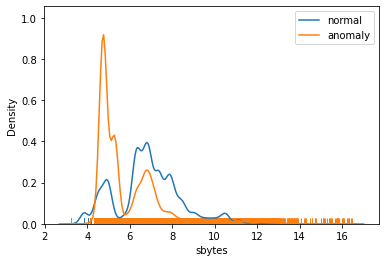

In [19]:
sns.distplot(train_data[train_data['label']==0]['sbytes'].apply(np.log1p), label='normal', hist=False, rug=True)
sns.distplot(train_data[train_data['label']==1]['sbytes'].apply(np.log1p), label='anomaly', hist=False, rug=True)
plt.legend()

- applied logarithm of x log(1+x) for some of the features to visualize properly 

### 3.4.3 sloss - dloss

In [20]:
data_features[11:13]

,No.,Name,Type,Description
11,12,sloss,Integer,Source packets retransmitted or dropped
12,13,dloss,Integer,Destination packets retransmitted or dropped


/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

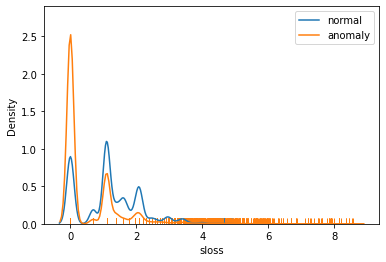

In [21]:
sns.distplot(train_data[train_data['label']==0]['sloss'].apply(np.log1p), label='normal', hist=False, rug=True)
sns.distplot(train_data[train_data['label']==1]['sloss'].apply(np.log1p), label='anomaly', hist=False, rug=True)
plt.legend()

- sloss and dloss have same disruption as we can see in overall numerical distribution plot.
-

### 3.4.4 spkts - dpkts

In [22]:
data_features[16:18]

,No.,Name,Type,Description
16,17,Spkts,integer,Source to destination packet count
17,18,Dpkts,integer,Destination to source packet count


/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

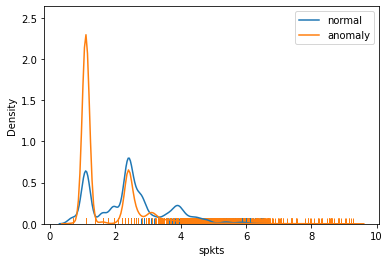

In [23]:
sns.distplot(train_data[train_data['label']==0]['spkts'].apply(np.log1p), label='normal', hist=False, rug=True)
sns.distplot(train_data[train_data['label']==1]['spkts'].apply(np.log1p), label='anomaly', hist=False, rug=True)
plt.legend()

- these sbytes and dbytes have same distribution. anomaly we can see it peaks to 0.8 and above. normal is below 0.4

In [24]:
print(train_data[['sbytes','sloss','spkts']].corr())
print(train_data[['dbytes','dloss','dpkts']].corr())

          sbytes     sloss     spkts
sbytes  1.000000  0.995027  0.965750
sloss   0.995027  1.000000  0.973644
spkts   0.965750  0.973644  1.000000
          dbytes     dloss     dpkts
dbytes  1.000000  0.997109  0.976419
dloss   0.997109  1.000000  0.981506
dpkts   0.976419  0.981506  1.000000


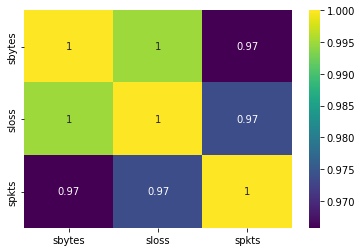

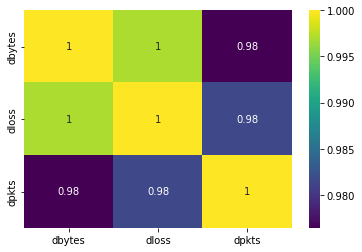

In [25]:
sns.heatmap(train_data[['sbytes','sloss','spkts']].corr(), annot=True, cmap=plt.cm.viridis)
plt.show()
sns.heatmap(train_data[['dbytes','dloss','dpkts']].corr(), annot=True, cmap=plt.cm.viridis)
plt.show()

- so we can drop column sbyte and dbytes from above representation.
- From this visualization we can see that both have high correlation and same distribution with other columns

### 3.4.5 sttl - dttl

In [26]:
data_features[9:11]

,No.,Name,Type,Description
9,10,sttl,Integer,Source to destination time to live value
10,11,dttl,Integer,Destination to source time to live value


/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

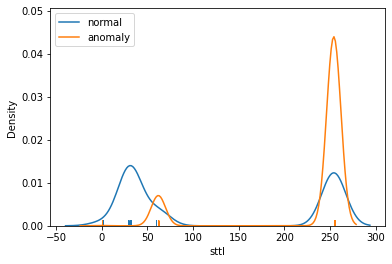

In [27]:
sns.distplot(train_data[train_data['label']==0]['sttl'], label='normal', hist=False, rug=True)
sns.distplot(train_data[train_data['label']==1]['sttl'], label='anomaly', hist=False, rug=True)
plt.legend()

- fewer amount of data have anomaly of higher rate. >0.2 are anomaly

/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

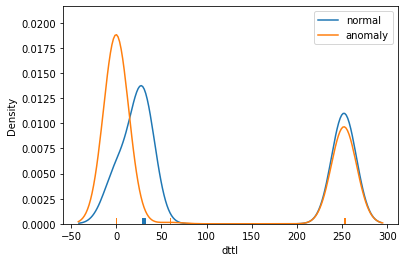

In [28]:
sns.distplot(train_data[train_data['label']==0]['dttl'], label='normal', hist=False, rug=True)
sns.distplot(train_data[train_data['label']==1]['dttl'], label='anomaly', hist=False, rug=True)
plt.legend()

- sttl and dttl have different distribution as we can see in overall numerical distribution plot. cant ignore column

### 3.4.6 swin - dwin

In [29]:
data_features[18:20]

,No.,Name,Type,Description
18,19,swin,integer,Source TCP window advertisement value
19,20,dwin,integer,Destination TCP window advertisement value


/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

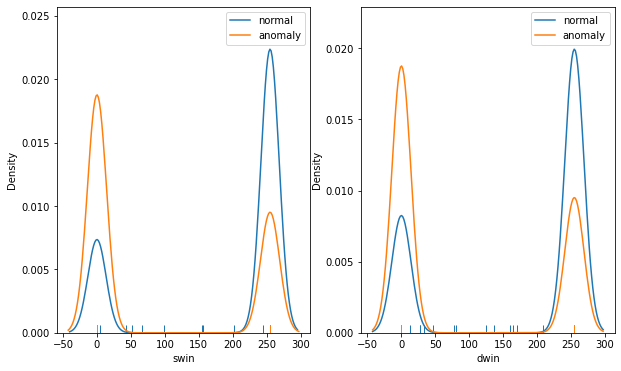

In [30]:
plt.figure(figsize=(10,6))
for i, col in enumerate(['swin', 'dwin']):
    plt.subplot(1,2,i+1)
    sns.distplot(train_data[train_data['label']==0][col], label='normal', hist=False, rug=True)
    sns.distplot(train_data[train_data['label']==1][col], label='anomaly', hist=False, rug=True)
    plt.legend()
plt.show()

- From above distribution plot we can distinguish between normal and anomaly.
- window rate of -50 to 50 less than 0.0075 is normal and 200 to 300 less than 0.0075 is anomaly

### 3.4.7 ct_dst_src_ltm, ct_srv_src, ct_srv_dst

In [31]:
data_features[40:42]

,No.,Name,Type,Description
40,41,ct_srv_src,integer,No. of connections that contain the same servi...
41,42,ct_srv_dst,integer,No. of connections that contain the same servi...


In [32]:
list(data_features[40:42]['Description'])

['No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26).',
 'No. of connections that contain the same service (14) and destination address (3) in 100 connections according to the last time (26).']

/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

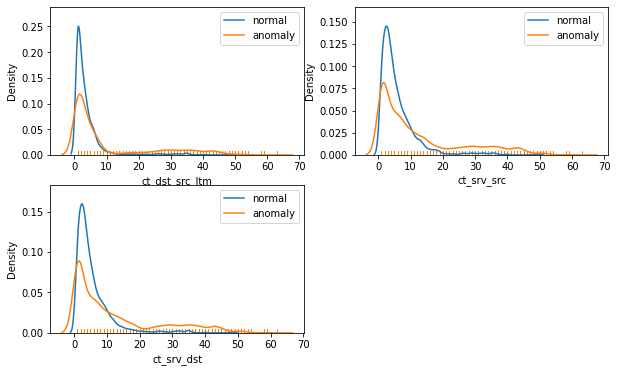

In [33]:
plt.figure(figsize=(10,6))
for i, col in enumerate(['ct_dst_src_ltm', 'ct_srv_src', 'ct_srv_dst']):
    plt.subplot(2,2,i+1)
    sns.distplot(train_data[train_data['label']==0][col], label='normal', hist=False, rug=True)
    sns.distplot(train_data[train_data['label']==1][col], label='anomaly', hist=False, rug=True)
    plt.legend()
plt.show()

- As we can see the distribution are similar

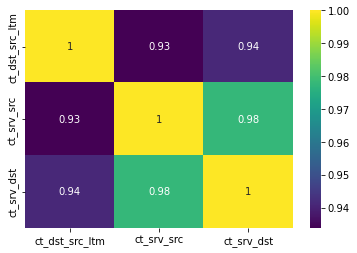

In [34]:
sns.heatmap(train_data[['ct_dst_src_ltm','ct_srv_src','ct_srv_dst']].corr(), annot=True, cmap=plt.cm.viridis)
plt.show()

- we can drop column ct_srv_dst
- From this visualization we can see that three columns are having high correlation and same distribution

#### 3.4.8 'is_ftp_login', 'ct_ftp_cmd'

In [35]:
data_features[38:40]

,No.,Name,Type,Description
38,39,is_ftp_login,Binary,If the ftp session is accessed by user and pas...
39,40,ct_ftp_cmd,integer,No of flows that has a command in ftp session.


In [36]:
list(data_features[38:40]['Description'])

['If the ftp session is accessed by user and password then 1 else 0. ',
 'No of flows that has a command in ftp session.']

/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/pail/minico

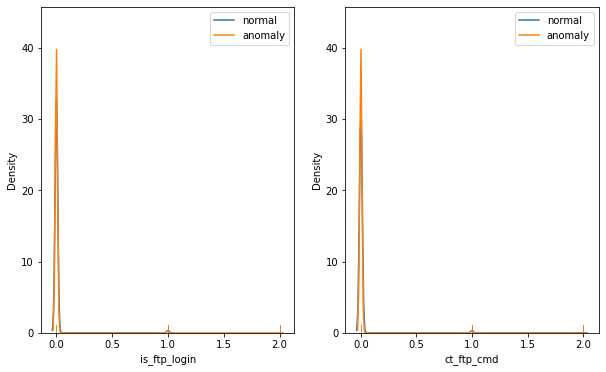

In [37]:
plt.figure(figsize=(10,6))
for i, col in enumerate(['is_ftp_login', 'ct_ftp_cmd']):
    plt.subplot(1,2,i+1)
    sns.distplot(train_data[train_data['label']==0][col], label='normal', hist=False, rug=True)
    sns.distplot(train_data[train_data['label']==1][col], label='anomaly', hist=False, rug=True)
    plt.legend()
plt.show()

- As we can see the distribution are same and both the columns related to ftp session

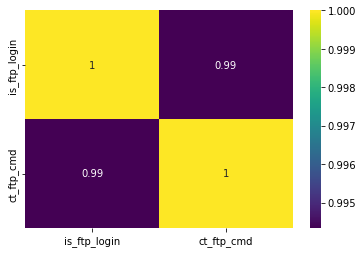

In [38]:
sns.heatmap(train_data[['is_ftp_login', 'ct_ftp_cmd']].corr(), annot=True, cmap=plt.cm.viridis)
plt.show()

- we can drop ct_ftp_cmd. 
- From this visualization we can see that both have high correlation and same distribution

## 3.5 EDA conclusion

#### we can drop the 5 columns mentioned from above analysis which are highly correlated
- sbyte and dbytes
- ct_srv_dst
- ct_ftp_cmd
- dwin

In [39]:
train_data.drop(['sbytes', 'dbytes','ct_srv_dst', 'ct_ftp_cmd', 'dwin'], axis=1, inplace=True)
train_data.shape

(82332, 40)

# 4. ARM - Feature selection

## 4.1 Association Rule Mining

### 4.1.1 Implementation Steps

|**Steps**|
-----------
<center>Set the minimum threshold values</center>
               <center>⇩</center>
<center>find all the subsets on the transaction using **apriori algorithm** having support of 30% or more.</center>
                <center>⇩</center>
<center>Find all the item sets or rule of these subsets from step 2 which are having a higher confidence than minimum confidence and maximum rule length of 2.</center>
                <center>⇩</center>
<center>get the columns from the rules using a set {} to eliminate the repeated columns.</center>
                <center>⇩</center>
<center>use these columns as feature for machine learning models.</center>

<hr>

## 4.2 Data preprocessing
- For better understanding of dataset 
- Identify the catogarical and numerical data and perform following encoding
    - Catogarical data (Label encoding)
    - Numerical data (StandardScalar)
- convert the data into numerical values so that it will input to machine learning models.

### 4.2.1 Catagorical Data

In [77]:
cat_feature = train_data.select_dtypes(include=['category', object]).columns
cat_feature

Index([], dtype='object')

In [78]:
from sklearn.preprocessing import LabelEncoder
train_data[cat_feature] = train_data[cat_feature].apply(LabelEncoder().fit_transform)
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,117,0,4,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,6,0
1,2,0.000008,117,0,4,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,6,0
2,3,0.000005,117,0,4,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,6,0
3,4,0.000006,117,0,4,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,6,0
4,5,0.000010,117,0,4,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,6,0


In [79]:
train_data.shape

(82332, 45)

### 4.2.2 Split data into equal parts

In [80]:
shuffled = train_data.sample(frac=1)

In [81]:
shuffled.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
54857,54858,0.000002,117,2,4,2,0,114,0,500000.001300,...,4,4,0,0,0,4,11,0,5,1
27794,27795,0.027949,111,0,3,62,62,3702,46036,4400.873054,...,1,1,0,0,0,11,10,0,6,0
71908,71909,0.000002,117,0,4,2,0,1064,0,500000.001300,...,1,30,0,0,0,7,30,0,6,0
46765,46766,0.823313,111,0,3,16,10,9500,886,30.365122,...,1,1,0,0,0,1,1,0,3,1
52965,52966,0.000002,118,0,4,2,0,200,0,500000.001300,...,2,2,0,0,0,6,9,0,2,1


In [82]:
data_42 = np.array_split(shuffled, 42)

In [83]:
len(data_42)

42

### 4.2.3 Find Mode of the attribute

- Lets compute the mode for each attribute. it is the most frequent values of the attribute.
- For each data set attribute frequent values are identified, and most frequent value is set to true and remaining are false. task will be performed in both numerical and categorical data like below. 
- It will accomplish the reliability of model output adopting to relevant attributes.

In [84]:
def create_arm_data(data):
    """ 
    Create the binary mode for the data
    Find the most frequent data point in an attribute
    """
    columns = data.columns
    for col in columns:
        # find mode of a attribute and make the model value 1 and others 0
        data[col] = np.where(data[col] == data[col].mode().values[0], 1, 0)
    return data

### 4.2.4 Create ARM rule based on Apriori Algorithm

In [85]:
def create_arm_rule(result):
    """ Create association rule for the given apriori data set """
    rules = association_rules(result, metric ="confidence", min_threshold = 1)
    # sort in order of confidence and lift
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
    # find the length of antecedents & consequents
    rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
    rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
    rules_list_sorted = []
    # iterate each row to add the both antecedents & consequents in single column set
    for x,y in rules.iterrows():
        rules_list_sorted.append(sorted(set(y.antecedents) | set(y.consequents)))
    rules['rules_set_sorted'] = rules_list_sorted
    rules["rules_len"] = rules["rules_set_sorted"].apply(lambda x: len(x))
    # sort the set and make it list
    rules['rules_sorted'] = rules.rules_set_sorted.apply(lambda x: ','.join(map(str, x)))
    return rules

## 4.2.5 Feature selction

- After the creation of rules in each set the antecedents, consequents are combined to generate the frequent itemsets on each dataset
- Each data set frequent items are again combined to make the final attributes for all dataset.
- Maximum rule length sets to two to eliminate the attribute which are not a frequent item. Least one item/attribute comes together with other attribute
- considering the items/attributes which are present more than 30% of total dataset/transaction.
- min_support = 0.3 that is 30% of items present in total transaction.

In [86]:
col_ruled_sets = []
i=1
for part in data_42:
    """ find columns of frequent transaction for all the dataset """
    print("===Started dataset "+ str(i) +"====")
    # drop id and label
    part = part.drop(['id', 'label'], axis=1)
    print(part.shape)
    # create the binary mode data
    part_binary = create_arm_data(part)
    # Use apriori algorithm to find the sunsets of frequent item
    result = apriori(part_binary, min_support=0.3, use_colnames=True, max_len=2)
    # Create the rule from subsets
    arm_rules = create_arm_rule(result)
    final_columns = arm_rules['rules_sorted'].unique()
    col_final = set()
    # add each frequent columns to set
    for row in final_columns:
        for col in row.split(","):
            col_final.add(col)
    print(col_final)
    col_ruled_sets.append(col_final)
    print("===Completed dataset "+ str(i) +"====")
    i+=1

===Started dataset 1====
(1961, 43)
{'trans_depth', 'dmean', 'ct_flw_http_mthd', 'synack', 'ackdat', 'response_body_len', 'dpkts', 'stcpb', 'djit', 'state', 'service', 'dtcpb', 'dbytes', 'ct_dst_sport_ltm', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'sloss', 'ct_ftp_cmd', 'is_sm_ips_ports', 'is_ftp_login', 'dinpkt', 'ct_state_ttl', 'dload', 'swin', 'sttl', 'spkts', 'tcprtt', 'sjit', 'ct_dst_ltm', 'dttl', 'proto'}
===Completed dataset 1====
===Started dataset 2====
(1961, 43)
{'trans_depth', 'dmean', 'ct_flw_http_mthd', 'synack', 'ackdat', 'response_body_len', 'dpkts', 'stcpb', 'djit', 'state', 'service', 'dtcpb', 'dbytes', 'ct_dst_sport_ltm', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'sloss', 'ct_ftp_cmd', 'is_sm_ips_ports', 'is_ftp_login', 'dinpkt', 'ct_state_ttl', 'dload', 'swin', 'sttl', 'spkts', 'tcprtt', 'sjit', 'ct_dst_ltm', 'dttl', 'proto'}
===Completed dataset 2====
===Started dataset 3====
(1961, 43)
{'trans_depth', 'dmean', 'ct_flw_http_mthd', 'synack

iterate over all the 42 data set to find all possible columns 

In [87]:
# iterate over all the 42 data set to find all possibel columns 
col_set = set()
for set_i in col_ruled_sets:
    for col in set_i:
        col_set.add(col)
print(len(col_set))

33


In [88]:
col_set

{'ackdat',
 'ct_dst_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_flw_http_mthd',
 'ct_ftp_cmd',
 'ct_src_dport_ltm',
 'ct_state_ttl',
 'dbytes',
 'dinpkt',
 'djit',
 'dload',
 'dloss',
 'dmean',
 'dpkts',
 'dtcpb',
 'dttl',
 'dwin',
 'is_ftp_login',
 'is_sm_ips_ports',
 'proto',
 'response_body_len',
 'service',
 'sjit',
 'sloss',
 'spkts',
 'state',
 'stcpb',
 'sttl',
 'swin',
 'synack',
 'tcprtt',
 'trans_depth'}

In [89]:
with open("feature_selected.txt", "w") as file:
    file.write(str(list(col_set)))

# 5. Machine Learning Models (Response Coding)

In [90]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

## Response Coding:

In [91]:
def create_prime_df(x_data, y):
    d = {'state' : pd.Series(x_data), 'class' : pd.Series(y)}
    return pd.DataFrame(d)

In [92]:
#generating response table
def get_response_df(s_u,p_df):
    data = []
    #iterate over unique values in state columns
    for u in tqdm(range(len(s_u))):
        class_0=0
        class_1=0
        #iterate over primary table
        for i in range(len(p_df)): 
            s =p_df.loc[i, "state"]
            c =p_df.loc[i, "class"]
            #if state = unique value and class = 0 add 1 to class_0
            #else add 1 to class_1
            #summing all the values in primary table
            if s == s_u[u] and c == 0:
                class_0 += 1
            elif s == s_u[u] and c == 1:
                class_1 += 1
        #append [state,class0,class1] and return as dataframe
        data.append([s_u[u],class_0,class_1])
    return pd.DataFrame(data, columns=['state', 'class_0', 'class_1'])

In [93]:
def encoded_data(input_df,res_df):
    data_e = []
    #iterate over response table
    #if state is present in input table the get the row
    #else 1/2 for class 0 and class 1
    for i in tqdm(range(len(input_df))):
        if input_df.loc[i, "state"] in res_df['state'].values:
            select_r = res_df.loc[res_df['state'] == input_df.loc[i, "state"]]
            c0 = select_r['class_0'].values[0]
            c1 = select_r['class_1'].values[0]
            #append the column in row as encoding rule
            data_e.append([int(c0)/int(c0+c1), int(c1)/int(c0+c1)])
        else:
            #append the column in row as encoding rule
            data_e.append([1/2, 1/2])
    return data_e

## 5.1 Reading Train and Test data

In [94]:
train_data = pd.read_csv("../idiot/data/UNSW/UNSW_NB15_training-set.csv")
print(train_data.shape)
train_data.head()

(82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [95]:
df_train = train_data[list(col_set)]
df_train.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,state,...,ct_state_ttl,dload,swin,sttl,spkts,tcprtt,sjit,ct_dst_ltm,dttl,proto
0,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,1,0,udp
1,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,1,0,udp
2,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,1,0,udp
3,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,2,0,udp
4,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,2,0,udp


In [96]:
cat_features = df_train.select_dtypes(include=['category', object]).columns
cat_features

Index(['state', 'service', 'proto'], dtype='object')

In [97]:
test_data = pd.read_csv("../idiot/data/UNSW/UNSW_NB15_testing-set.csv")
print(test_data.shape)
test_data.head()

(175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [98]:
df_test = test_data[list(col_set)]
df_test.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,state,...,ct_state_ttl,dload,swin,sttl,spkts,tcprtt,sjit,ct_dst_ltm,dttl,proto
0,0,43,0,0.000000,0.000000,0,4,621772692,11.830604,FIN,...,0,8495.365234,255,252,6,0.000000,30.177547,1,254,tcp
1,0,1106,0,0.000000,0.000000,0,38,1417884146,1387.778330,FIN,...,1,503571.312500,255,62,14,0.000000,61.426934,1,252,tcp
2,0,824,0,0.061458,0.050439,0,16,2116150707,11420.926230,FIN,...,1,60929.230470,255,62,8,0.111897,17179.586860,2,252,tcp
3,0,64,0,0.000000,0.000000,0,12,1107119177,4991.784669,FIN,...,1,3358.622070,255,62,12,0.000000,259.080172,2,252,tcp
4,0,45,0,0.071147,0.057234,0,6,2436137549,115.807000,FIN,...,1,3987.059814,255,254,10,0.128381,2415.837634,2,252,tcp


In [99]:
cat_feature = df_test.select_dtypes(include=['category', object]).columns
cat_feature

Index(['state', 'service', 'proto'], dtype='object')

### Proto

In [100]:
prime_train_s_df = create_prime_df(df_train['proto'].values, train_data['label'])
prime_test_s_df = create_prime_df(df_test['proto'].values, test_data['label'])
response_df = get_response_df(df_train['proto'].unique(), prime_train_s_df)
response_df.head()

100%|██████████| 131/131 [01:54<00:00,  1.15it/s]


,state,class_0,class_1
0,udp,8097,21321
1,arp,987,0
2,tcp,27848,15247
3,igmp,30,0
4,ospf,38,638


In [74]:
response_df.to_csv("../idiot/data/UNSW/proto_response.csv")

In [28]:
x_train_proto = pd.DataFrame(encoded_data(prime_train_s_df,response_df), columns=['state_0', 'state_1'])
x_test_proto = pd.DataFrame(encoded_data(prime_test_s_df,response_df), columns=['state_0', 'state_1'])

100%|██████████| 175341/175341 [01:11<00:00, 2462.21it/s]


### service

In [29]:
prime_train_ser_df = create_prime_df(df_train['service'].values, train_data['label'])
prime_test_ser_df = create_prime_df(df_test['service'].values, test_data['label'])
response_df_ser = get_response_df(df_train['service'].unique(), prime_train_ser_df)
response_df_ser.head()

100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


,state,class_0,class_1
0,-,27375,19778
1,http,4013,4274
2,ftp,758,794
3,ftp-data,949,447
4,smtp,635,1216


In [30]:
response_df_ser.to_csv("../idiot/data/UNSW/service_response.csv")

In [101]:
x_train_ser = pd.DataFrame(encoded_data(prime_train_ser_df,response_df_ser), columns=['state_0', 'state_1'])
x_test_ser = pd.DataFrame(encoded_data(prime_test_ser_df,response_df_ser), columns=['state_0', 'state_1'])

100%|██████████| 175341/175341 [01:10<00:00, 2478.67it/s]


### state

In [102]:
prime_train_st_df = create_prime_df(df_train['state'].values, train_data['label'])
prime_test_st_df = create_prime_df(df_test['state'].values, test_data['label'])
response_df_st = get_response_df(df_train['state'].unique(), prime_train_st_df)
response_df_st.head()

100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


,state,class_0,class_1
0,INT,4485,29678
1,FIN,24172,15167
2,REQ,1707,135
3,ACC,2,2
4,CON,6633,349


In [103]:
response_df_st.to_csv("../idiot/data/UNSW/state_response.csv")

In [104]:
x_train_state = pd.DataFrame(encoded_data(prime_train_st_df,response_df_st), columns=['state_0', 'state_1'])
x_test_state = pd.DataFrame(encoded_data(prime_test_st_df,response_df_st), columns=['state_0', 'state_1'])

100%|██████████| 175341/175341 [01:11<00:00, 2458.21it/s]


In [105]:
cat_df_train = pd.concat([x_train_proto, x_train_ser,x_train_state], axis=1, sort=False)
cat_df_train.head()

,state_0,state_1,state_0,state_1,state_0,state_1
0,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
1,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
2,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
3,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
4,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718


In [106]:
df_train = df_train.drop(cat_features, axis=1)
df_train.shape

(82332, 30)

In [107]:
df_train = df_train.join(cat_df_train)
df_train.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,dtcpb,...,tcprtt,sjit,ct_dst_ltm,dttl,state_0,state_1,state_0,state_1,state_0,state_1
0,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,1,0,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
1,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,1,0,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
2,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,1,0,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
3,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,2,0,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718
4,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,2,0,0.27524,0.72476,0.580557,0.419443,0.131282,0.868718


In [108]:
cat_df_test = pd.concat([x_test_proto, x_test_ser,x_test_state], axis=1, sort=False)
cat_df_test.head()

,state_0,state_1,state_0,state_1,state_0,state_1
0,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546
1,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546
2,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546
3,0.6462,0.3538,0.488402,0.511598,0.614454,0.385546
4,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546


In [109]:
df_test = df_test.drop(cat_feature, axis=1)
df_test.shape

(175341, 30)

In [110]:
df_test = df_test.join(cat_df_test)
df_test.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,dtcpb,...,tcprtt,sjit,ct_dst_ltm,dttl,state_0,state_1,state_0,state_1,state_0,state_1
0,0,43,0,0.000000,0.000000,0,4,621772692,11.830604,2202533631,...,0.000000,30.177547,1,254,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546
1,0,1106,0,0.000000,0.000000,0,38,1417884146,1387.778330,3077387971,...,0.000000,61.426934,1,252,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546
2,0,824,0,0.061458,0.050439,0,16,2116150707,11420.926230,2963114973,...,0.111897,17179.586860,2,252,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546
3,0,64,0,0.000000,0.000000,0,12,1107119177,4991.784669,1047442890,...,0.000000,259.080172,2,252,0.6462,0.3538,0.488402,0.511598,0.614454,0.385546
4,0,45,0,0.071147,0.057234,0,6,2436137549,115.807000,1977154190,...,0.128381,2415.837634,2,252,0.6462,0.3538,0.580557,0.419443,0.614454,0.385546


### 5.1.1 Standardize the data

In [41]:
x = df_train.values
x_test = df_test.values
std_scaler = preprocessing.MinMaxScaler()
std_scaler.fit(x)

MinMaxScaler()

In [42]:
import pickle

In [43]:
with open("model_scaler.pkl", 'wb') as file:
    pickle.dump(std_scaler, file)

In [44]:
# Load from pickle file
with open("model_scaler.pkl", 'rb') as file:
    minmax_scaler = pickle.load(file)

In [45]:
x_scaled = std_scaler.transform(x)
df_train = pd.DataFrame(x_scaled)
x_scaled_test = std_scaler.transform(x_test)
df_test = pd.DataFrame(x_scaled_test)

In [46]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.27524,0.72476,0.592168,0.407832,0.131282,0.868718
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.27524,0.72476,0.592168,0.407832,0.131282,0.868718
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.27524,0.72476,0.592168,0.407832,0.131282,0.868718
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017241,0.0,0.27524,0.72476,0.592168,0.407832,0.131282,0.868718
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017241,0.0,0.27524,0.72476,0.592168,0.407832,0.131282,0.868718


In [47]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,0.028667,0.0,0.000000,0.000000,0.0,0.000363,0.144768,0.000026,0.512828,...,0.000000,0.000020,0.000000,1.003953,0.6462,0.3538,0.592168,0.407832,0.614454,0.385546
1,0.0,0.737333,0.0,0.000000,0.000000,0.0,0.003449,0.330128,0.002996,0.716525,...,0.000000,0.000041,0.000000,0.996047,0.6462,0.3538,0.592168,0.407832,0.614454,0.385546
2,0.0,0.549333,0.0,0.019046,0.017222,0.0,0.001452,0.492707,0.024657,0.689918,...,0.029281,0.011578,0.017241,0.996047,0.6462,0.3538,0.592168,0.407832,0.614454,0.385546
3,0.0,0.042667,0.0,0.000000,0.000000,0.0,0.001089,0.257772,0.010777,0.243882,...,0.000000,0.000175,0.017241,0.996047,0.6462,0.3538,0.498170,0.501830,0.614454,0.385546
4,0.0,0.030000,0.0,0.022049,0.019542,0.0,0.000545,0.567210,0.000250,0.460351,...,0.033595,0.001628,0.017241,0.996047,0.6462,0.3538,0.592168,0.407832,0.614454,0.385546


In [48]:
y_train = train_data['label']
y_test = test_data['label']
print("train data shape", df_train.shape, y_train.shape)
print("test data shape", df_test.shape, y_test.shape)

train data shape (82332, 36) (82332,)
test data shape (175341, 36) (175341,)


## 5.2 Logistic Regression Model

In [111]:
prams={
    'alpha':[10 ** x for x in range(-4, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-4, 1)]
}
lr_cfl=GridSearchCV(SGDClassifier(penalty='l2', loss='log', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
lr_cfl.fit(df_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 2/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 2/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 3/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 4/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 1/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 3/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 2/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.744 total time=   0.3s
[CV 1/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.755 total time=   0.4s
[CV 5/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 4/5; 2/125] START alph

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 3/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 4/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 5/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.721 total time=   0.4s
[CV 2/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 5/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 4/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.729 total time=   0.5s
[CV 3/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.597 total time=   0.6s
[CV 2/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.629 total time=   0.6s
[CV 1/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.678 total time=   0.6s
[CV 2/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 5/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.615 total time=   0.6s
[CV 3/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 4/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 5/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.647 total time=   0.8s
[CV 4/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.591 total time=   0.8s
[CV 1/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 2/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.644 total time=   0.9s
[CV 3/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 1/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.755 total time=   1.0s
[CV 5/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.590 total time=   0.9s
[CV 4/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 5/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 2/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.615 total time=   1.0s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.729 total time=   1.1s
[CV 1/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 2/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.688 total time=   0.3s
[CV 3/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 1/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.756 total time=   0.4s
[CV 4/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.689 total time=   0.3s
[CV 5/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.591 total time=   0.4s[CV 5/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.721 total time=   0.3s

[CV 1/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 2/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.746 total time=   1.9s
[CV 3/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 4/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.590 total time=   2.0s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.757 total time=   0.4s[CV 4/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................

[CV 3/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.685 total time=   2.0s
[CV 5/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 5/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.579 total time=   1.9s
[CV 1/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 2/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 2/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.849 total time=   0.5s
[CV 3/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.659 total time=   2.4s
[CV 3/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.690 total time=   0.5s
[CV 4/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 5/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.721 total time=   0.5s
[CV 1/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 4/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.673 total time=   0.6s
[CV 2/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.597 total time=   0.7s
[CV 3/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.727 total time=   1.0s
[CV 4/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 2/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.824 total time=   1.0s
[CV 5/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.717 total time=   0.8s
[CV 5/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 1/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.599 total time=   1.0s
[CV 2/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.700 total time=   3.5s
[CV 3/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.603 total time=   3.7s[CV 2/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.807 total time=   3.9s

[CV 4/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 5/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 2/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.634 total time=   1.7s
[CV 1/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.758 total time=   4.0s
[CV 1/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 2/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 1/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.787 total time=   1.8s
[CV 3/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.613 total time=   1.7s
[CV 4/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 1/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.741 total time=   0.3s
[CV 5/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 5/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.593 total time=   4.1s[CV 2/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.673 total time=   0.3s

[CV 1/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................[CV 3/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.693 total time=   0.3s

[CV 2/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 3/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 4/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.729 total time=   1.7s
[CV 4/5; 12/125] START alpha=0.0001, eta0=0.01, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.717 total time=   0.4s
[CV 1/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 2/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.761 total time=   0.5s
[CV 2/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 3/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.680 total time=   0.5s
[CV 3/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 1/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.741 total time=   0.6s
[CV 4/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 5/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.721 total time=   0.5s
[CV 4/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.711 total time=   0.5s
[CV 5/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 1/5; 14/125] START alpha=0.0001, eta0=0.01, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.678 total time=   2.4s
[CV 2/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.657 total time=   0.9s
[CV 3/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 3/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.629 total time=   0.8s
[CV 4/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................[CV 5/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.677 total time=   0.7s

[CV 2/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.801 total time=   0.9s
[CV 5/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 1/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 4/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.729 total time=   0.9s
[CV 2/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.755 total time=   3.6s
[CV 3/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.821 total time=   4.0s
[CV 4/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 3/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.614 total time=   3.5s
[CV 5/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.696 total time=   1.5s
[CV 1/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.716 total time=   2.2s
[CV 1/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 2/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.807 total time=   2.2s
[CV 3/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 4/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.604 total time=   3.6s
[CV 4/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 1/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.761 total time=   0.3s
[CV 5/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.583 total time=   1.8s
[CV 5/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 2/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.828 total time=   0.3s
[CV 1/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 2/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.685 total time=   0.3s
[CV 3/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 4/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.659 total time=   0.3s
[CV 4/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 5/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.596 total time=   0.3s
[CV 5/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.713 total time=   0.5s
[CV 4/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.687 total time=   2.3s
[CV 1/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 2/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 5/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.583 total time=   4.3s[CV 1/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.755 total time=   0.6s

[CV 3/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.687 total time=   0.4s
[CV 3/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 4/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 5/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 4/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.729 total time=   0.5s
[CV 1/5; 19/125] START alpha=0.0001, eta0=0.1, max_

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.755 total time=   0.8s
[CV 3/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 2/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.840 total time=   0.9s
[CV 4/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.590 total time=   0.9s
[CV 5/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 3/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.682 total time=   0.9s
[CV 1/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.712 total time=   1.0s
[CV 2/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 2/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.697 total time=   3.5s[CV 1/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.712 total time=   3.6s

[CV 4/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 3/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.750 total time=   1.6s
[CV 5/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.825 total time=   2.0s
[CV 1/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 4/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.578 total time=   3.4s
[CV 2/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 3/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.657 total time=   4.1s
[CV 3/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.623 total time=   0.3s
[CV 4/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 5/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.719 total time=   3.6s
[CV 1/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.760 total time=   0.4s
[CV 4/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.667 total time=   1.7s
[CV 5/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 1/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 2/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 3/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.694 total time=   0.3s
[CV 3/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 4/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.635 total time=   0.3s
[CV 4/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10.........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.582 total time=   2.0s
[CV 5/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.671 total time=   0.3s
[CV 5/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 1/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 3/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.700 total time=   2.3s
[CV 2/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 1/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.639 total time=   0.5s
[CV 3/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.618 total time=   0.5s
[CV 4/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 2/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.824 total time=   0.7s
[CV 5/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 4/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.729 total time=   0.5s
[CV 1/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.700 total time=   0.5s
[CV 2/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.766 total time=   0.8s
[CV 3/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 3/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.692 total time=   0.7s
[CV 4/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 2/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.643 total time=   1.0s
[CV 5/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.701 total time=   0.8s
[CV 1/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 5/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.590 total time=   0.9s
[CV 2/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.719 total time=   3.6s
[CV 3/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 1/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.750 total time=   3.9s
[CV 4/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.722 total time=   1.7s
[CV 5/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 2/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.784 total time=   4.2s
[CV 1/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.719 total time=   3.6s
[CV 2/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 3/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.609 total time=   4.2s
[CV 3/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.701 total time=   1.8s
[CV 2/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.824 total time=   2.2s
[CV 4/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 1/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.468 total time=   0.4s
[CV 1/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 2/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.605 total time=   0.3s
[CV 2/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 3/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.599 total time=   0.3s
[CV 3/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.638 total time=   2.0s
[CV 3/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................[CV 4/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=1

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.717 total time=   0.6s
[CV 2/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 1/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.658 total time=   0.5s
[CV 2/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.820 total time=   0.5s
[CV 3/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 4/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 4/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.729 total time=   0.5s
[CV 5/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.721 total time=   0.5s
[CV 1/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 3/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.681 total time=   0.7s
[CV 2/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.758 total time=   0.8s
[CV 3/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.591 total time=   0.7s
[CV 5/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.597 total time=   0.7s
[CV 4/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 5/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 2/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.781 total time=   0.9s
[CV 1/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.694 total time=   1.0s
[CV 2/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.738 total time=   3.6s
[CV 3/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.649 total time=   1.7s
[CV 4/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.583 total time=   3.3s
[CV 5/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................
[CV 2/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.716 total time=   4.1s
[CV 1/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................
[CV 2/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.768 total time=   1.9s
[CV 2/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.605 total time=   3.9s
[CV 3/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................
[CV 4/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.579 total time=   3.9s
[CV 4/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................
[CV 1/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.758 total time=   0.3s
[CV 5/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.680 total time=   1.7s
[CV 5/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................
[CV 1/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 2/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.712 total time=   0.3s
[CV 2/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.729 total time=   1.8s
[CV 3/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 3/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.693 total time=   0.3s
[CV 4/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 3/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.697 total time=   2.2s
[CV 5/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.721 total time=   0.4s
[CV 1/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 4/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.608 total time=   0.6s
[CV 2/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.850 total time=   0.5s
[CV 2/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 3/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.690 total time=   0.4s
[CV 4/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 1/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.755 total time=   0.6s
[CV 5/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 5/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.721 total time=   0.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 4/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.680 total time=   0.6s
[CV 2/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.495 total time=   0.9s
[CV 3/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.667 total time=   0.8s
[CV 4/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.729 total time=   0.7s
[CV 3/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 4/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 5/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 5/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.721 total time=   0.8s
[CV 2/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.738 total time=   0.9s
[CV 1/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 2/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.644 total time=   3.6s
[CV 3/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.795 total time=   3.7s
[CV 4/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.780 total time=   1.7s
[CV 5/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 1/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.657 total time=   1.8s
[CV 1/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.468 total time=   0.3s
[CV 2/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................
[CV 3/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.596 total time=   4.1s
[CV 3/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.790 total time=   0.3s
[CV 4/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.729 total time=   1.9s
[CV 4/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................
[CV 5/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................
[CV 3/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.640 total time=   2.0s
[CV 1/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 3/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.674 total time=   0.3s
[CV 2/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 4/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.672 total time=   4.1s
[CV 3/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 5/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.609 total time=   2.2s[CV 5/5; 36/125] END alpha=0.001, eta0=0.01, max_ite

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 5/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.588 total time=   4.2s
[CV 2/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.653 total time=   0.5s
[CV 3/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 3/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.679 total time=   0.5s
[CV 2/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.831 total time=   0.6s
[CV 4/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 5/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.712 total time=   0.5s
[CV 1/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 5/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.721 total time=   0.7s
[CV 2/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.762 total time=   1.0s[CV 2/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.710 total time=   0.8s

[CV 3/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 4/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.590 total time=   0.8s
[CV 5/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 3/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.668 total time=   1.0s
[CV 4/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.600 total time=   0.9s
[CV 1/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 2/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.704 total time=   3.3s
[CV 3/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 1/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.722 total time=   4.0s
[CV 2/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.801 total time=   4.0s
[CV 5/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................[CV 4/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................



/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.719 total time=   3.3s
[CV 1/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.744 total time=   2.0s
[CV 2/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 1/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.512 total time=   0.3s
[CV 3/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 4/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.579 total time=   4.0s
[CV 4/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 2/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.817 total time=   2.0s
[CV 5/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 2/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.656 total time=   0.3s
[CV 1/5; 42/125] START alpha=0.001, eta0=0.1, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.729 total time=   1.9s
[CV 5/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.721 total time=   0.2s
[CV 2/5; 42/125] START alpha=0.001, eta0=0.1, max_iter=10.......................
[CV 3/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.694 total time=   0.4s
[CV 3/5; 42/125] START alpha=0.001, eta0=0.1, max_iter=10.......................
[CV 3/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.648 total time=   1.9s
[CV 4/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.629 total time=   0.3s
[CV 4/5; 42/125] START alpha=0.001, eta0=0.1, max_iter=10.......................
[CV 5/5; 42/125] START alpha=0.001, eta0=0.1, max_iter=10.......................
[CV 1/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.598 total time=   2.0s
[CV 2/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 1/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.760 total time=   0.6s
[CV 3/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 5/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.590 total time=   0.4s
[CV 2/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.749 total time=   0.5s
[CV 4/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 3/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.635 total time=   0.5s
[CV 5/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 1/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 4/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.613 total time=   0.6s
[CV 2/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50...

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.693 total time=   0.9s
[CV 2/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.701 total time=   0.7s
[CV 4/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 3/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.591 total time=   0.8s
[CV 5/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 3/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.684 total time=   1.0s
[CV 1/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.721 total time=   1.2s
[CV 2/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.667 total time=   3.4s
[CV 3/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 1/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.754 total time=   4.0s
[CV 4/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 2/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.640 total time=   1.7s
[CV 5/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 4/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.718 total time=   3.6s
[CV 2/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.797 total time=   4.2s[CV 4/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.591 total time=   1.5s



/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................
[CV 3/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................[CV 2/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................

[CV 5/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.588 total time=   3.8s
[CV 1/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.686 total time=   2.1s
[CV 4/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................
[CV 5/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.756 total time=   0.4s
[CV 1/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 5/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.666 total time=   0.3s[CV 2/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.782 total time=   0.4s

[CV 4/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.729 total time=   0.3s
[CV 2/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 3/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.687 total time=   0.4s
[CV 3/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 4/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 3/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.626 total time=   2.0s
[CV 5/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 1/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.....................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.745 total time=   0.5s
[CV 3/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 5/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.721 total time=   0.4s
[CV 4/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 4/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.729 total time=   0.5s
[CV 5/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 3/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.587 total time=   0.6s
[CV 1/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 2/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.775 total time=   0.7s
[CV 2/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.730 total time=   0.8s
[CV 3/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.691 total time=   0.7s
[CV 4/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 2/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.597 total time=   1.1s
[CV 5/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 5/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.590 total time=   0.8s
[CV 4/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.601 total time=   0.8s
[CV 1/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 2/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.643 total time=   3.8s
[CV 2/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.811 total time=   1.8s
[CV 1/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.754 total time=   4.1s
[CV 4/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 3/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 5/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 1/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.754 total time=   2.0s
[CV 1/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.623 total time=   1.9s
[CV 2/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 4/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.582 total time=   3.7s
[CV 5/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.588 total time=   3.7s
[CV 3/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 1/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.652 total time=   0.4s
[CV 5/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 4/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.729 total time=   1.8s
[CV 1/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 2/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.825 total time=   0.3s
[CV 2/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 5/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.694 total time=   1.9s
[CV 3/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.620 total time=   4.1s
[CV 4/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 4/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.653 total time=   0.4s
[CV 5/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 5/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.721 total time=   0.4s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.690 total time=   0.5s
[CV 1/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 2/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 2/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.774 total time=   0.5s
[CV 3/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.684 total time=   0.5s
[CV 4/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 4/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.729 total time=   0.5s
[CV 5/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 1/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.701 total time=   0.7s
[CV 1/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.595 total time=   0.5s
[CV 2/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.660 total time=   0.9s
[CV 3/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 1/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.755 total time=   1.0s
[CV 3/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.672 total time=   0.8s
[CV 4/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 4/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.729 total time=   0.7s
[CV 5/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 5/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.721 total time=   0.7s
[CV 1/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 2/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.674 total time=   3.8s
[CV 3/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 1/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.730 total time=   4.0s
[CV 4/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.750 total time=   1.7s
[CV 5/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 2/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.719 total time=   1.8s
[CV 1/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.652 total time=   0.2s
[CV 2/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 5/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.697 total time=   1.7s
[CV 3/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 2/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.808 total time=   0.2s
[CV 4/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 3/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.678 total time=   1.9s
[CV 5/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 4/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.716 total time=   1.9s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 4/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.579 total time=   4.0s
[CV 2/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 3/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.685 total time=   0.3s
[CV 3/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.657 total time=   4.0s
[CV 3/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 4/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 5/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.670 total time=   0.3s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 5/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.669 total time=   4.1s
[CV 4/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.717 total time=   0.4s
[CV 1/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 2/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.719 total time=   0.5s
[CV 3/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 2/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.760 total time=   0.5s
[CV 4/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.729 total time=   0.5s
[CV 4/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 5/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 3/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.689 total time=   0.6s
[CV 1/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 5/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.670 total time=   0.5s
[CV 2/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.811 total time=   0.7s
[CV 3/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.617 total time=   0.8s
[CV 4/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.727 total time=   0.7s
[CV 4/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 5/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 1/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.652 total time=   1.1s
[CV 1/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................
[CV 5/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.721 total time=   0.9s
[CV 2/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.806 total time=   3.8s
[CV 3/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................
[CV 1/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.733 total time=   3.9s
[CV 4/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.620 total time=   3.7s
[CV 5/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................
[CV 2/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.616 total time=   1.8s
[CV 1/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.636 total time=   0.2s
[CV 2/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................
[CV 1/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.467 total time=   2.1s
[CV 4/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.635 total time=   3.9s
[CV 4/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.633 total time=   1.6s
[CV 3/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.689 total time=   2.0s
[CV 2/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.658 total time=   0.2s
[CV 3/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................
[CV 5/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.628 total time=   1.8s
[CV 4/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................
[CV 5/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................
[CV 1/5; 62/125] START alpha=0.01, eta0=0.01, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.591 total time=   0.3s
[CV 4/5; 62/125] START alpha=0.01, eta0=0.01, max_iter=10.......................
[CV 5/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.721 total time=   0.3s
[CV 3/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.682 total time=   0.4s
[CV 5/5; 62/125] START alpha=0.01, eta0=0.01, max_iter=10.......................
[CV 1/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 5/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.658 total time=   4.4s
[CV 2/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.684 total time=   0.5s
[CV 3/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 1/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.649 total time=   0.6s
[CV 4/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 2/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.612 total time=   0.7s
[CV 5/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 4/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.660 total time=   0.5s
[CV 1/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.615 total time=   0.5s
[CV 2/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.740 total time=   0.9s
[CV 3/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 2/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.820 total time=   0.9s
[CV 4/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.589 total time=   0.8s
[CV 5/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 5/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.721 total time=   0.8s
[CV 1/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 4/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.591 total time=   0.9s
[CV 2/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.816 total time=   3.5s
[CV 3/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 1/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.742 total time=   3.8s
[CV 4/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.627 total time=   3.6s
[CV 5/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 4/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.627 total time=   3.7s
[CV 1/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 2/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.795 total time=   1.8s
[CV 2/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.756 total time=   0.3s
[CV 3/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 1/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.734 total time=   2.3s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 3/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.618 total time=   0.3s
[CV 4/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.729 total time=   1.9s[CV 5/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................

[CV 5/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.663 total time=   3.8s
[CV 1/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................
[CV 2/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................[CV 2/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.651 total time=   0.5s

[CV 3/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.606 total time=   2.1s
[CV 4/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................
[CV 4/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.591 total time=   0.4s
[CV 5/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.655 total time=   0.3s
[CV 5/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................
[CV 1/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.712 total time=   2.2s
[CV 2/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 1/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.653 total time=   0.5s
[CV 3/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.613 total time=   0.5s
[CV 4/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 2/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.625 total time=   0.7s
[CV 5/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 3/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.663 total time=   0.7s
[CV 1/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.625 total time=   0.7s
[CV 2/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 1/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.755 total time=   0.9s
[CV 3/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.729 total time=   0.7s
[CV 4/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 3/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.676 total time=   0.9s
[CV 5/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.601 total time=   0.8s[CV 5/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................

[CV 1/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 2/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.591 total time=   1.1s
[CV 2/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.722 total time=   3.8s
[CV 3/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 2/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.767 total time=   3.9s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 3/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.702 total time=   3.6s
[CV 5/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.760 total time=   1.8s
[CV 1/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 4/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.695 total time=   3.8s
[CV 2/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.719 total time=   3.6s
[CV 3/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 3/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.654 total time=   1.8s
[CV 2/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.760 total time=   0.3s
[CV 4/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 5/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 2/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.724 total time=   2.0s
[CV 1/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.756 total time=   0.5s
[CV 1/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 2/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 3/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.589 total time=   0.3s
[CV 3/5; 72/125] START alpha=0.01, eta0=1, max_iter=10....................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.646 total time=   0.3s
[CV 4/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 4/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.679 total time=   1.9s
[CV 5/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 5/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.709 total time=   0.4s
[CV 5/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.708 total time=   2.0s
[CV 1/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 2/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.620 total time=   0.5s
[CV 3/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 2/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.827 total time=   0.6s
[CV 3/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.693 total time=   0.5s
[CV 4/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 5/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.721 total time=   0.5s
[CV 1/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.729 total time=   0.8s
[CV 2/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 2/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.644 total time=   0.8s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 1/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.754 total time=   0.9s
[CV 4/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 3/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.651 total time=   0.8s
[CV 4/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.607 total time=   0.8s
[CV 5/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.721 total time=   0.8s
[CV 5/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 1/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 2/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.667 total time=   4.0s
[CV 1/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.745 total time=   4.0s
[CV 3/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 4/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 1/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.792 total time=   1.8s
[CV 5/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.614 total time=   3.9s
[CV 1/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 2/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.809 total time=   1.9s
[CV 2/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.729 total time=   1.8s
[CV 1/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.650 total time=   0.2s
[CV 4/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 3/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 2/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.848 total time=   0.2s
[CV 5/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 4/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.720 total time=   4.1s
[CV 1/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.698 total time=   2.1s
[CV 2/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................
[CV 5/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.631 total time=   2.0s
[CV 3/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................
[CV 4/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.591 total time=   0.3s
[CV 4/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.591 total time=   0.4s
[CV 5/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................
[CV 3/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.594 total time=   0.5s
[CV 1/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 5/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.709 total time=   4.5s
[CV 2/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.612 total time=   0.5s
[CV 3/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 1/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.720 total time=   0.6s
[CV 3/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.688 total time=   0.5s[CV 4/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................

[CV 5/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.729 total time=   0.7s
[CV 1/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 5/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.656 total time=   0.6s
[CV 2/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.591 total time=   0.7s
[CV 3/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 3/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.682 total time=   0.8s
[CV 4/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 1/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.728 total time=   1.1s
[CV 5/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 5/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.651 total time=   0.8s
[CV 2/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.647 total time=   1.0s
[CV 1/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................
[CV 2/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.645 total time=   3.8s
[CV 3/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................
[CV 2/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.765 total time=   3.8s
[CV 4/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.767 total time=   1.6s
[CV 5/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.804 total time=   1.9s
[CV 1/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.697 total time=   1.8s
[CV 2/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................
[CV 3/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.637 total time=   4.0s
[CV 3/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................
[CV 4/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.595 total time=   4.0s
[CV 4/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................
[CV 4/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.727 total time=   1.8s
[CV 1/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.750 total time=   0.4s
[CV 5/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................
[CV 5/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.706 total time=   4.0s
[CV 1/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 2/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.591 total time=   0.3s
[CV 4/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 5/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 2/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.670 total time=   0.5s
[CV 5/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.593 total time=   0.4s
[CV 1/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 2/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.832 total time=   0.5s
[CV 3/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 1/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.760 total time=   0.6s
[CV 4/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 3/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.691 total time=   0.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 4/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.626 total time=   0.6s
[CV 1/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.611 total time=   0.7s
[CV 2/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 1/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.762 total time=   0.8s
[CV 3/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 2/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.808 total time=   0.8s
[CV 4/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.702 total time=   0.7s
[CV 5/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 3/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.667 total time=   0.9s
[CV 1/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 4/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.696 total time=   1.0s
[CV 2/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.694 total time=   3.5s
[CV 3/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 2/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.812 total time=   4.0s
[CV 4/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 4/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.698 total time=   3.6s
[CV 5/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.756 total time=   4.1s
[CV 1/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.657 total time=   0.3s
[CV 2/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.624 total time=   1.7s
[CV 2/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.825 total time=   0.2s
[CV 3/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................
[CV 4/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................
[CV 5/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.588 total time=   3.7s
[CV 2/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.769 total time=   2.0s[CV 5/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................

[CV 1/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.767 total time=   2.2s
[CV 1/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 2/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.597 total time=   0.3s
[CV 3/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 4/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.729 total time=   2.0s
[CV 5/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.592 total time=   1.8s
[CV 4/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.591 total time=   0.3s
[CV 4/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 1/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 5/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 5/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.655 total time=   0.4s
[CV 2/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 2/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.645 total time=   0.5s
[CV 3/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.666 total time=   0.4s
[CV 4/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 1/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.646 total time=   0.7s
[CV 5/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 5/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.710 total time=   0.5s
[CV 1/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 4/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.729 total time=   0.6s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.799 total time=   0.8s
[CV 3/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 1/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.756 total time=   1.1s
[CV 4/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 3/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.615 total time=   0.9s
[CV 5/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 5/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.721 total time=   0.8s
[CV 1/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 4/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.591 total time=   0.9s
[CV 2/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.762 total time=   4.1s
[CV 3/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.579 total time=   3.6s
[CV 4/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 1/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.753 total time=   2.0s
[CV 5/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 3/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.694 total time=   3.8s
[CV 1/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................
[CV 2/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.813 total time=   4.3s
[CV 2/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.781 total time=   2.2s
[CV 3/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................
[CV 3/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.609 total time=   1.8s
[CV 4/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................
[CV 5/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.607 total time=   3.9s
[CV 4/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.697 total time=   1.8s
[CV 5/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................
[CV 1/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.756 total time=   0.3s
[CV 1/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 2/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.852 total time=   0.3s
[CV 2/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 3/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10..............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.641 total time=   0.4s
[CV 3/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.686 total time=   0.4s
[CV 4/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 5/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 5/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.696 total time=   0.4s
[CV 1/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.756 total time=   0.5s
[CV 2/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 2/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.845 total time=   0.5s
[CV 3/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 5/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.612 total time=   0.4s
[CV 4/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 3/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.694 total time=   0.7s[CV 5/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.729 total time=   2.5s

[CV 5/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 1/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.711 total time=   0.7s
[CV 2/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 1/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.733 total time=   0.7s
[CV 3/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.806 total time=   0.8s
[CV 3/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.603 total time=   0.8s
[CV 4/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 5/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 4/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.701 total time=   0.8s
[CV 1/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.618 total time=   0.9s
[CV 2/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.760 total time=   3.7s
[CV 3/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................
[CV 1/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.722 total time=   4.0s
[CV 4/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.758 total time=   1.9s
[CV 5/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................
[CV 3/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.663 total time=   1.7s
[CV 1/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 4/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.729 total time=   1.6s
[CV 2/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 5/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.620 total time=   1.7s
[CV 3/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.757 total time=   0.3s
[CV 4/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 2/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.820 total time=   0.3s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 3/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.690 total time=   0.3s
[CV 4/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.729 total time=   0.2s
[CV 2/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................[CV 4/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.582 total time=   3.9s

[CV 1/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 3/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.704 total time=   4.0s
[CV 4/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 5/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.718 total time=   0.3s[CV 3/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.677 total time=   4.3s

[CV 5/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 1/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 2/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.825 total time=   2.7s
[CV 2/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 1/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.747 total time=   0.5s
[CV 2/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.743 total time=   0.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 4/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 4/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.655 total time=   0.5s
[CV 3/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.634 total time=   0.7s
[CV 5/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 1/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.590 total time=   0.5s
[CV 2/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.753 total time=   0.9s
[CV 3/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 3/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.600 total time=   0.8s
[CV 4/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.717 total time=   0.9s
[CV 5/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 5/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.705 total time=   0.8s
[CV 1/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 2/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.811 total time=   1.3s
[CV 2/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.728 total time=   4.0s
[CV 3/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 3/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.649 total time=   3.6s
[CV 4/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.739 total time=   1.8s
[CV 5/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 2/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.808 total time=   4.3s
[CV 1/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................
[CV 1/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.755 total time=   2.0s
[CV 2/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.641 total time=   4.0s
[CV 3/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................
[CV 2/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.821 total time=   0.3s
[CV 1/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.762 total time=   0.4s
[CV 4/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................
[CV 5/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................[CV 5/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.719 total time=   3.8s

[CV 1/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.655 total time=   2.0s
[CV 2/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 3/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.594 total time=   0.3s
[CV 4/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.729 total time=   1.9s
[CV 3/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 4/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.721 total time=   0.3s
[CV 5/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 5/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.667 total time=   2.0s
[CV 1/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 4/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.591 total time=   0.5s
[CV 2/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.829 total time=   0.5s
[CV 4/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.729 total time=   0.5s
[CV 3/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 3/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.669 total time=   0.5s
[CV 1/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.750 total time=   0.7s
[CV 5/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 4/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 1/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 5/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.721 total time=   0.5s
[CV 2/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.708 total time=   0.8s
[CV 3/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 2/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.677 total time=   0.8s
[CV 4/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.718 total time=   0.8s
[CV 5/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 5/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.721 total time=   0.8s
[CV 1/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 3/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.693 total time=   1.0s
[CV 2/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.756 total time=   3.8s
[CV 3/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.764 total time=   1.8s
[CV 4/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 2/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.746 total time=   4.1s
[CV 5/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 2/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.842 total time=   1.8s
[CV 1/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.757 total time=   0.2s
[CV 2/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 4/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.718 total time=   1.7s
[CV 3/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.810 total time=   0.2s
[CV 5/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.710 total time=   1.7s
[CV 3/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.693 total time=   1.9s[CV 5/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................

[CV 4/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 1/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................
[CV 3/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.668 total time=   0.2s
[CV 3/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.618 total time=   4.3s
[CV 2/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................
[CV 3/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................
[CV 5/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.719 total time=   3.9s
[CV 4/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.697 t

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 5/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.591 total time=   0.5s
[CV 2/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.805 total time=   0.5s
[CV 3/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 5/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.688 total time=   0.4s
[CV 1/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.660 total time=   0.6s
[CV 4/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 3/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.686 total time=   0.6s
[CV 4/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.729 total time=   0.5s
[CV 5/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 1/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 2/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.758 total time=   0.8s
[CV 3/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 4/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.718 total time=   0.7s
[CV 4/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.844 total time=   0.9s
[CV 5/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 3/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.597 total time=   0.9s
[CV 5/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.645 total time=   0.9s
[CV 1/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 2/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.762 total time=   3.8s
[CV 3/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.843 total time=   3.9s
[CV 4/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.661 total time=   1.9s
[CV 5/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 2/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.790 total time=   2.0s
[CV 1/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.657 total time=   1.8s
[CV 2/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 1/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.759 total time=   0.3s
[CV 3/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 3/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.637 total time=   4.2s
[CV 4/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 5/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.590 total time=   1.7s
[CV 5/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.704 total time=   3.9s
[CV 1/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 5/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.579 total time=   3.9s
[CV 2/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.843 total time=   0.3s
[CV 2/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 3/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 4/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.639 total time=   2.0s
[CV 4/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.657 total time=   0.3s
[CV 3/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.595 total time=   0.4s
[CV 5/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 1/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 5/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.708 total time=   0.4s
[CV 2/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.748 total time=   0.5s
[CV 3/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 5/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.579 total time=   0.4s
[CV 3/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.693 total time=   0.5s
[CV 4/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 5/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 2/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.660 total time=   0.6s
[CV 1/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 4/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.720 total time=   0.7s
[CV 2/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.711 total time=   0.8s
[CV 3/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 1/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.695 total time=   1.0s
[CV 4/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.691 total time=   1.0s
[CV 4/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.729 total time=   0.8s
[CV 5/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 5/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.712 total time=   0.8s
[CV 1/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 2/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.845 total time=   3.9s
[CV 3/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 1/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.758 total time=   4.1s
[CV 4/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.680 total time=   3.7s
[CV 5/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 1/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.698 total time=   1.9s
[CV 1/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 2/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.671 total time=   1.9s
[CV 2/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 4/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.697 total time=   3.7s
[CV 3/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.759 total time=   0.3s
[CV 4/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 3/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.665 total time=   0.3s
[CV 2/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.657 total time=   0.4s
[CV 5/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 1/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.685 total time=   2.0s
[CV 2/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................
[CV 5/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.579 total time=   1.8s
[CV 4/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.639 total time=   2.0s
[CV 3/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................
[CV 4/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................
[CV 5/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.659 total time=   4.0s
[CV 5/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.729 total time=   0.4s
[CV 1/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 5/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.591 total time=   0.4s
[CV 2/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.761 total time=   0.6s
[CV 3/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.608 total time=   0.5s
[CV 3/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 2/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.656 total time=   0.6s
[CV 4/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 5/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 5/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.719 total time=   0.5s
[CV 4/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.624 total time=   0.6s
[CV 1/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 2/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.759 total time=   0.9s
[CV 3/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 2/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.848 total time=   0.9s
[CV 4/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 5/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.641 total time=   0.8s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 4/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.729 total time=   0.9s
[CV 1/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 3/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.689 total time=   1.0s
[CV 2/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.661 total time=   3.8s
[CV 3/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.674 total time=   3.5s
[CV 4/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 2/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.821 total time=   1.9s
[CV 5/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.629 total time=   3.7s
[CV 1/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................
[CV 1/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.759 total time=   2.3s
[CV 2/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................
[CV 5/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.590 total time=   3.6s
[CV 3/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.699 total time=   1.7s
[CV 4/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................
[CV 1/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.768 total time=   0.3s
[CV 5/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................
[CV 1/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.666 total time=   4.9s
[CV 1/5; 122/125] START alpha=1, eta0=1, max_iter=10............................
[CV 2/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.639 total time=   0.3s
[CV 2/5; 122/125] START alpha=1, eta0=1, max_iter=10............................
[CV 4/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.634 total time=   2.0s
[CV 3/5; 122/125] START alpha=1, eta0=1, max_iter=10............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.588 total time=   0.4s
[CV 4/5; 122/125] START alpha=1, eta0=1, max_iter=10............................
[CV 4/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.678 total time=   0.3s
[CV 5/5; 122/125] START alpha=1, eta0=1, max_iter=10............................
[CV 3/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.677 total time=   2.4s
[CV 1/5; 123/125] START alpha=1, eta0=1, max_iter=20............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.722 total time=   0.4s
[CV 2/5; 123/125] START alpha=1, eta0=1, max_iter=20............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.596 total time=   0.5s
[CV 3/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 4/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.591 total time=   0.5s
[CV 2/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.669 total time=   0.6s
[CV 4/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 5/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 5/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.590 total time=   0.5s
[CV 1/5; 124/125] START alpha=1, eta0=1, max_iter=50............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.758 total time=   0.9s
[CV 2/5; 124/125] START alpha=1, eta0=1, max_iter=50............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.758 total time=   0.8s
[CV 3/5; 124/125] START alpha=1, eta0=1, max_iter=50............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.829 total time=   1.0s
[CV 4/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 4/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.641 total time=   0.8s
[CV 5/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 3/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.630 total time=   0.9s
[CV 1/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.590 total time=   0.9s
[CV 2/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.840 total time=   3.8s
[CV 3/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 1/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.769 total time=   4.0s
[CV 4/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.674 total time=   1.7s[CV 3/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.693 total time=   3.6s

[CV 5/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.643 total time=   1.8s
[CV 2/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.819 total time=   2.1s
[CV 4/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.718 total time=   3.7s
[CV 5/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.579 total time=   3.7s
[CV 4/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.717 total time=   1.7s
[CV 5/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.710 total time=   1.7s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.759 total time=   2.5s
[CV 2/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.836 total time=   2.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.693 total time=   2.2s
[CV 4/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.718 total time=   2.2s
[CV 5/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.718 total time=   2.0s


GridSearchCV(estimator=SGDClassifier(loss='log', n_jobs=-1), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [112]:
results = pd.DataFrame.from_dict(lr_cfl.cv_results_)
results = results.sort_values(['rank_test_score'])
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta0,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
103,1.769705,0.093011,0.011637,0.002910,1,0.0001,50,"{'alpha': 1, 'eta0': 0.0001, 'max_iter': 50}",0.763891,0.841987,0.692700,0.717539,0.709766,0.745177,0.053841,1
124,2.278370,0.208541,0.004086,0.000277,1,1,100,"{'alpha': 1, 'eta0': 1, 'max_iter': 100}",0.758608,0.836157,0.693004,0.717539,0.718268,0.744715,0.050332,2
95,0.269681,0.034255,0.010301,0.001332,0.1,1,5,"{'alpha': 0.1, 'eta0': 1, 'max_iter': 5}",0.756543,0.820125,0.690453,0.729321,0.718268,0.742942,0.044026,3
101,0.521461,0.083935,0.011889,0.001504,1,0.0001,10,"{'alpha': 1, 'eta0': 0.0001, 'max_iter': 10}",0.750288,0.828870,0.668833,0.729321,0.721183,0.739699,0.052031,4
31,0.504068,0.065157,0.012136,0.002678,0.001,0.001,10,"{'alpha': 0.001, 'eta0': 0.001, 'max_iter': 10}",0.754964,0.850185,0.690089,0.679886,0.721122,0.739249,0.061357,5


In [113]:
print(lr_cfl.best_params_)

{'alpha': 1, 'eta0': 0.0001, 'max_iter': 50}


In [114]:
logisticR=SGDClassifier(alpha=lr_cfl.best_params_['alpha'],eta0=lr_cfl.best_params_['eta0'], penalty='l2', loss='log', n_jobs = -1, max_iter=lr_cfl.best_params_['max_iter'])
logisticR.fit(df_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(df_train, y_train)
predict_y_tr_lr = sig_clf.predict(df_train)
predict_y_te_lr = sig_clf.predict(df_test)
lr_f1 = f1_score(y_test, predict_y_te_lr)
print(lr_f1)

0.8099646398490576


In [115]:
cm_lr = confusion_matrix(y_test, predict_y_te_lr)

In [116]:
tn, fp, fn, tp = cm_lr.ravel()

In [117]:
fpr_lr = (fp/(fp+tn))*100
fnr_lr = (fn/(fn+tp))*100
far_lr = (fpr_lr+fnr_lr)/2
print("FAR:",far_lr)

FAR: 50.0


In [118]:
def plot_cm(cm):
    sns.heatmap(cm, annot=True, cmap=sns.light_palette("blue"), fmt="g")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

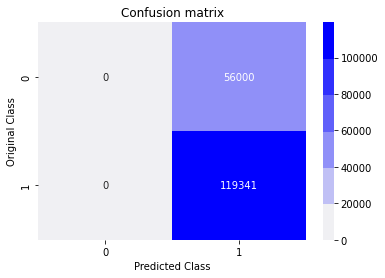

In [119]:
plot_cm(cm_lr)

In [120]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(fpr_tr, tpr_tr,fpr_te, tpr_te):
    '''
    plot the ROC curve for the FPR and TPR value
    '''
    plt.plot(fpr_te, tpr_te, 'k.-', color='orange', label='ROC_test AUC:%.3f'% auc(fpr_te, tpr_te))
    plt.plot(fpr_tr, tpr_tr, 'k.-', color='green', label='ROC_train AUC:%.3f'% auc(fpr_tr, tpr_tr))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC_LR:  0.5


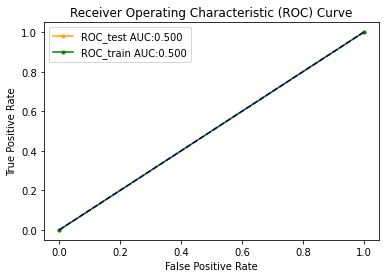

In [121]:
#finding the FPR and TPR for logistic reg model set
fpr_te_lr, tpr_te_lr, t_te_lr = roc_curve(y_test, predict_y_te_lr)
fpr_tr_lr, tpr_tr_lr, t_tr_lr = roc_curve(y_train, predict_y_tr_lr)
auc_te_lr = auc(fpr_te_lr, tpr_te_lr)
print("AUC_LR: ",auc_te_lr)
plot_roc_curve(fpr_tr_lr,tpr_tr_lr,fpr_te_lr, tpr_te_lr)

## 5.3 Support Vector Machine Model

In [122]:
prams={
    'alpha':[10 ** x for x in range(-4, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-4, 1)]
}
svm_cfl=GridSearchCV(SGDClassifier(penalty='l2', loss='hinge', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
svm_cfl.fit(df_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 2/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 3/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 4/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 1/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 2/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 3/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 4/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 5/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 1/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 2/5; 3/125] START alpha=0.0001, eta0=0.000

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.646 total time=   0.4s
[CV 5/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 4/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.687 total time=   0.4s
[CV 1/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 2/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.787 total time=   0.5s
[CV 2/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 1/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.745 total time=   0.5s
[CV 3/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 3/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.676 total time=   0.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 2/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.804 total time=   0.6s
[CV 5/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 4/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.729 total time=   0.7s
[CV 1/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.691 total time=   0.8s
[CV 2/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 2/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.806 total time=   0.9s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 1/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.761 total time=   1.0s
[CV 4/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 4/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.672 total time=   0.8s
[CV 3/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.633 total time=   0.8s
[CV 5/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 1/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 5/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.579 total time=   0.9s
[CV 2/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.646 total time=   0.2s
[CV 3/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 2/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.841 total time=   0.2s
[CV 4/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.644 total time=   0.2s
[CV 3/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.589 total time=   0.2s
[CV 5/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 1/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.721 total time=   0.3s
[CV 2/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 1/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.530 total time=   0.4s
[CV 3/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.757 total time=   1.9s
[CV 4/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 4/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.726 total time=   1.8s
[CV 5/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 5/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.679 total time=   1.9s
[CV 1/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 3/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.594 total time=   0.4s
[CV 2/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 2/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.636 total time=   0.5s
[CV 3/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 3/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.698 total time=   2.1s
[CV 4/5; 8/125] START alpha=0.0001, eta0=0.00

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.718 total time=   2.4s
[CV 5/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.673 total time=   0.5s
[CV 1/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 5/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 4/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.591 total time=   0.5s
[CV 2/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.632 total time=   0.7s
[CV 3/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 4/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.591 total time=   0.6s
[CV 4/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 3/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.696 total time=   0.8s
[CV 5/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.727 total time=   1.1s
[CV 1/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.721 total time=   1.0s
[CV 2/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.749 total time=   3.4s
[CV 3/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 2/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.808 total time=   3.2s
[CV 4/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.614 total time=   3.3s
[CV 5/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 2/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.673 total time=   1.6s
[CV 1/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 4/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.599 total time=   3.4s
[CV 2/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.758 total time=   0.2s
[CV 3/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 2/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.798 total time=   0.2s
[CV 4/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 5/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.719 total time=   3.6s
[CV 5/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 1/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.708 total time=   2.0s
[CV 1/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.676 total time=   1.7s
[CV 2/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 4/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.591 total time=   0.3s[CV 3/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.593 total time=   0.3s

[CV 3/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 4/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 5/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.721 total time=   0.3s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 5/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.712 total time=   1.8s
[CV 1/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 1/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.648 total time=   0.4s
[CV 2/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.767 total time=   0.5s
[CV 3/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 4/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.729 total time=   2.2s
[CV 4/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 3/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.689 total time=   0.5s
[CV 5/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.703 total time=   0.5s
[CV 1/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 4/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.729 total time=   0.7s
[CV 2/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.735 total time=   0.8s
[CV 3/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 2/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.611 total time=   0.8s
[CV 4/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.648 total time=   1.0s
[CV 5/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 4/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.729 total time=   0.9s
[CV 1/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 5/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.655 total time=   0.9s
[CV 2/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.677 total time=   3.4s
[CV 3/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 1/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.467 total time=   3.8s
[CV 4/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.708 total time=   3.4s
[CV 5/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 2/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.810 total time=   1.9s
[CV 1/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.729 total time=   1.7s
[CV 2/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 3/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.631 total time=   3.7s
[CV 3/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 1/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.740 total time=   0.2s
[CV 4/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.601 total time=   0.3s
[CV 5/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 1/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.696 total time=   2.4s
[CV 4/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.636 total time=   0.2s
[CV 2/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 1/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 3/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.673 total time=   2.2s
[CV 3/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.715 total time=   3.8s
[CV 4/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 3/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.598 total time=   0.5s
[CV 5/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.711 total time=   0.3s
[CV 5/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 1/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.591 total time=   2.1s
[CV 2/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 2/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.852 total time=   0.5s
[CV 3/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.701 total time=   0.6s
[CV 4/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 4/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.680 total time=   0.5s
[CV 5/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 3/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.623 total time=   0.6s
[CV 5/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.714 total time=   0.5s
[CV 1/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 2/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.746 total time=   0.8s
[CV 3/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 3/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.598 total time=   0.7s
[CV 4/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.812 total time=   0.9s
[CV 5/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.579 total time=   0.8s
[CV 1/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 4/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.590 total time=   1.0s
[CV 2/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.654 total time=   1.8s
[CV 3/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 2/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.813 total time=   4.2s
[CV 4/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 1/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.780 total time=   4.3s
[CV 5/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.649 total time=   1.7s
[CV 1/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 2/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.666 total time=   2.0s
[CV 2/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 4/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.718 total time=   3.6s
[CV 3/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 4/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.729 total time=   1.7s
[CV 4/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 3/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.700 total time=   3.8s
[CV 5/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 1/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.657 total time=   0.3s
[CV 1/5; 22/125] START alpha=0.0001, eta0=1, max_iter=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.729 total time=   0.3s
[CV 5/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.588 total time=   3.7s[CV 4/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................

[CV 5/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 5/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.662 total time=   0.3s
[CV 1/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.649 total time=   0.4s
[CV 2/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 4/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.729 total time=   0.4s
[CV 3/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 3/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.694 total time=   0.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 2/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.586 total time=   0.5s
[CV 5/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 5/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.703 total time=   2.4s
[CV 1/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 5/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.721 total time=   0.6s
[CV 2/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.619 total time=   0.9s
[CV 3/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 2/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.802 total time=   0.8s
[CV 4/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.710 total time=   0.7s
[CV 5/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 3/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.596 total time=   0.8s
[CV 1/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 4/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.729 total time=   0.9s
[CV 2/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.722 total time=   3.8s
[CV 3/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.725 total time=   1.9s
[CV 4/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 2/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.799 total time=   1.9s
[CV 5/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.688 total time=   1.7s
[CV 1/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 4/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.595 total time=   1.7s
[CV 2/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.624 total time=   0.2s
[CV 3/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................[CV 2/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.664 total time=   4.5s
[CV 1/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.743 total time=   0.3s

[CV 4/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.672 total time=   1.8s
[CV 5/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 1/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 3/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.598 total time=   3.7s
[CV 2/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.591 total time=   0.2s
[CV 3/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 3/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.689 total time=   0.3s
[CV 4/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 4/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.679 total time=   0.4s
[CV 5/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 5/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.719 total time=   4.0s
[CV 1/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.757 total time=   0.5s
[CV 2/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 2/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.789 total time=   0.5s
[CV 3/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................[CV 4/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.718 total time=   4.2s

[CV 4/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 4/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.729 total time=   0.4s
[CV 5/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.694 total time=   0.5s
[CV 1/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.724 total time=   0.6s
[CV 2/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.729 total time=   0.8s
[CV 5/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.700 total time=   0.7s
[CV 3/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 4/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 1/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.755 total time=   1.1s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.607 total time=   1.0s[CV 5/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................

[CV 1/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................
[CV 1/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.671 total time=   3.4s
[CV 2/5; 28/125] END alpha=0.001, eta0=0.0001, max_iter=20;, score=0.804 total time=   1.1s
[CV 2/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................
[CV 3/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.812 total time=   3.6s
[CV 4/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.707 total time=   1.9s
[CV 5/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................
[CV 3/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.639 total time=   3.7s
[CV 1/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.697 total time=   1.6s
[CV 2/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................
[CV 2/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.800 total time=   2.0s
[CV 3/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................
[CV 1/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.732 total time=   0.2s
[CV 4/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.596 total time=   0.2s
[CV 5/5; 31/125] START alpha=0.001, eta0=0.001, max_iter=5......................
[CV 2/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.613 total time=   0.3s
[CV 1/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 4/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.590 total time=   1.9s
[CV 2/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 4/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.594 total time=   0.3s
[CV 3/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 5/5; 29/125] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.684 total time=   1.8s
[CV 4/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.579 total time=   4.1s
[CV 5/5; 32/125] START alpha=0.001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.722 total time=   0.5s
[CV 1/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 1/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.638 total time=   0.5s
[CV 2/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 5/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.719 total time=   4.3s
[CV 3/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 4/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.696 total time=   0.5s
[CV 4/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.732 total time=   0.6s
[CV 5/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 5/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.590 total time=   0.6s
[CV 1/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 3/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.694 total time=   0.7s
[CV 2/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.756 total time=   0.8s
[CV 3/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 2/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.778 total time=   0.9s
[CV 4/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 3/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.685 total time=   0.9s
[CV 5/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 4/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.729 total time=   0.9s
[CV 1/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 5/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.579 total time=   0.9s
[CV 2/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.701 total time=   3.4s
[CV 3/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.794 total time=   3.6s
[CV 4/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.718 total time=   3.3s
[CV 4/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 5/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 1/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.718 total time=   3.8s
[CV 1/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.755 total time=   0.2s
[CV 2/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.669 total time=   1.8s
[CV 2/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.616 total time=   0.2s
[CV 3/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................
[CV 4/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.752 total time=   2.0s
[CV 3/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.590 total time=   0.2s
[CV 5/5; 36/125] START alpha=0.001, eta0=0.01, max_iter=5.......................
[CV 1/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 4/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.591 total time=   0.3s
[CV 2/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.590 total time=   0.2s
[CV 4/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.729 total time=   1.7s
[CV 3/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 4/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 3/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.676 total time=   1.9s
[CV 5/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 5/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.627 total time=   3.8s
[CV 1/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 1/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.755 total time=   0.4s
[CV 2/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.842 total time=   0.6s
[CV 3/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 5/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.655 total time=   2.1s
[CV 4/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 3/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.656 total time=   0.5s
[CV 5/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 4/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.591 total time=   0.5s
[CV 1/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 5/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.719 total time=   0.5s
[CV 2/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.812 total time=   0.7s
[CV 3/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 1/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.755 total time=   0.8s
[CV 4/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.591 total time=   0.7s
[CV 5/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.723 total time=   0.8s
[CV 1/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 3/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.683 total time=   1.1s
[CV 2/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.791 total time=   3.3s
[CV 3/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 1/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.746 total time=   3.6s
[CV 4/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.626 total time=   3.5s
[CV 5/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.674 total time=   1.6s
[CV 1/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.746 total time=   1.9s
[CV 1/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 2/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 4/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.672 total time=   3.5s
[CV 3/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 5/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.690 total time=   3.7s
[CV 4/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 2/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.642 total time=   2.0s
[CV 5/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 2/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.731 total time=   0.2s[CV 1/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.688 total time=   0.3s
[CV 5/5; 42/125] START alpha=0.001, eta0=0.1, max_iter=10.......................
[CV 5/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.584 total time=   1.8s
[CV 1/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 5/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.721 total time=   0.4s
[CV 2/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.756 total time=   0.4s
[CV 3/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 4/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.700 total time=   0.4s
[CV 4/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 2/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.758 total time=   0.6s
[CV 5/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 3/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.660 total time=   0.6s
[CV 1/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.676 total time=   0.5s
[CV 2/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.621 total time=   0.7s
[CV 3/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.659 total time=   0.7s
[CV 4/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 2/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.684 total time=   1.0s
[CV 5/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 4/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.729 total time=   0.8s
[CV 1/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.593 total time=   1.1s
[CV 2/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.677 total time=   3.1s
[CV 3/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 1/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.750 total time=   3.7s
[CV 4/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 2/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.676 total time=   1.7s
[CV 5/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.730 total time=   1.9s
[CV 2/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.717 total time=   3.7s
[CV 1/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................[CV 2/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................

[CV 3/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.701 total time=   1.6s
[CV 3/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.669 total time=   0.2s
[CV 2/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.671 total time=   0.2s
[CV 4/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................[CV 5/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................

[CV 4/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.729 total time=   1.6s
[CV 1/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 5/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.701 total time=   1.6s
[CV 2/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 3/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.565 total time=   0.3s
[CV 3/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 5/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.721 total time=   0.3s
[CV 4/5; 47/125] START alpha=0.001, eta0=1, max_iter=10..................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.579 total time=   3.9s
[CV 1/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 1/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.731 total time=   0.4s
[CV 2/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 5/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.719 total time=   3.9s
[CV 3/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.656 total time=   0.5s
[CV 4/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 4/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.729 total time=   0.4s
[CV 5/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 3/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.663 total time=   0.5s
[CV 1/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 5/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.602 total time=   0.4s
[CV 2/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.656 total time=   0.8s
[CV 3/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 2/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.622 total time=   0.8s[CV 3/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.602 total time=   0.7s

[CV 4/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 5/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 5/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.637 total time=   0.7s
[CV 1/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.630 total time=   0.9s
[CV 2/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.675 total time=   3.3s
[CV 3/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.798 total time=   1.7s
[CV 4/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 1/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.739 total time=   1.7s
[CV 5/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.642 total time=   3.8s
[CV 1/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 5/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.713 total time=   1.6s
[CV 2/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.691 total time=   3.3s
[CV 3/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.701 total time=   3.5s
[CV 3/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 4/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 1/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.562 total time=   0.3s
[CV 5/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 3/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.564 total time=   1.8s
[CV 1/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 2/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.824 total time=   0.3s
[CV 2/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 3/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.690 total time=   0.3s
[CV 5/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;,

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.591 total time=   0.4s
[CV 1/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 1/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.757 total time=   0.4s
[CV 2/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.645 total time=   0.5s
[CV 3/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 4/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.729 total time=   0.4s
[CV 4/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 3/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.684 total time=   0.5s[CV 5/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.588 total time=   4.1s

[CV 5/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 1/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 5/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.723 total time=   0.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.807 total time=   0.7s
[CV 3/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.609 total time=   0.8s
[CV 4/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 1/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.724 total time=   1.0s
[CV 5/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 5/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.684 total time=   0.7s
[CV 1/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 1/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.722 total time=   3.1s
[CV 2/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 4/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.729 total time=   0.9s
[CV 3/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.682 total time=   3.1s
[CV 4/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.748 total time=   4.0s
[CV 1/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.725 total time=   1.7s
[CV 1/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 5/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 2/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.814 total time=   1.8s
[CV 2/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 4/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.713 total time=   3.3s
[CV 3/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.650 total time=   0.3s
[CV 4/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 3/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.632 total time=   1.7s
[CV 5/5; 56/125] START alpha=0.01, eta0=0.001, max_iter=5.......................
[CV 3/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.609 total time=   0.2s
[CV 1/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 2/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.625 total time=   0.3s
[CV 2/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.717 total time=   0.3s
[CV 3/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 5/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.722 total time=   0.3s
[CV 4/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 5/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.695 total time=   3.8s
[CV 5/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 4/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.729 total time=   1.8s
[CV 1/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.655 total time=   0.4s
[CV 2/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 2/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.592 total time=   0.4s
[CV 3/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 5/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.710 total time=   1.9s
[CV 4/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.575 total time=   0.5s
[CV 5/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.590 total time=   0.4s
[CV 5/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 1/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 4/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.704 total time=   0.6s
[CV 2/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.633 total time=   0.7s
[CV 3/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 2/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.821 total time=   0.7s
[CV 4/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 1/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.698 total time=   0.8s
[CV 5/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.590 total time=   0.9s
[CV 1/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 58/125] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.590 total time=   0.9s
[CV 2/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.730 total time=   3.5s
[CV 3/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................
[CV 3/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.703 total time=   3.5s
[CV 4/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................
[CV 2/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.723 total time=   3.6s
[CV 5/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=100.....................
[CV 4/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.718 total time=   3.3s
[CV 1/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................
[CV 1/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.743 total time=   1.7s
[CV 2/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.797 total time=   1.7s
[CV 3/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................
[CV 2/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.838 total time=   0.2s
[CV 4/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................
[CV 1/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.389 total time=   0.3s
[CV 5/5; 61/125] START alpha=0.01, eta0=0.01, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.640 total time=   0.2s
[CV 1/5; 62/125] START alpha=0.01, eta0=0.01, max_iter=10.......................
[CV 5/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.720 total time=   3.3s
[CV 2/5; 62/125] START alpha=0.01, eta0=0.01, max_iter=10.......................
[CV 4/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.591 total time=   0.2s
[CV 3/5; 62/125] START alpha=0.01, eta0=0.01, max_iter=10.......................
[CV 5/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.711 total time=   1.8s
[CV 4/5; 62/125] START alpha=0.01, eta0=0.01, max_iter=10.......................
[CV 5/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.722 total time=   0.3s
[CV 5/5; 62/125] START alpha=0.01, eta0=0.01, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.609 total time=   2.0s
[CV 1/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 4/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.625 total time=   2.2s
[CV 1/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.620 total time=   0.5s[CV 2/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................

[CV 3/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................[CV 2/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.746 total time=   0.5s

[CV 4/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 5/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.590 total time=   0.4s
[CV 5/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 3/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.578 total time=   0.6s
[CV 1/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50..

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.718 total time=   0.6s
[CV 2/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.682 total time=   0.9s
[CV 3/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 2/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.666 total time=   0.8s
[CV 4/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.721 total time=   0.7s
[CV 5/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 4/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 3/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.627 total time=   0.8s
[CV 1/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.721 total time=   0.8s
[CV 2/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.667 total time=   3.5s
[CV 3/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.709 total time=   1.9s
[CV 4/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 3/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.645 total time=   3.4s
[CV 5/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.782 total time=   2.1s
[CV 1/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 3/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.645 total time=   1.6s
[CV 2/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 2/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.814 total time=   4.0s
[CV 3/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 5/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.719 total time=   3.5s
[CV 4/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 4/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.709 total time=   1.7s
[CV 5/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 5/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.593 total time=   1.7s
[CV 1/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10.

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.590 total time=   0.4s
[CV 1/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 3/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.594 total time=   0.5s
[CV 2/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 4/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.702 total time=   0.4s
[CV 3/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 2/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.736 total time=   0.5s[CV 1/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.654 total time=   0.5s

[CV 4/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................[CV 3/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.685 total time=   0.5s[CV 5/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................


[CV 1/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50.............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.659 total time=   0.7s
[CV 3/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 2/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.797 total time=   0.7s
[CV 4/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.729 total time=   0.7s
[CV 5/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 3/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.588 total time=   0.9s
[CV 1/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 5/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.590 total time=   0.9s
[CV 2/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.767 total time=   3.4s
[CV 3/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 2/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.696 total time=   3.4s
[CV 4/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.776 total time=   1.8s
[CV 5/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 3/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.607 total time=   3.4s
[CV 1/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 3/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.684 total time=   1.5s
[CV 2/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 1/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.739 total time=   2.0s
[CV 3/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 1/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.756 total time=   0.3s
[CV 4/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.787 total time=   0.3s
[CV 5/5; 71/125] START alpha=0.01, eta0=1, max_iter=5...........................
[CV 3/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.615 total time=   0.3s
[CV 1/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 4/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.591 total time=   1.8s
[CV 2/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 4/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.686 total time=   3.4s
[CV 3/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.625 total time=   0.3s
[CV 4/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 5/5; 69/125] END alpha=0.01, eta0=0.1, max_iter=50;, score=0.615 total time=   1.8s
[CV 5/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 5/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.722 total time=   0.3s
[CV 1/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.754 total time=   0.4s
[CV 2/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 5/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.721 total time=   0.3s
[CV 3/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 4/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.704 total time=   0.4s
[CV 2/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.770 total time=   0.5s
[CV 3/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.686 total time=   0.4s
[CV 4/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 5/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 1/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.590 total time=   4.0s
[CV 2/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 1/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.761 total time=   0.7s
[CV 3/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.688 total time=   0.7s
[CV 4/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 2/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.813 total time=   0.8s
[CV 4/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.729 total time=   0.7s
[CV 5/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 1/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 3/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.693 total time=   0.8s
[CV 2/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.687 total time=   3.3s
[CV 3/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.730 total time=   3.7s
[CV 4/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 3/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.600 total time=   3.4s
[CV 5/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 1/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.657 total time=   1.8s
[CV 1/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 4/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.718 total time=   3.3s
[CV 2/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 2/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.753 total time=   1.5s
[CV 3/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.686 total time=   1.6s
[CV 4/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 1/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.658 total time=   0.3s
[CV 5/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 3/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.597 total time=   0.3s
[CV 1/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................
[CV 2/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.716 total time=   0.4s
[CV 2/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.729 total time=   0.2s
[CV 3/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................
[CV 5/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.721 total time=   0.2s
[CV 4/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.837 total time=   0.4s
[CV 5/5; 77/125] START alpha=0.1, eta0=0.0001, max_iter=10......................
[CV 1/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.755 total time=   0.4s
[CV 1/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 3/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.684 total time=   0.4s
[CV 2/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 5/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.711 total time=   3.7s
[CV 3/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 5/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.667 total time=   2.0s
[CV 4/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.591 total time=   2.1s
[CV 5/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 4/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.591 total time=   0.5s
[CV 1/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.665 total time=   0.4s
[CV 2/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.766 total time=   0.7s
[CV 3/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 1/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.656 total time=   0.8s
[CV 4/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 4/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.729 total time=   0.7s
[CV 5/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 5/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.709 total time=   0.7s
[CV 1/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................
[CV 3/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.694 total time=   0.9s
[CV 2/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.713 total time=   3.5s
[CV 3/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................
[CV 2/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.796 total time=   3.6s
[CV 4/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.755 total time=   1.6s
[CV 5/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................
[CV 2/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.826 total time=   1.6s
[CV 1/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.758 total time=   0.3s
[CV 3/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.703 total time=   3.7s
[CV 2/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................
[CV 3/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................
[CV 5/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.712 total time=   1.6s
[CV 4/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.719 total time=   3.4s
[CV 5/5; 81/125] START alpha=0.1, eta0=0.001, max_iter=5........................
[CV 4/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.699 total time=   1.8s
[CV 2/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.810 total time=   0.3s
[CV 1/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 2/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 3/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.686 total time=   0.4s
[CV 3/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 79/125] END alpha=0.1, eta0=0.0001, max_iter=50;, score=0.685 total time=   2.1s
[CV 4/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.591 total time=   0.4s
[CV 4/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 5/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 5/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.711 total time=   0.3s
[CV 1/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 2/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.802 total time=   0.4s
[CV 2/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 4/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.718 total time=   4.0s
[CV 3/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 1/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.758 total time=   0.5s
[CV 4/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.645 total time=   0.7s
[CV 2/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.827 total time=   0.8s[CV 3/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.694 total time=   0.8s

[CV 3/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 4/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 1/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.750 total time=   1.0s
[CV 5/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 4/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.622 total time=   0.9s
[CV 1/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.690 total time=   0.8s
[CV 2/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.755 total time=   3.5s
[CV 3/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.696 total time=   3.9s
[CV 4/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 1/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.684 total time=   1.6s
[CV 5/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 3/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.704 total time=   3.3s
[CV 1/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.660 total time=   1.7s
[CV 2/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................
[CV 5/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.656 total time=   3.3s
[CV 3/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................
[CV 1/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.774 total time=   0.2s
[CV 4/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................
[CV 4/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.722 total time=   3.5s
[CV 5/5; 86/125] START alpha=0.1, eta0=0.01, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.795 total time=   0.2s
[CV 1/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 3/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.590 total time=   0.2s
[CV 2/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 4/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.622 total time=   1.7s
[CV 3/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 4/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.729 total time=   0.3s
[CV 4/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 5/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.722 total time=   0.4s
[CV 5/5; 87/125] START alpha=0.1, eta0=0.01, max_iter=10........................
[CV 3/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.701 total time=   1.9s
[CV 1/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20.............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.580 total time=   1.9s
[CV 3/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 2/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.784 total time=   0.4s
[CV 4/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.679 total time=   0.5s
[CV 5/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 4/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.591 total time=   0.5s
[CV 1/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.721 total time=   0.6s
[CV 2/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 2/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.777 total time=   0.7s
[CV 3/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.688 total time=   0.8s
[CV 4/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 5/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.699 total time=   0.7s[CV 4/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.729 total time=   0.8s

[CV 5/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 1/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 1/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.670 total time=   1.1s
[CV 2/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.661 total time=   3.3s
[CV 2/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.812 total time=   3.6s
[CV 3/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 4/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 1/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.739 total time=   3.8s
[CV 5/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 1/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.660 total time=   1.7s
[CV 1/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.845 total time=   1.7s
[CV 2/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................
[CV 1/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.756 total time=   0.3s
[CV 3/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.727 total time=   0.2s
[CV 4/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................[CV 3/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.700 total time=   1.9s

[CV 5/5; 91/125] START alpha=0.1, eta0=0.1, max_iter=5..........................
[CV 4/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.591 total time=   1.7s
[CV 3/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.601 total time=   0.3s
[CV 1/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 2/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 5/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.695 total time=   1.7s
[CV 3/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.690 total time=   0.3s
[CV 4/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 5/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.697 total time=   0.5s
[CV 5/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 3/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.599 total time=   0.4s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 2/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.625 total time=   0.4s
[CV 2/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 1/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.650 total time=   0.5s
[CV 3/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 4/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.729 total time=   0.4s
[CV 4/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.665 total time=   4.2s
[CV 5/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 5/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.719 total time=   4.3s
[CV 1/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 5/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.676 total time=   0.4s
[CV 2/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.786 total time=   0.7s
[CV 3/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 4/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.591 total time=   0.7s
[CV 4/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 1/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.755 total time=   0.9s
[CV 5/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.684 total time=   0.9s
[CV 1/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................
[CV 5/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.618 total time=   0.7s
[CV 2/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................
[CV 2/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.823 total time=   3.1s
[CV 3/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.733 total time=   3.5s
[CV 4/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.756 total time=   1.7s
[CV 5/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................
[CV 4/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.718 total time=   3.4s
[CV 1/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 4/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.729 total time=   1.5s
[CV 2/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 3/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.703 total time=   3.5s
[CV 3/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 5/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.588 total time=   3.4s
[CV 4/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.750 total time=   2.1s
[CV 2/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.837 total time=   0.2s
[CV 5/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 1/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 1/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.757 total time=   0.3s
[CV 2/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 3/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.684 total time=   0.3s
[CV 3/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 4/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.591 total time=   0.3s
[CV 4/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.645 total time=   1.9s
[CV 3/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.692 total time=   2.1s
[CV 5/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 1/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 5/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.721 total time=   0.4s
[CV 2/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.677 total time=   0.4s
[CV 3/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 1/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.757 total time=   0.5s
[CV 4/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.729 total time=   0.4s
[CV 4/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 5/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 3/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.691 total time=   0.4s
[CV 1/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 5/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.712 total time=   0.4s
[CV 2/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.708 total time=   0.7s
[CV 3/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 2/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.687 total time=   0.7s
[CV 4/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.599 total time=   0.7s
[CV 5/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 4/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.665 total time=   0.8s
[CV 1/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.721 total time=   1.0s
[CV 2/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 1/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.755 total time=   3.3s
[CV 3/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.655 total time=   3.4s
[CV 4/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 2/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.818 total time=   3.7s
[CV 5/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.697 total time=   3.5s
[CV 1/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................
[CV 1/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.738 total time=   1.8s
[CV 2/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.660 total time=   0.2s
[CV 3/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................
[CV 2/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.801 total time=   0.2s
[CV 4/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................
[CV 2/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.674 total time=   2.1s
[CV 5/5; 101/125] START alpha=1, eta0=0.0001, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.622 total time=   0.2s
[CV 1/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 4/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.591 total time=   0.3s
[CV 2/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 5/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.719 total time=   1.8s
[CV 3/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 4/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.597 total time=   1.9s
[CV 4/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.710 total time=   0.3s
[CV 5/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 3/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.696 total time=   2.1s
[CV 1/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.627 total time=   3.7s
[CV 2/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 1/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.757 total time=   0.5s
[CV 3/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 4/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.596 total time=   0.4s
[CV 4/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 2/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.785 total time=   0.5s
[CV 5/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 5/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.611 total time=   0.4s
[CV 1/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.694 total time=   0.5s
[CV 2/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.835 total time=   0.7s
[CV 3/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 3/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.694 total time=   0.7s
[CV 4/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 5/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.677 total time=   0.7s
[CV 5/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 1/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.750 total time=   1.1s
[CV 1/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.718 total time=   1.0s
[CV 2/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 1/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.744 total time=   3.2s
[CV 3/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.688 total time=   3.4s
[CV 4/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 2/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.732 total time=   3.6s
[CV 5/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.614 total time=   3.2s
[CV 2/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.842 total time=   1.8s
[CV 1/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 2/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.816 total time=   0.2s
[CV 1/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.762 total time=   0.3s
[CV 3/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 4/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 3/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.694 total time=   1.6s
[CV 1/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.758 total time=   2.1s
[CV 5/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 1/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.710 total time=   1.6s
[CV 2/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................
[CV 4/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.655 total time=   1.7s
[CV 3/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................
[CV 5/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.710 total time=   0.3s
[CV 4/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................
[CV 3/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.664 total time=   0.3s
[CV 5/5; 107/125] START alpha=1, eta0=0.001, max_iter=10........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.729 total time=   0.4s
[CV 1/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 5/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.588 total time=   3.9s
[CV 2/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.667 total time=   0.5s
[CV 1/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.652 total time=   0.6s
[CV 3/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 4/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 3/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.694 total time=   0.4s
[CV 5/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 4/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.729 total time=   0.4s
[CV 1/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 5/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.631 total time=   0.4s
[CV 2/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.596 total time=   0.7s
[CV 3/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 2/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.649 total time=   0.9s
[CV 4/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................[CV 5/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.626 total time=   0.7s

[CV 5/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 1/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.662 total time=   1.1s
[CV 1/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.694 total time=   0.9s
[CV 2/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.679 total time=   3.4s
[CV 3/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.760 total time=   3.5s
[CV 4/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 3/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.694 total time=   3.4s
[CV 5/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 1/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.776 total time=   1.7s
[CV 1/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.842 total time=   1.7s
[CV 2/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 1/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.757 total time=   0.2s
[CV 3/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.677 total time=   3.3s
[CV 4/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 2/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.806 total time=   0.2s
[CV 5/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 3/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.667 total time=   0.3s
[CV 1/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.715 total time=   0.2s
[CV 2/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 5/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.714 total time=   0.2s
[CV 3/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 5/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.579 total time=   3.6s
[CV 4/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.740 total time=   0.4s
[CV 5/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 3/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.672 total time=   0.3s
[CV 4/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.726 total time=   2.0s
[CV 1/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 2/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 2/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.664 total time=   0.5s
[CV 3/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 3/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.639 total time=   2.2s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.591 total time=   0.4s
[CV 4/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 5/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 5/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.686 total time=   2.2s
[CV 1/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.606 total time=   0.5s
[CV 2/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.729 total time=   0.7s
[CV 3/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 5/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.722 total time=   0.6s
[CV 3/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.603 total time=   0.7s
[CV 4/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 5/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.718 total time=   0.8s
[CV 1/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 1/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.757 total time=   1.0s
[CV 2/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.827 total time=   3.6s
[CV 3/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 1/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.774 total time=   1.7s
[CV 4/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.694 total time=   3.5s
[CV 5/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 4/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.729 total time=   3.3s
[CV 1/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 1/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.758 total time=   4.1s
[CV 2/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.836 total time=   1.8s
[CV 3/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 2/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.712 total time=   3.5s
[CV 4/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 1/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.757 total time=   0.2s
[CV 5/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 2/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.794 total time=   0.3s
[CV 1/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................
[CV 5/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.579 total time=   1.7s
[CV 2/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................
[CV 4/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.729 total time=   1.7s
[CV 3/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.667 total time=   2.0s
[CV 4/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................
[CV 3/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.691 total time=   0.4s
[CV 5/5; 117/125] START alpha=1, eta0=0.1, max_iter=10..........................
[CV 5/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.579 total time=   0.3s
[CV 1/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 4/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.729 total time=   0.4s
[CV 2/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.666 total time=   0.4s
[CV 3/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 1/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.758 total time=   0.5s
[CV 4/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 4/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.675 total time=   0.5s
[CV 5/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.694 total time=   0.6s
[CV 1/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 5/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.716 total time=   0.5s
[CV 2/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.682 total time=   0.7s
[CV 3/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 2/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.833 total time=   0.8s
[CV 4/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 3/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.669 total time=   0.7s
[CV 5/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 4/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.683 total time=   0.8s
[CV 1/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 5/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.651 total time=   0.7s
[CV 2/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.816 total time=   3.5s
[CV 3/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 1/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.758 total time=   3.7s
[CV 4/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.757 total time=   1.6s
[CV 5/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 2/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.824 total time=   1.7s
[CV 1/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.746 total time=   0.2s
[CV 2/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................
[CV 3/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.694 total time=   1.8s
[CV 3/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.803 total time=   0.2s
[CV 4/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................
[CV 5/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.663 total time=   3.3s
[CV 5/5; 121/125] START alpha=1, eta0=1, max_iter=5.............................
[CV 3/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.674 total time=   0.2s
[CV 1/5; 122/125] START alpha=1, eta0=1, max_iter=10............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.579 total time=   2.0s
[CV 2/5; 122/125] START alpha=1, eta0=1, max_iter=10............................
[CV 4/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.693 total time=   0.2s
[CV 3/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.694 total time=   3.8s
[CV 3/5; 122/125] START alpha=1, eta0=1, max_iter=10............................[CV 4/5; 122/125] START alpha=1, eta0=1, max_iter=10............................

[CV 4/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.590 total time=   3.8s
[CV 5/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.600 total time=   0.2s
[CV 5/5; 122/125] START alpha=1, eta0=1, max_iter=10............................
[CV 1/5; 123/125] START alpha=1, eta0=1, max_iter=20............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.652 total time=   2.1s
[CV 2/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 1/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.650 total time=   0.4s
[CV 3/5; 123/125] START alpha=1, eta0=1, max_iter=20............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.710 total time=   0.4s
[CV 4/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 3/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.694 total time=   0.4s
[CV 5/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 4/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.729 total time=   0.5s
[CV 1/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 2/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.793 total time=   0.6s
[CV 2/5; 124/125] START alpha=1, eta0=1, max_iter=50............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.753 total time=   0.8s
[CV 3/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 3/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.636 total time=   0.7s
[CV 4/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 2/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.714 total time=   0.8s
[CV 5/5; 124/125] START alpha=1, eta0=1, max_iter=50............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.687 total time=   0.8s
[CV 1/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 4/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.717 total time=   0.8s
[CV 2/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 1/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.786 total time=   3.3s
[CV 3/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.839 total time=   3.5s
[CV 4/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.769 total time=   1.7s
[CV 5/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 2/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.836 total time=   1.8s
[CV 3/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.674 total time=   3.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.718 total time=   3.4s
[CV 5/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.648 total time=   3.4s
[CV 4/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.602 total time=   1.5s
[CV 5/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.579 total time=   1.6s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.674 total time=   1.9s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.780 total time=   2.2s
[CV 3/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.637 total time=   2.2s
[CV 1/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.758 total time=   2.4s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.717 total time=   2.1s
[CV 5/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.584 total time=   1.6s


GridSearchCV(estimator=SGDClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [123]:
print(svm_cfl.best_params_)

{'alpha': 1, 'eta0': 0.001, 'max_iter': 100}


In [124]:
svm=SGDClassifier(alpha=svm_cfl.best_params_['alpha'],eta0=svm_cfl.best_params_['eta0'], penalty='l2', loss='hinge', n_jobs = -1, max_iter=svm_cfl.best_params_['max_iter'])
svm.fit(df_train,y_train)
sig_clf_svm = CalibratedClassifierCV(svm, method="sigmoid")
sig_clf_svm.fit(df_train, y_train)
predict_y_tr_svm = sig_clf.predict(df_train)
predict_y_te_svm = sig_clf_svm.predict(df_test)
svm_f1 = f1_score(y_test, predict_y_te_svm)
print("F1-Score", svm_f1)

F1-Score 0.8099646398490576


In [125]:
cm_svm = confusion_matrix(y_test, predict_y_te_svm)

In [126]:
tn, fp, fn, tp = cm_svm.ravel()

In [127]:
fpr_svm = fp/(fp+tn)*100
fnr_svm = fn/(fn+tp)*100
far_svm = (fpr_svm+fnr_svm)/2
print("FAR:", far_svm)

FAR: 50.0


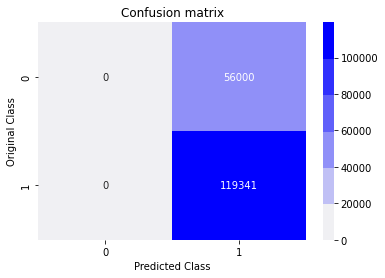

In [128]:
plot_cm(cm_svm)

AUC_SVM:  0.5


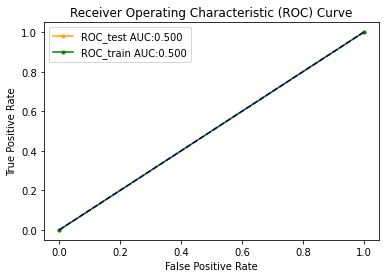

In [129]:
# finding the FPR and TPR for SVM set
fpr_te_svm, tpr_te_svm, t_te_svm = roc_curve(y_test, predict_y_te_svm)
fpr_tr_svm, tpr_tr_svm, t_tr_svm = roc_curve(y_train, predict_y_tr_svm)
auc_te_svm = auc(fpr_te_svm, tpr_te_svm)
print("AUC_SVM: ",auc_te_svm)
plot_roc_curve(fpr_tr_svm,tpr_tr_svm,fpr_te_svm, tpr_te_svm)

## 5.4 Random Forest Model

In [130]:
param_grid = {"n_estimators": [10,100,500,1000, 2000],
    "min_samples_split": [50, 80, 120, 200],
              "max_depth": [3, 5, 10, 50, 100]}
rfc = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1)
gridCV_rfc = GridSearchCV(rfc, param_grid, cv=3, verbose=10, n_jobs=-1)
gridCV_rfc.fit(df_train, y_train)
#grid Search cv results are stored in result for future use
results_rfc = pd.DataFrame.from_dict(gridCV_rfc.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 1/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 3/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 1/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 3/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 1/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 2/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 2/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 3/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 1/3; 4/100] START max_depth=3, min_samples_split=50, n_estimators=1000......
[CV 2/3; 4/100] START max_depth=3, min_samples_split=50, n_estimators=1000......
[CV 3/3; 4/100] START max_depth=3, min_samples

In [131]:
results_rfc = results_rfc.sort_values(['rank_test_score'])
results_rfc.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
61,9.656138,0.748147,0.858835,0.073903,50,50,100,"{'max_depth': 50, 'min_samples_split': 50, 'n_...",0.951246,0.945343,0.902857,0.933149,0.021555,1
81,9.258171,0.747963,0.902516,0.179254,100,50,100,"{'max_depth': 100, 'min_samples_split': 50, 'n...",0.951246,0.945343,0.902857,0.933149,0.021555,1
63,75.627038,8.360490,4.376411,0.463313,50,50,1000,"{'max_depth': 50, 'min_samples_split': 50, 'n_...",0.950991,0.945343,0.903075,0.933137,0.021381,3
83,74.705618,7.984664,4.552552,0.356570,100,50,1000,"{'max_depth': 100, 'min_samples_split': 50, 'n...",0.950991,0.945343,0.903075,0.933137,0.021381,3
82,39.742121,3.910212,2.632738,0.460825,100,50,500,"{'max_depth': 100, 'min_samples_split': 50, 'n...",0.950955,0.944651,0.903513,0.933039,0.021037,5


In [132]:
print(gridCV_rfc.best_params_)

{'max_depth': 50, 'min_samples_split': 50, 'n_estimators': 100}


In [133]:
rfc= RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=gridCV_rfc.best_params_['max_depth'],min_samples_split=gridCV_rfc.best_params_['min_samples_split'], n_estimators=gridCV_rfc.best_params_['n_estimators'])
rfc.fit(df_train,y_train)
sig_clf_rfc = CalibratedClassifierCV(rfc, method="sigmoid")
sig_clf_rfc.fit(df_train, y_train)
predict_y_tr_rfc = sig_clf_rfc.predict(df_train)
predict_y_te_rfc = sig_clf_rfc.predict(df_test)
rfc_f1 = f1_score(y_test, predict_y_te_rfc)
print(rfc_f1)

0.9287112006325395


In [134]:
cm_rfc = confusion_matrix(y_test, predict_y_te_rfc)

In [135]:
tn, fp, fn, tp = cm_rfc.ravel()

In [136]:
fpr_rfc = fp/(fp+tn)*100
fnr_rfc = fn/(fn+tp)*100
far_rfc = (fpr_rfc+fnr_rfc)/2
print("far:",far_rfc)

far: 7.673006215981335


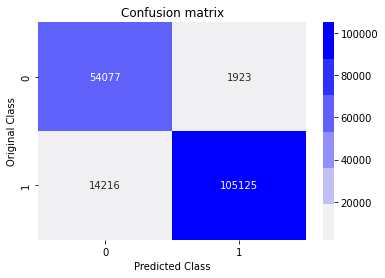

In [137]:
plot_cm(cm_rfc)

AUC_RFC:  0.9232699378401867


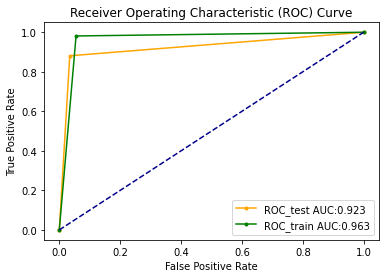

In [138]:
#finding the FPR and TPR for RFC set
fpr_te_rfc, tpr_te_rfc, t_te_rfc = roc_curve(y_test, predict_y_te_rfc)
fpr_tr_rfc, tpr_tr_rfc, t_tr_rfc = roc_curve(y_train, predict_y_tr_rfc)
auc_te_rfc = auc(fpr_te_rfc, tpr_te_rfc)
print("AUC_RFC: ",auc_te_rfc)
plot_roc_curve(fpr_tr_rfc,tpr_tr_rfc,fpr_te_rfc, tpr_te_rfc)

## 5.5 Stacking classifier

In [139]:
clf1 = SGDClassifier(alpha=0.0001,eta0=1, penalty='l2', loss='log', n_jobs = -1, max_iter=10)
clf1.fit(df_train, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001,eta0=0.0001, penalty='l2', loss='hinge', n_jobs = -1, max_iter=5)
clf2.fit(df_train, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=50,min_samples_split=50, n_estimators=10)
clf3.fit(df_train, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

In [140]:
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
    sclf.fit(df_train, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log loss: %0.3f F1-score: %0.3f" % (i, log_loss(y_test, sclf.predict_proba(df_test)),f1_score(y_test, sclf.predict(df_test))))

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

Stacking Classifer : for the value of alpha: 0.000100 Log loss: 0.482 F1-score: 0.934


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

Stacking Classifer : for the value of alpha: 0.001000 Log loss: 0.289 F1-score: 0.928


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

Stacking Classifer : for the value of alpha: 0.010000 Log loss: 0.287 F1-score: 0.927


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

Stacking Classifer : for the value of alpha: 0.100000 Log loss: 0.310 F1-score: 0.927


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

Stacking Classifer : for the value of alpha: 1.000000 Log loss: 0.314 F1-score: 0.927


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

Stacking Classifer : for the value of alpha: 10.000000 Log loss: 0.315 F1-score: 0.927


In [141]:
lr = LogisticRegression(C=0.0001)
sig_clf_sc = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
sig_clf_sc.fit(df_train, y_train)
predict_y_tr_sc= sig_clf_sc.predict(df_train)
predict_y_te_sc = sig_clf_sc.predict(df_test)
sc_f1 = f1_score(y_test, predict_y_te_sc)
print(sc_f1)

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

0.9338045934724338


In [142]:
import pickle

file_pkl = "model_rf.pkl"
with open(file_pkl, 'wb') as file:
    pickle.dump(sig_clf_rfc, file)

In [143]:
cm_sc = confusion_matrix(y_test, predict_y_te_sc)

In [144]:
tn, fp, fn, tp = cm_sc.ravel()

In [145]:
fpr_sc = fp/(fp+tn)*100
fnr_sc = fn/(fn+tp)*100
far_sc = (fpr_sc+fnr_sc)/2
print("far:",far_sc)

far: 7.459184321158936


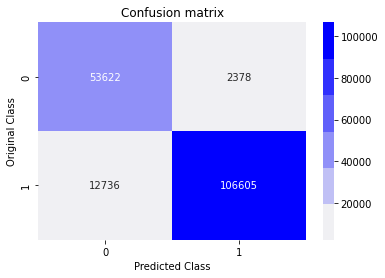

In [146]:
plot_cm(cm_sc)

AUC_SC:  0.9254081567884106


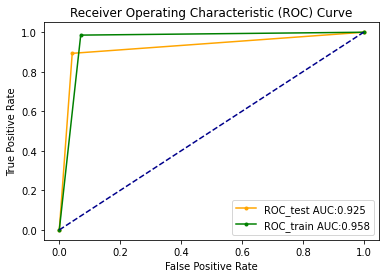

In [147]:
#finding the FPR and TPR for RFC set
fpr_te_sc, tpr_te_sc, t_te_sc = roc_curve(y_test, predict_y_te_sc)
fpr_tr_sc, tpr_tr_sc, t_tr_sc = roc_curve(y_train, predict_y_tr_sc)
auc_te_sc = auc(fpr_te_sc, tpr_te_sc)
print("AUC_SC: ",auc_te_sc)
plot_roc_curve(fpr_tr_sc,tpr_tr_sc,fpr_te_sc, tpr_te_sc)

## 5.6. Model Evaluation

Measures | Equations
----------|------------
FPR | FP/(TN + FP)
FNR | FN/(FN + TP)
FAR | (FPR + FNR)/2

In [148]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "F1 Score", "AUC","FPR %","FNR %","FAR %"]
x.add_row(["Logistic Regression", "{0:.4}".format(lr_f1), "{0:.4}".format(auc_te_lr),"%.2f" % float(fpr_lr),"%.2f" % float(fnr_lr),"%.2f" % float(far_lr)])
x.add_row(["Linear SVM", "{0:.4}".format(svm_f1), "{0:.4}".format(auc_te_svm),"%.2f" % float(fpr_svm),"%.2f" % float(fnr_svm),"%.2f" % float(far_svm)])
x.add_row(["Random Forest", "{0:.4}".format(rfc_f1), "{0:.4}".format(auc_te_rfc),"%.2f" % float(fpr_rfc),"%.2f" % float(fnr_rfc),"%.2f" % float(far_rfc)])
x.add_row(["Stacking Classifier", "{0:.4}".format(sc_f1), "{0:.4}".format(auc_te_sc),"%.2f" % float(fpr_sc),"%.2f" % float(fnr_sc),"%.2f" % float(far_sc)])
print(x)

+---------------------+----------+--------+--------+-------+-------+
|        Model        | F1 Score |  AUC   | FPR %  | FNR % | FAR % |
+---------------------+----------+--------+--------+-------+-------+
| Logistic Regression |   0.81   |  0.5   | 100.00 |  0.00 | 50.00 |
|      Linear SVM     |   0.81   |  0.5   | 100.00 |  0.00 | 50.00 |
|    Random Forest    |  0.9287  | 0.9233 |  3.43  | 11.91 |  7.67 |
| Stacking Classifier |  0.9338  | 0.9254 |  4.25  | 10.67 |  7.46 |
+---------------------+----------+--------+--------+-------+-------+


# 6. Machine Learning Models (Label Encoder)

## 6.1 Reading Train and Test data

In [149]:
train_data = pd.read_csv("../idiot/data/UNSW/UNSW_NB15_training-set.csv")
print(train_data.shape)
train_data.head()

(82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [150]:
cat_feature = train_data.select_dtypes(include=['category', object]).columns

In [151]:
train_data[cat_feature] = train_data[cat_feature].apply(LabelEncoder().fit_transform)
train_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,117,0,4,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,6,0
1,2,0.000008,117,0,4,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,6,0
2,3,0.000005,117,0,4,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,6,0
3,4,0.000006,117,0,4,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,6,0
4,5,0.000010,117,0,4,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,6,0


In [152]:
df_train = train_data[list(col_set)]
df_train.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,state,...,ct_state_ttl,dload,swin,sttl,spkts,tcprtt,sjit,ct_dst_ltm,dttl,proto
0,0,0,0,0.0,0.0,0,0,0,0.0,4,...,2,0.0,0,254,2,0.0,0.0,1,0,117
1,0,0,0,0.0,0.0,0,0,0,0.0,4,...,2,0.0,0,254,2,0.0,0.0,1,0,117
2,0,0,0,0.0,0.0,0,0,0,0.0,4,...,2,0.0,0,254,2,0.0,0.0,1,0,117
3,0,0,0,0.0,0.0,0,0,0,0.0,4,...,2,0.0,0,254,2,0.0,0.0,2,0,117
4,0,0,0,0.0,0.0,0,0,0,0.0,4,...,2,0.0,0,254,2,0.0,0.0,2,0,117


In [153]:
test_data = pd.read_csv("/home/pail/cngvng/UNSW_NB15_full/data/UNSW_NB15_testing-set.csv")
print(test_data.shape)
test_data.head()

(175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [154]:
cat_feature_test = test_data.select_dtypes(include=['category', object]).columns

In [155]:
test_data[cat_feature_test] = test_data[cat_feature_test].apply(LabelEncoder().fit_transform)
test_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,113,0,2,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,6,0
1,2,0.649902,113,0,2,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,6,0
2,3,1.623129,113,0,2,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,6,0
3,4,1.681642,113,3,2,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,6,0
4,5,0.449454,113,0,2,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,6,0


In [156]:
df_test = test_data[list(col_set)]
df_test.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,state,...,ct_state_ttl,dload,swin,sttl,spkts,tcprtt,sjit,ct_dst_ltm,dttl,proto
0,0,43,0,0.000000,0.000000,0,4,621772692,11.830604,2,...,0,8495.365234,255,252,6,0.000000,30.177547,1,254,113
1,0,1106,0,0.000000,0.000000,0,38,1417884146,1387.778330,2,...,1,503571.312500,255,62,14,0.000000,61.426934,1,252,113
2,0,824,0,0.061458,0.050439,0,16,2116150707,11420.926230,2,...,1,60929.230470,255,62,8,0.111897,17179.586860,2,252,113
3,0,64,0,0.000000,0.000000,0,12,1107119177,4991.784669,2,...,1,3358.622070,255,62,12,0.000000,259.080172,2,252,113
4,0,45,0,0.071147,0.057234,0,6,2436137549,115.807000,2,...,1,3987.059814,255,254,10,0.128381,2415.837634,2,252,113


### 6.1.1 Standardize the data

In [157]:
x = df_train.values
x_test = df_test.values
std_scaler = preprocessing.MinMaxScaler()
std_scaler.fit(x)
x_scaled = std_scaler.transform(x)
df_train = pd.DataFrame(x_scaled)
x_scaled_test = std_scaler.transform(x_test)
df_test = pd.DataFrame(x_scaled_test)

In [158]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,...,0.333333,0.0,0.0,0.996078,0.000094,0.0,0.0,0.000000,0.0,0.9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,...,0.333333,0.0,0.0,0.996078,0.000094,0.0,0.0,0.000000,0.0,0.9
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,...,0.333333,0.0,0.0,0.996078,0.000094,0.0,0.0,0.000000,0.0,0.9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,...,0.333333,0.0,0.0,0.996078,0.000094,0.0,0.0,0.017241,0.0,0.9
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,...,0.333333,0.0,0.0,0.996078,0.000094,0.0,0.0,0.017241,0.0,0.9


In [159]:
y_train = train_data['label']
y_test = test_data['label']
print("train data shape", df_train.shape, y_train.shape)
print("test data shape", df_test.shape, y_test.shape)

train data shape (82332, 33) (82332,)
test data shape (175341, 33) (175341,)


In [160]:
[10 ** x for x in range(-5, 2)]

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

## 6.2 Logistic Regression Model

In [161]:
prams={
    'alpha':[10 ** x for x in range(-4, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-4, 1)]
}
lr_cfl=GridSearchCV(SGDClassifier(penalty='l2', loss='log', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
lr_cfl.fit(df_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 2/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 3/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 4/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 1/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 2/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 3/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 4/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 5/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 1/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 2/5; 3/125] START alpha=0.0001, eta0=0.000

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.729 total time=   0.3s
[CV 2/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.951 total time=   0.3s
[CV 3/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 4/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 3/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.833 total time=   0.3s
[CV 5/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 1/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.936 total time=   0.4s
[CV 4/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.796 total time=   0.4s
[CV 1/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................[CV 2/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................

[CV 2/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.951 total time=   0.4s
[CV 3/5; 4/125] START alpha=0.0001, eta0=0.0001,

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.951 total time=   0.7s
[CV 5/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.753 total time=   0.7s
[CV 1/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 1/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.900 total time=   0.6s
[CV 2/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 3/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 3/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.845 total time=   0.5s
[CV 4/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 4/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.739 total time=   0.7s
[CV 4/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.788 total time=   0.5s
[CV 5/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 1/5; 6/125] START alpha=0.0001, eta0=0.

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.854 total time=   0.4s
[CV 4/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 4/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.795 total time=   0.4s
[CV 5/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 1/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.888 total time=   0.7s
[CV 3/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.852 total time=   0.2s
[CV 1/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................[CV 1/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.903 total time=   0.3s

[CV 2/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 3/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 5/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.766 total time=   0.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 2/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.985 total time=   0.3s
[CV 5/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 4/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.727 total time=   0.4s
[CV 5/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.695 total time=   0.3s
[CV 1/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 2/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 1/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.885 total time=   0.5s
[CV 3/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 3/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.861 total time=   0.5s
[CV 4/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 4/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 1/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.902 total time=   0.6s
[CV 4/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 3/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.834 total time=   0.7s
[CV 5/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 1/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.903 total time=   0.5s
[CV 2/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.943 total time=   0.6s
[CV 1/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 2/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 4/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.718 total time=   0.6s
[CV 3/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.683 total time=   0.4s
[CV 4/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................
[CV 3/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.838 total time=   0.4s[CV 5/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.769 total time=   0.4s
[CV 5/5; 11/125] START alpha=0.0001, eta0=0.01, max_iter=5......................

[CV 2/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.971 total time=   0.2s
[CV 2/5; 9/125] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.964 total time=   0.5s
[CV 1/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 2/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 3/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 1/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.939 total time=   0.3s
[CV 4/5; 12/125] START alpha=0.0001, eta0=0.01, max

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.947 total time=   0.5s
[CV 3/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.836 total time=   0.4s
[CV 5/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 1/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.902 total time=   0.5s
[CV 1/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 2/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 4/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.799 total time=   0.5s
[CV 4/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.684 total time=   0.3s
[CV 3/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.838 total time=   0.6s
[CV 3/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 4/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 5/5; 13/125] START alpha=0.0001, eta0=0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.838 total time=   0.5s
[CV 3/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 4/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.664 total time=   0.4s
[CV 4/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 2/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.979 total time=   0.5s
[CV 1/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.937 total time=   0.5s
[CV 5/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 1/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 5/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.767 total time=   0.4s
[CV 2/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.953 total time=   0.5s
[CV 5/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.752 total time=   0.5s
[CV 3/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 4/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 1/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.899 total time=   0.4s
[CV 5/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 3/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.857 total time=   0.5s
[CV 1/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 1/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.902 total time=   0.6s
[CV 2/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.953 total time=   0.5s
[CV 2/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................[CV 3/5; 16/125] START alpha=0.0001, eta0=0.1, max

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.987 total time=   0.3s
[CV 2/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 3/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 3/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.857 total time=   0.4s
[CV 5/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.769 total time=   0.5s
[CV 3/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.828 total time=   0.5s
[CV 4/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 5/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 1/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 5/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.750 total time=   0.4s
[CV 2/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.904 total time=   0.4s
[CV 3/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 2/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.965 total time=   0.4s
[CV 4/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 5/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.768 total time=   0.4s
[CV 5/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.860 total time=   0.6s
[CV 1/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 4/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.757 total time=   0.6s
[CV 2/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 1/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.901 total time=   0.5s
[CV 2/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.950 total time=   0.5s
[CV 3/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 4/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 5/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.762 total time=   0.5s
[CV 5/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 4/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.732 total time=   0.6s
[CV 1/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=2

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 1/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.934 total time=   0.5s
[CV 3/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.690 total time=   0.4s
[CV 2/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.951 total time=   0.5s
[CV 4/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................[CV 5/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................

[CV 3/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.843 total time=   0.5s
[CV 1/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 2/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.967 total time=   0.4s[CV 1/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.901 total time=   0.5s

[CV 2/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 5/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.768 total time=   0.5s
[CV 3/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 4/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100..........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.619 total time=   0.3s
[CV 3/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.819 total time=   0.4s
[CV 3/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 4/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 3/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.848 total time=   0.5s
[CV 5/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 2/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.949 total time=   0.6s
[CV 1/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 5/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.627 total time=   0.3s
[CV 2/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 1/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.895 total time=   0.4s
[CV 5/5; 27/125] END alpha=0.001, eta0=0.0001, max_i

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



[CV 5/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.597 total time=   0.5s
[CV 4/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.645 total time=   0.3s
[CV 5/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 1/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 5/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.654 total time=   0.3s
[CV 1/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.878 total time=   0.3s
[CV 2/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 3/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................[CV 2/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.941 total time=   0.3s



/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 3/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.831 total time=   0.4s
[CV 5/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 2/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.944 total time=   0.4s
[CV 4/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.621 total time=   0.4s
[CV 1/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.887 total time=   0.4s
[CV 1/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 3/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 2/5; 35/125] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 5/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.755 total time=   0.5s
[CV 3/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.823 total time=   0.4s
[CV 4/5; 35/125] START alpha=0.001, eta0=0.001, m

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.887 total time=   0.2s
[CV 4/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.620 total time=   0.4s
[CV 5/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.681 total time=   0.4s
[CV 1/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 2/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 2/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.950 total time=   0.2s
[CV 3/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 4/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 3/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.823 total time=   0.2s
[CV 5/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 1/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.883 total time=   0.4s
[CV 2/5; 35/125] END alpha=0.001, eta0=0.001, max_iter

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.892 total time=   0.4s
[CV 1/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.890 total time=   0.3s
[CV 2/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................[CV 3/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................

[CV 2/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.950 total time=   0.4s
[CV 4/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 3/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.849 total time=   0.4s
[CV 5/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 4/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.636 total time=   0.4s
[CV 1/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 1/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.880 total time=   0.4s
[CV 2/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 1/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.881 total time=   0.4s
[CV 3/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 3/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.819 total time=   0.4s
[CV 4/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 4/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.621 total time=   0.3s
[CV 1/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.882 total time=   0.3s
[CV 5/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 4/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.620 total time=   0.4s
[CV 1/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 2/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 2/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.941

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 4/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.619 total time=   0.4s
[CV 2/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.942 total time=   0.3s
[CV 2/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 1/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.884 total time=   0.5s[CV 3/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.835 total time=   0.3s

[CV 3/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 4/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................[CV 5/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................

[CV 4/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.620 total time=   0.3s
[CV 1/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 5/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.742 total tim

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.828 total time=   0.2s
[CV 1/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 4/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.664 total time=   0.4s
[CV 2/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 5/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.742 total time=   0.4s
[CV 3/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 5/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.685 total time=   0.4s
[CV 4/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.620 total time=   0.4s
[CV 4/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 5/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 1/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.894 total time=   0.4s
[CV 1/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.593 total time=   0.3s
[CV 1/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 5/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.594 total time=   0.4s
[CV 2/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 1/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.828 total time=   0.4s
[CV 3/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 5/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.595 total time=   0.3s
[CV 4/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 4/5; 53/125] END alpha=0.01, eta0=0.0001, max_iter=20;, score=0.595 total time=   0.4s
[CV 1/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.827 total time=   0.4s
[CV 5/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................[CV 2/5; 53/125] END alpha=0.01, eta0=0.0001, max_

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.828 total time=   0.5s
[CV 1/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 2/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.891 total time=   0.5s[CV 2/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.896 total time=   0.4s

[CV 2/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 3/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.707 total time=   0.4s
[CV 3/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 4/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 1/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.828 total time=   0.5s
[CV 4/5; 57/125] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.597 total time=   0.3s
[CV 5/5; 59/125] START alpha=0.01, eta0=0.001, max_iter=50......................
[CV 1/5; 60/125] START alpha=0.01, eta0=0.001, max_iter=1

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.705 total time=   0.3s
[CV 2/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 2/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.894 total time=   0.4s
[CV 5/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.595 total time=   0.4s
[CV 3/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 4/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 4/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.599 total time=   0.4s[CV 1/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.827 total time=   0.5s

[CV 5/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 1/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 1/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.828 total time=   0.3s
[CV 2/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 5/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.595 total time=   0.4s
[CV 4/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.593 total time=   0.4s
[CV 1/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................[CV 5/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 3/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.706 total time=   0.4s
[CV 2/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................

[CV 2/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.895 total time=   0.3s
[CV 3/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 3/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.706 total time=   0.3s
[CV 4/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 4/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.593

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.827 total time=   0.4s
[CV 4/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 5/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 4/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.596 total time=   0.5s
[CV 1/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 2/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.895 total time=   0.3s
[CV 2/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 5/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.595 total time=   0.5s
[CV 3/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 3/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.706 total time=   0.4s[CV 5/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.595 total time=   0.3s
[CV 4/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50.........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.598 total time=   0.5s
[CV 5/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 5/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.595 total time=   0.3s
[CV 4/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.595 total time=   0.3s
[CV 1/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 2/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 1/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.827 total time=   0.3s
[CV 3/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 3/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.706 total time=   0.4s
[CV 4/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



[CV 2/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.862 total time=   0.4s
[CV 5/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 4/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.591 total time=   0.4s
[CV 1/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 2/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.858 total time=   0.4s
[CV 1/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.828 total time=   0.4s
[CV 2/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 4/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.597 total time=   0.3s
[CV 3/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 4/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 1/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.827 total time=   0.3s
[CV 5/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.......................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.896 total time=   0.6s
[CV 2/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 3/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.654 total time=   0.3s
[CV 3/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 5/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.580 total time=   0.3s
[CV 2/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.754 total time=   0.4s[CV 4/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................

[CV 5/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 3/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.654 total time=   0.3s
[CV 1/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.662 total time=   0.5s
[CV 1/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................
[CV 1/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;,

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 3/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 2/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.752 total time=   0.4s[CV 5/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.581 total time=   0.5s

[CV 4/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 5/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 2/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.753 total time=   0.5s[CV 2/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.752 total time=   0.3s
[CV 1/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................

[CV 2/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 3/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.654 total time=   0.3s[CV 1/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.6

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.581 total time=   0.3s
[CV 1/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 1/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.661 total time=   0.4s
[CV 2/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 4/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.573 total time=   0.4s
[CV 3/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 3/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.655 total time=   0.3s
[CV 4/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 1/5; 84/125] END alpha=0.1, eta0=0.001, max_iter=50;, score=0.661 total time=   0.3s
[CV 5/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.581 total time=   0.4s
[CV 4/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.573 total time=   0.4s
[CV 5/5; 85/125] START alpha=0.1, eta0=0.001, max_ite

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 3/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.654 total time=   0.5s
[CV 1/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 1/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.662 total time=   0.4s
[CV 5/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.581 total time=   0.5s
[CV 2/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 3/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 4/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.573 total time=   0.4s
[CV 4/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 2/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.752 total time=   0.4s
[CV 3/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.654 total time=   0.4s
[CV 5/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50.......

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.661 total time=   0.4s[CV 5/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.581 total time=   0.3s
[CV 4/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.573 total time=   0.3s
[CV 1/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.661 total time=   0.2s

[CV 3/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 4/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 1/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 5/5; 92/125] START alpha=0.1, eta0=0.1, max_iter=10.........................
[CV 5/5; 89/125] END alpha=0.1, eta0=0.01, max_iter=50;, score=0.581 total time=   0.5s
[CV 2/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 3/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.653 total time=   0.2s
[CV 3/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.661 total time=   0.4s
[CV 4/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................
[CV 3/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.654 total time=   0.5s
[CV 5/5; 95/125] START alpha=0.1, eta0=0.1, max_iter=100........................
[CV 4/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.573 total time=   0.4s
[CV 1/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 5/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.581 total time=   0.4s
[CV 3/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.654 total time=   0.3s
[CV 2/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 3/5; 96/125] START alpha=0.1, eta0=1, max_iter=5............................
[CV 2/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.754 total time=   0.3s
[CV 4/5; 96/125] START alpha=0.1, eta0=1, max_iter=5....................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.661 total time=   0.3s
[CV 1/5; 94/125] END alpha=0.1, eta0=0.1, max_iter=50;, score=0.662 total time=   0.6s
[CV 2/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................[CV 3/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................

[CV 4/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.572 total time=   0.3s
[CV 3/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.654 total time=   0.3s
[CV 4/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 5/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 2/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.754 total time=   0.4s
[CV 1/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 1/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.661 total time=   0.3s
[CV 2/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 5/

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.551 total time=   0.3s
[CV 4/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 2/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.551 total time=   0.3s
[CV 5/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 3/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.559 total time=   0.4s
[CV 1/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 2/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.551 total time=   0.3s
[CV 2/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 4/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.551 total time=   0.4s[CV 5/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.551 total time=   0.4s

[CV 3/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 4/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 3/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 4/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 1/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.551 total time=   0.4s
[CV 5/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 4/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.551 total time=   0.4s
[CV 1/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 1/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.556 total time=   0.3s
[CV 5/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.533 total time=   0.4s[CV 2/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................

[CV 2/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.560 total time=   0.3s
[CV 3/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.551 total time=   0.3s
[CV 1/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 1/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.737 total time=   0.3s
[CV 3/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.551 total time=   0.3s
[CV 2/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 3/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 4/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.565 total time=   0.4s
[CV 4/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 2/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.766 total time=   0.4s
[CV 3/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.552 total time=   0.3s
[CV 5/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................[CV 1/5; 115/125] START alpha=1, eta0=0.01, max_iter=100....................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.551 total time=   0.3s
[CV 2/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 4/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.551 total time=   0.3s
[CV 5/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.545 total time=   0.4s
[CV 3/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 2/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.698 total time=   0.4s
[CV 4/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 4/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.551 total time=   0.4s
[CV 5/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 1/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 1/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.551 total time=   0.4s
[CV 2/5; 116/125] START alpha=1, eta0=0.1, max_iter=5....................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.551 total time=   0.4s
[CV 4/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.551 total time=   0.5s[CV 1/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................

[CV 2/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 3/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 3/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.554 total time=   0.4s
[CV 3/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.551 total time=   0.3s
[CV 4/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 5/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 4/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.548 total time=   0.3s
[CV 1/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 5/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.551 total time=   0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.551 total time=   0.3s
[CV 3/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 1/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.735 total time=   0.3s
[CV 4/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 3/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.639 total time=   0.3s
[CV 5/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 2/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.551 total time=   0.3s
[CV 1/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 5/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.533 total time=   0.4s
[CV 2/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 4/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.551 total time=   0.4s
[CV 3/5; 120/125] START alpha=1, eta0=0.1, max_iter=100........................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.551 total time=   0.5s
[CV 4/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 4/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.549 total time=   0.3s
[CV 2/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.551 total time=   0.4s[CV 5/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 3/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.634 total time=   0.4s

[CV 1/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 2/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 2/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.551 total time=   0.3s
[CV 3/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 1/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.770 total time=   0.4s
[CV 4/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 5/5; 1

GridSearchCV(estimator=SGDClassifier(loss='log', n_jobs=-1), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [162]:
results = pd.DataFrame.from_dict(lr_cfl.cv_results_)
results = results.sort_values(['rank_test_score'])
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta0,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.345938,0.076563,0.012940,0.005426,0.0001,1,5,"{'alpha': 0.0001, 'eta0': 1, 'max_iter': 5}",0.903261,0.971822,0.852727,0.791996,0.761691,0.856299,0.075696,1
24,0.472435,0.090828,0.006879,0.000531,0.0001,1,100,"{'alpha': 0.0001, 'eta0': 1, 'max_iter': 100}",0.966600,0.949171,0.847808,0.764545,0.752399,0.856105,0.089529,2
16,0.490307,0.098758,0.005813,0.000328,0.0001,0.1,10,"{'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 10}",0.903747,0.964657,0.859711,0.757257,0.768310,0.850736,0.079247,3
3,0.495528,0.090901,0.008056,0.002679,0.0001,0.0001,50,"{'alpha': 0.0001, 'eta0': 0.0001, 'max_iter': 50}",0.887715,0.947714,0.853577,0.794971,0.766367,0.850069,0.064816,4
0,0.332462,0.054483,0.008919,0.004427,0.0001,0.0001,5,"{'alpha': 0.0001, 'eta0': 0.0001, 'max_iter': 5}",0.936479,0.950871,0.833171,0.795822,0.728592,0.848987,0.084388,5


In [163]:
print(lr_cfl.best_params_)

{'alpha': 0.0001, 'eta0': 1, 'max_iter': 5}


In [164]:
logisticR=SGDClassifier(alpha=lr_cfl.best_params_['alpha'],eta0=lr_cfl.best_params_['eta0'], penalty='l2', loss='log', n_jobs = -1, max_iter=lr_cfl.best_params_['max_iter'])
logisticR.fit(df_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(df_train, y_train)
predict_y_tr_lr = sig_clf.predict(df_train)
predict_y_te_lr = sig_clf.predict(df_test)
lr_f1 = f1_score(y_test, predict_y_te_lr)
print(lr_f1)

0.8138412334906125


In [165]:
cm_lr = confusion_matrix(y_test, predict_y_te_lr)

In [166]:
tn, fp, fn, tp = cm_lr.ravel()

In [167]:
fpr_lr = fp/(fp+tn)*100
fnr_lr = fn/(fn+tp)*100
far_lr = (fpr_lr+fnr_lr)/2
print("FAR: %0.2f" %far_lr)

FAR: 16.19


In [168]:
def plot_cm(cm):
    sns.heatmap(cm, annot=True, cmap=sns.light_palette("blue"), fmt="g")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

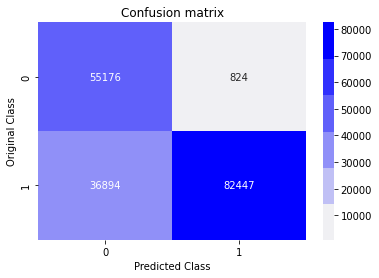

In [169]:
plot_cm(cm_lr)

In [170]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(fpr_tr, tpr_tr,fpr_te, tpr_te):
    '''
    plot the ROC curve for the FPR and TPR value
    '''
    plt.plot(fpr_te, tpr_te, 'k.-', color='orange', label='ROC_test AUC:%.3f'% auc(fpr_te, tpr_te))
    plt.plot(fpr_tr, tpr_tr, 'k.-', color='green', label='ROC_train AUC:%.3f'% auc(fpr_tr, tpr_tr))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC_LR:  0.838068988983549


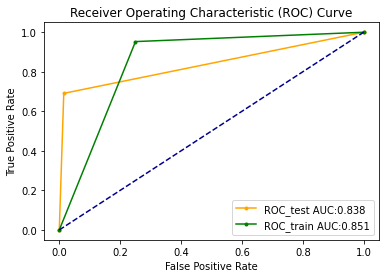

In [171]:
#finding the FPR and TPR for logistic reg model set
fpr_te_lr, tpr_te_lr, t_te_lr = roc_curve(y_test, predict_y_te_lr)
fpr_tr_lr, tpr_tr_lr, t_tr_lr = roc_curve(y_train, predict_y_tr_lr)
auc_te_lr = auc(fpr_te_lr, tpr_te_lr)
print("AUC_LR: ",auc_te_lr)
plot_roc_curve(fpr_tr_lr,tpr_tr_lr,fpr_te_lr, tpr_te_lr)

## 6.3 Support Vector Machine Model

In [172]:
prams={
    'alpha':[10 ** x for x in range(-4, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-4, 1)]
}
svm_cfl=GridSearchCV(SGDClassifier(penalty='l1', loss='hinge', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
svm_cfl.fit(df_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 2/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 3/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 4/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 1/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 2/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 3/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 4/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 5/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 1/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 2/5; 3/125] START alpha=0.0001, eta0=0.000

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.867 total time=   0.3s
[CV 3/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 5/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.806 total time=   0.3s
[CV 2/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.956 total time=   0.3s
[CV 4/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 1/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.860 total time=   0.3s
[CV 5/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................[CV 1/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................

[CV 4/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.813 total time=   0.4s
[CV 2/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.866 total time=   0.5s
[CV 3/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 5/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.797 total time=   0.5s
[CV 4/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 4/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.804 total time=   0.6s
[CV 5/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 2/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.966 total time=   0.6s
[CV 1/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.901 total time=   0.6s[CV 1/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................

[CV 2/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 5/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.801 total time=   0.5s
[CV 3/5; 5/125] START alpha=0.0001, eta0=0.

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.861 total time=   0.8s
[CV 3/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 1/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.925 total time=   0.8s
[CV 4/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 1/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.912 total time=   0.2s
[CV 5/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 5/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.811 total time=   0.6s
[CV 4/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.763 total time=   0.6s
[CV 2/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.960 total time=   0.6s
[CV 1/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 2/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 2/5; 6/125] END alpha=0.0001, eta0=0.001

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.803 total time=   0.6s
[CV 4/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 5/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.810 total time=   0.6s
[CV 5/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 3/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.870 total time=   0.4s
[CV 1/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 5/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.799 total time=   0.4s
[CV 2/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 1/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.897 total time=   0.5s
[CV 3/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 2/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.970 total time=   0.5s
[CV 4/5; 9/125] START alpha=0.0001, eta0=0.001

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.809 total time=   0.5s
[CV 4/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.794 total time=   0.6s
[CV 5/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 1/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 3/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.867 total time=   0.9s
[CV 2/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 1/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.847 total time=   0.6s
[CV 3/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 3/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.872 total time=   0.6s
[CV 4/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 2/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.961 total time=   0.7s
[CV 5/5; 10/125] START alpha=0.0001, eta0=0.001

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.776 total time=   0.3s
[CV 1/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 4/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.763 total time=   0.7s
[CV 2/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 3/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.845 total time=   0.8s
[CV 5/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.795 total time=   0.6s
[CV 3/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 4/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 5/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.792 total time=   0.3s[CV 1/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.890 total time=   0.9s

[CV 5/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 1/5; 14/125] START alpha=0.0001, eta0=0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.887 total time=   0.4s
[CV 3/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 2/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.959 total time=   0.4s
[CV 4/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 3/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.864 total time=   0.5s
[CV 5/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.810 total time=   0.4s
[CV 5/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 1/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 4/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.819 total time=   0.5s
[CV 2/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 2/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.951 total time=   0.6s
[CV 3/5; 15/125] START alpha=0.0001, eta0=0.01, m

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.878 total time=   0.7s
[CV 4/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 2/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.945 total time=   0.6s
[CV 5/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 3/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.871 total time=   0.3s
[CV 1/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 2/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.969 total time=   0.3s
[CV 2/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 4/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.824 total time=   0.6s
[CV 3/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.797 total time=   0.3s
[CV 4/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 4/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.817 total time=   0.4s
[CV 5/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 5/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.803 total time=   0.7s
[CV 1/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 2/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.961 total time=   0.5s
[CV 3/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.867 total time=   0.4s
[CV 1/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.902 total time=   0.5s
[CV 2/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 3/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 4/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=1

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.826 total time=   0.6s
[CV 3/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 1/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.891 total time=   0.7s
[CV 4/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 5/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.812 total time=   0.7s
[CV 5/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 2/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.957 total time=   0.6s
[CV 3/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.867 total time=   0.8s
[CV 1/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 2/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.954 total time=   0.8s
[CV 2/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 3/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 3/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.872 total time=   0.3s
[CV 3/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 4/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.811 total time=   0.9s
[CV 4/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 4/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.788 total time=   0.3s
[CV 1/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.883 total time=   0.3s
[CV 5/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 1/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 2/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.959 total time=   0.4s
[CV 2/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 2/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.964 total time=   0.9s
[CV 3/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20..........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 5/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.802 total time=   0.4s
[CV 4/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 5/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.803 total time=   0.8s
[CV 5/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 2/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.960 total time=   0.6s
[CV 1/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.774 total time=   0.7s[CV 4/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.795 total time=   0.5s

[CV 1/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.881 total time=   0.6s
[CV 2/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................[CV 3/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 4/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................

[CV 5/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.809 total time=   0.6s
[CV 5/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 2/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.959 total time=   0.8s
[CV 1/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 1/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.886 total time=   0.6s
[CV 2/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.863 total time=   0.8s
[CV 3/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 3/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.825 total time=   0.3s
[CV 4/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 2/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.949 total time=   0.3s
[CV 4/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.638 total time=   0.3s[CV 5/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 1/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.902 total time=   0.8s
[CV 1/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................

[CV 2/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 4/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.802 total time=   0.6s
[CV 3/5; 28/125] START alpha=0.001, eta0=0.0001, max_ite

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.727 total time=   0.4s
[CV 4/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 2/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.957 total time=   0.8s
[CV 5/5; 28/125] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 5/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.809 total time=   0.7s
[CV 1/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 3/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.870 total time=   0.8s
[CV 3/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.827 total time=   0.3s
[CV 2/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 3/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 1/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.891 total time=   0.5s[CV 2/5; 27/125] END alpha=0.001, eta0=0.0001, max_ite

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python


[CV 1/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 5/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.726 total time=   0.6s
[CV 2/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 4/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.639 total time=   0.4s
[CV 2/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.950 total time=   0.4s
[CV 1/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.892 total time=   0.4s
[CV 3/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................[CV 4/5; 33/125] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.639 total time=   0.3s
[CV 4/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 5/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................

[CV 5/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.726 total time=   0.4s
[CV 1/5; 35/125] START alpha=0.001, eta0=0.001

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 5/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.731 total time=   0.3s
[CV 1/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 3/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 4/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.638 total time=   0.4s
[CV 2/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.947 total time=   0.2s
[CV 4/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 5/5; 37/125] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 2/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.950 total time=   0.5s
[CV 1/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 3/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.821 total time=   0.3s
[CV 3/5; 34/125] END alpha=0.001, eta0=0.001, max_iter=50;, s

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.636 total time=   0.4s
[CV 3/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.823 total time=   0.4s
[CV 4/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 5/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 5/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.726 total time=   0.4s
[CV 1/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 3/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.825 total time=   0.4s
[CV 2/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 1/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.893 total time=   0.4s
[CV 3/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 4/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.637 total time=   0.4s
[CV 4/5; 40/125] START alpha=0.001, eta0=0.01, max_iter

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



[CV 2/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.948 total time=   0.5s
[CV 2/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 1/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 5/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.724 total time=   0.5s
[CV 3/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 1/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.891 total time=   0.5s
[CV 4/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 3/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.822 total time=   0.4s
[CV 5/5; 41/125] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 4/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.638 total time=   0.3s
[CV 1/5; 42/125] START alpha=0.001, eta0=0.1, max_iter=10.......................
[CV 5/5; 39/125] END alpha=0.001, eta0=0.01, max_iter=50;, scor

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 1/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.892 total time=   0.4s
[CV 3/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 2/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.949 total time=   0.4s
[CV 4/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 4/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.640 total time=   0.4s
[CV 5/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 1/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.892 total time=   0.3s
[CV 4/5; 43/125] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.637 total time=   0.3s
[CV 1/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 2/5; 45/125] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 3/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.826

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.640 total time=   0.3s
[CV 3/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 5/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.718 total time=   0.4s
[CV 4/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 3/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.824 total time=   0.5s
[CV 5/5; 48/125] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 5/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.728 total time=   0.3s
[CV 1/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 2/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.947 total time=   0.5s
[CV 2/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 1/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.893 total time=   0.4s
[CV 3/5; 49/125] START alpha=0.001, eta0=1, max_iter=50...............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.721 total time=   0.4s
[CV 3/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 4/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 4/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.637 total time=   0.4s
[CV 5/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 1/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.894 total time=   0.5s
[CV 1/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 5/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.721 total time=   0.5s
[CV 2/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 1/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.892 total time=   0.4s
[CV 3/5; 51/125] START alpha=0.01, eta0=0.0001, max_iter=5......................
[CV 4/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.640 total time=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 5/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.723 total time=   0.4s
[CV 1/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.821 total time=   0.4s
[CV 2/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 4/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.600 total time=   0.3s
[CV 3/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 4/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 3/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.707 total time=   0.3s
[CV 5/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.627 total time=   0.3s
[CV 5/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 1/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 4/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.6

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 1/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.820 total time=   0.3s
[CV 3/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.754 total time=   0.3s
[CV 2/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 3/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 4/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.595 total time=   0.5s[CV 5/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.627 total time=   0.4s
[CV 5/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.630 total time=   0.3s
[CV 4/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................

[CV 5/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................[CV 4/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.595 total time=   0.3s

[CV 1/5; 59/125] START alpha=0.01, eta0=0.001, max_iter

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.587 total time=   0.3s
[CV 1/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 5/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.635 total time=   0.3s
[CV 2/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 3/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.714 total time=   0.4s
[CV 2/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.911 total time=   0.4s
[CV 3/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 1/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.835 total time=   0.3s
[CV 4/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 5/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 5/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.596 total time=   0.3s
[CV 2/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, scor

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................

[CV 2/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 1/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.819 total time=   0.4s
[CV 3/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 5/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.627 total time=   0.3s
[CV 4/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 2/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.913 total time=   0.4s
[CV 5/5; 66/125] START alpha=0.01, eta0=0.1, max_iter=5.........................
[CV 4/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.604 total time=   0.4s
[CV 3/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.720 total time=   0.4s
[CV 1/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................
[CV 2/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 1/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.823 total time=   0.6s
[CV 1/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 4/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.595 total time=   0.4s
[CV 2/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 3/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.746 total time=   0.3s
[CV 2/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.901 total time=   0.4s
[CV 3/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 4/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.819 total time=   0.4s
[CV 5/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 4/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.594 total time=   0.3s
[CV 5/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.597 total time=   0.4s
[CV 2/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 1/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 3/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.719 total time=   0.4s
[CV 3/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 5/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.627 total time=   0.3s
[CV 4/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 4/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.601 total time=   0.5s
[CV 1/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.82

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.629 total time=   0.5s
[CV 3/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.749 total time=   0.3s
[CV 1/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 2/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 2/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.911 total time=   0.5s[CV 2/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.900 total time=   0.7s

[CV 3/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 4/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 4/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.587 total time=   0.3s
[CV 5/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 1/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.821 total time=   0.3s
[CV 1/5; 75/125] START alpha=0.01, eta0=1, max_iter=100...................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.900 total time=   0.4s
[CV 4/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 4/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.595 total time=   0.4s[CV 5/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.632 total time=   0.3s

[CV 5/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 1/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 1/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.820 total time=   0.3s
[CV 2/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 3/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.705 total time=   0.5s
[CV 3/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5.......................
[CV 3/5; 74/125] END alpha=0.01, eta0=1, max_iter=50;, score=0.707 total time=   0.3s
[CV 4/5; 76/125] START alpha=0.1, eta0=0.0001, max_iter=5......................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.907 total time=   0.5s
[CV 5/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 5/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.593 total time=   0.3s
[CV 1/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 3/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.705 total time=   0.4s
[CV 2/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 1/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.667 total time=   0.3s
[CV 3/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 4/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.587 total time=   0.3s
[CV 4/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 2/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.740 total time=   0.3s
[CV 5/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50..

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 1/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.667 total time=   0.4s
[CV 5/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.593 total time=   0.3s
[CV 3/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 2/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.740 total time=   0.2s
[CV 4/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 5/5; 82/125] START alpha=0.1, eta0=0.001, max_iter=10.......................
[CV 3/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.705 total time=   0.2s
[CV 1/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 3/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.705 total time=   0.4s
[CV 2/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 4/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.593 total time=   0.3s
[CV 4/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.587 total time=   0.3s
[CV 1/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 2/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 1/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.667 total time=   0.3s
[CV 3/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 2/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.740 total time=   0.3s
[CV 4/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 5/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.593 total time=   0.4s
[CV 4/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.587 total time=   0.4s
[CV 4/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.587 total time=   0.3s
[CV 5/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50......

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.740 total time=   0.3s
[CV 1/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 5/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.593 total time=   0.2s
[CV 4/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.587 total time=   0.4s
[CV 2/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 3/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 3/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.705 total time=   0.4s
[CV 3/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.705 total time=   0.5s
[CV 4/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................[CV 5/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................

[CV 5/5; 90/125] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.593 total time=   0.5s
[CV 1/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50...............

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 3/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.705 total time=   0.4s
[CV 4/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 2/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.740 total time=   0.2s
[CV 5/5; 97/125] START alpha=0.1, eta0=1, max_iter=10...........................
[CV 2/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.740 total time=   0.4s
[CV 1/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.667 total time=   0.4s
[CV 1/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 2/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 3/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.705 total time=   0.3s
[CV 3/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 4/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.587 total time=  

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.593 total time=   0.3s
[CV 4/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.587 total time=   0.3s
[CV 1/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 2/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 5/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.593 total time=   0.3s
[CV 1/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.667 total time=   0.4s
[CV 3/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 4/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 2/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.740 total time=   0.3s
[CV 5/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 3/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.705 total time=   0.4s[CV 4/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.587 total time=   0.4s

[C

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 3/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.551 total time=   0.3s[CV 2/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.551 total time=   0.3s

[CV 5/5; 102/125] START alpha=1, eta0=0.0001, max_iter=10.......................
[CV 1/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 4/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.551 total time=   0.2s
[CV 2/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 5/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.593 total time=   0.4s
[CV 3/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 3/5; 99/125] END alpha=0.1, eta0=1, max_iter=50;, score=0.705 total time=   0.5s
[CV 4/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 3/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.705 total time

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.551 total time=   0.3s[CV 3/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.551 total time=   0.3s

[CV 4/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.551 total time=   0.3s
[CV 2/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 3/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 4/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 1/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.551 total time=   0.5s
[CV 3/5; 103/125] END alpha=1, eta0=0.0001, max_iter=20;, score=0.551 total time=   0.3s
[CV 1/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.551 total time=   0.3s
[CV 5/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 1/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 2/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.551 total time=   0.5s
[CV 5/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 3/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.551 total time=   0.3s
[CV 1/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 1/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.551 total time=   0.3s
[CV 2/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.551 total time=   0.3s
[CV 2/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 3/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 5/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.551 total time=   0.4s
[CV 3/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.551 total time=   0.4s
[CV 5/5; 106/125] START alpha=1, eta0=0.001, max_iter=5.........................
[CV 4/5; 106/125] START alpha=1, eta0=0.001, max_iter=5...

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.551 total time=   0.6s
[CV 3/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 4/5; 104/125] END alpha=1, eta0=0.0001, max_iter=50;, score=0.551 total time=   0.8s
[CV 4/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 1/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.551 total time=   0.3s[CV 4/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.551 total time=   0.3s

[CV 5/5; 108/125] START alpha=1, eta0=0.001, max_iter=20........................
[CV 1/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................[CV 5/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.449 total time=   0.4s

[CV 5/5; 105/125] END alpha=1, eta0=0.0001, max_iter=100;, score=0.551 total time=   0.6s
[CV 2/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 2/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.551 total time=   0.3s
[CV 2/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.551 total time=   0.3s
[CV 5/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 1/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 3/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.551 total time=   0.3s
[CV 2/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 3/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.551 total time=   0.5s
[CV 3/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.551 total time=   0.5s
[CV 3/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.551 total time=   0.3s
[CV 4/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 5/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 1/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.551 total time=   0.3s
[CV 1/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................[CV 5/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.551 total time=   0.4s

[CV 2/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.551 total time=   0.2s
[CV 3/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 4/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.551 total time=   0.7s
[CV 4/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 1/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.551 total time=   0.6s
[CV 5/5; 111/125] START alpha=1, eta0=0.01, max_iter=5..........................
[CV 3/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.551 total time=   0.4s
[CV 1/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 4/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.551 total time=   0.7s
[CV 2/5; 112/125] START alpha=1, eta0=0.01, max_iter=10.........................
[CV 5/5; 109/125] END alpha=1, eta0=0.001, max_iter=50;, score=0.551 total time=   0.6s[CV 1/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.551 to

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 4/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.551 total time=   0.7s
[CV 1/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 5/5; 110/125] END alpha=1, eta0=0.001, max_iter=100;, score=0.551 total time=   0.8s
[CV 2/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 1/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.551 total time=   0.4s
[CV 5/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.551 total time=   0.3s
[CV 4/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 3/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 2/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.551 total time=   0.4s
[CV 5/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 3/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.551 total t

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.551 total time=   0.3s
[CV 2/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 2/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.551 total time=   0.4s
[CV 3/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 4/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.551 total time=   0.5s
[CV 4/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 2/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.551 total time=   0.3s
[CV 5/5; 115/125] START alpha=1, eta0=0.01, max_iter=100........................
[CV 1/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.551 total time=   0.3s
[CV 1/5; 116/125] START alpha=1, eta0=0.1, max_iter=5...........................
[CV 5/5; 113/125] END alpha=1, eta0=0.01, max_iter=20;, score=0.551 total time=   0.5s
[CV 2/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.551 tot

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.551 total time=   0.7s
[CV 3/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 1/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.449 total time=   0.9s
[CV 4/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 4/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.551 total time=   0.7s
[CV 5/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 5/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.551 total time=   0.3s
[CV 1/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.551 total time=   0.3s
[CV 1/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 2/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 2/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.551 total time=   0.4s
[CV 3/5; 119/125] START alpha=1, eta0=0.1, max_iter=50......................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.551 total time=   0.3s
[CV 4/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 1/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.551 total time=   0.3s
[CV 5/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 3/5; 114/125] END alpha=1, eta0=0.01, max_iter=50;, score=0.551 total time=   1.0s
[CV 1/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................[CV 3/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.551 total time=   0.4s

[CV 4/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.551 total time=   0.3s
[CV 2/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 3/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 5/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.551 total time=   0.5s
[CV 4/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.......................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 1/5; 119/125] END alpha=1, eta0=0.1, max_iter=50;, score=0.551 total time=   0.8s
[CV 1/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.551 total time=   0.7s
[CV 3/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.551 total time=   0.7s[CV 1/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 2/5; 123/125] START alpha=1, eta0=1, max_iter=20............................

[CV 3/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 4/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.551 total time=   0.3s
[CV 4/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 5/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.551 total time=   0.2s
[CV 5/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 4/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.551 total time=   0.7s
[CV 1/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 2/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.551 total time=   0.3s
[CV 4/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 5/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 4/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.551 total time=   0.4s
[CV 4/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.551 total time=   0.3s
[CV 1/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.551 total time=   0.3s
[CV 3/5; 125/125] END alpha=1, eta0=1, max_iter=100;, score=0.551 total time=   0.2s
[CV 5/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.551 total time=   0.7s
[CV 2/5; 123/125] END alpha=1, eta0=1, max_iter=20;, score=0.551 total time=   0.7s
[CV 1/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.551 total time=   0.7s
[CV 5/5; 124/125] END alpha=1, eta0=1, max_iter=50;, score=0.551 total time=   0.6s

GridSearchCV(estimator=SGDClassifier(n_jobs=-1, penalty='l1'), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [173]:
print(svm_cfl.best_params_)

{'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 10}


In [174]:
svm=SGDClassifier(alpha=svm_cfl.best_params_['alpha'],eta0=svm_cfl.best_params_['eta0'], penalty='l2', loss='hinge', n_jobs = -1, max_iter=svm_cfl.best_params_['max_iter'])
svm.fit(df_train,y_train)
sig_clf_svm = CalibratedClassifierCV(svm, method="sigmoid")
sig_clf_svm.fit(df_train, y_train)
predict_y_tr_svm = sig_clf.predict(df_train)
predict_y_te_svm = sig_clf_svm.predict(df_test)
svm_f1 = f1_score(y_test, predict_y_te_svm)
print("F1-Score", svm_f1)

F1-Score 0.8516373082538539


In [175]:
cm_svm = confusion_matrix(y_test, predict_y_te_svm)

In [176]:
tn, fp, fn, tp = cm_svm.ravel()

In [177]:
fpr_svm = fp/(fp+tn)*100
fnr_svm = fn/(fn+tp)*100
far_svm = (fpr_svm+fnr_svm)/2
print("FAR: %0.2f" % far_svm)

FAR: 13.96


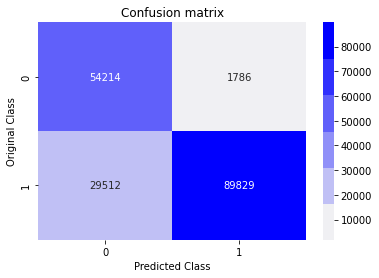

In [178]:
plot_cm(cm_svm)

AUC_SVM:  0.860407883861013


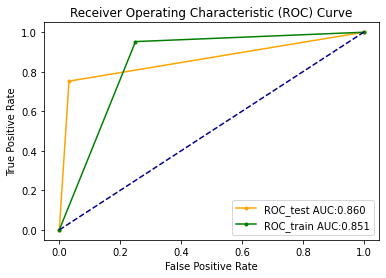

In [179]:
#finding the FPR and TPR for SVM set
fpr_te_svm, tpr_te_svm, t_te_svm = roc_curve(y_test, predict_y_te_svm)
fpr_tr_svm, tpr_tr_svm, t_tr_svm = roc_curve(y_train, predict_y_tr_svm)
auc_te_svm = auc(fpr_te_svm, tpr_te_svm)
print("AUC_SVM: ",auc_te_svm)
plot_roc_curve(fpr_tr_svm,tpr_tr_svm,fpr_te_svm, tpr_te_svm)

## 6.4 Random Forest Model

In [180]:
param_grid = {"n_estimators": [10,100,500,1000, 2000],
    "min_samples_split": [50, 80, 120, 200],
              "max_depth": [3, 5, 10, 50, 100]}
rfc = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1)
gridCV_rfc = GridSearchCV(rfc, param_grid, cv=3, return_train_score=True, verbose=10, n_jobs=-1)
gridCV_rfc.fit(df_train, y_train)
#grid Search cv results are stored in result for future use
results_rfc = pd.DataFrame.from_dict(gridCV_rfc.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 2/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 3/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 1/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 2/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 3/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 1/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 2/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 3/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 1/3; 4/100] START max_depth=3, min_samples_split=50, n_estimators=1000......
[CV 2/3; 4/100] START max_depth=3, min_samples_split=50, n_estimators=1000......
[CV 3/3; 4/100] START max_depth=3, min_samples

In [181]:
results_rfc = results_rfc.sort_values(['rank_test_score'])
results_rfc.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
90,1.491219,0.042077,0.445761,0.072766,100,120,10,"{'max_depth': 100, 'min_samples_split': 120, '...",0.922533,0.941262,0.890359,0.918051,0.021022,1,0.961667,0.959208,0.968481,0.963119,0.003923
70,1.689530,0.304720,0.446192,0.114924,50,120,10,"{'max_depth': 50, 'min_samples_split': 120, 'n...",0.922533,0.941262,0.890359,0.918051,0.021022,1,0.961667,0.959208,0.968481,0.963119,0.003923
84,130.575252,12.464496,8.757074,1.479360,100,50,2000,"{'max_depth': 100, 'min_samples_split': 50, 'n...",0.873998,0.943922,0.899832,0.905918,0.028869,3,0.969265,0.967479,0.974894,0.970546,0.003160
64,131.552431,12.167428,8.802817,1.480828,50,50,2000,"{'max_depth': 50, 'min_samples_split': 50, 'n_...",0.873998,0.943922,0.899832,0.905918,0.028869,3,0.969265,0.967479,0.974894,0.970546,0.003160
62,35.479746,2.921960,2.787588,0.147321,50,50,500,"{'max_depth': 50, 'min_samples_split': 50, 'n_...",0.873670,0.944432,0.898849,0.905650,0.029286,5,0.968991,0.967461,0.974876,0.970443,0.003196


In [182]:
print(gridCV_rfc.best_params_)

{'max_depth': 50, 'min_samples_split': 120, 'n_estimators': 10}


In [183]:
rfc= RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=gridCV_rfc.best_params_['max_depth'],min_samples_split=gridCV_rfc.best_params_['min_samples_split'], n_estimators=gridCV_rfc.best_params_['n_estimators'])
rfc.fit(df_train,y_train)
sig_clf_rfc = CalibratedClassifierCV(rfc, method="sigmoid")
sig_clf_rfc.fit(df_train, y_train)
predict_y_tr_rfc = sig_clf_rfc.predict(df_train)
predict_y_te_rfc = sig_clf_rfc.predict(df_test)
rfc_f1 = f1_score(y_test, predict_y_te_rfc)
print(rfc_f1)

0.9456616181406206


In [184]:
cm_rfc = confusion_matrix(y_test, predict_y_te_rfc)

In [185]:
tn, fp, fn, tp = cm_rfc.ravel()

In [186]:
fpr_rfc = fp/(fp+tn)*100
fnr_rfc = fn/(fn+tp)*100
far_rfc = (fpr_rfc+fnr_rfc)/2
print("far:",far_rfc)

far: 7.445466233015357


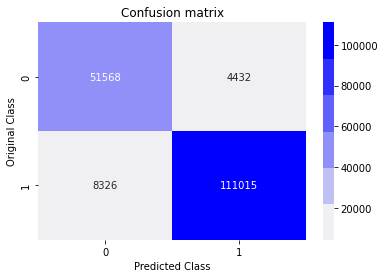

In [187]:
plot_cm(cm_rfc)

AUC_RFC:  0.9255453376698464


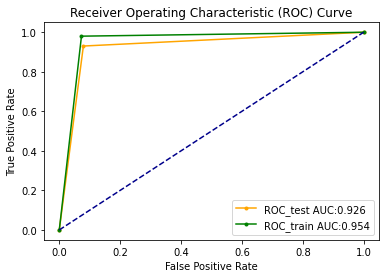

In [188]:
#finding the FPR and TPR for RFC set
fpr_te_rfc, tpr_te_rfc, t_te_rfc = roc_curve(y_test, predict_y_te_rfc)
fpr_tr_rfc, tpr_tr_rfc, t_tr_rfc = roc_curve(y_train, predict_y_tr_rfc)
auc_te_rfc = auc(fpr_te_rfc, tpr_te_rfc)
print("AUC_RFC: ",auc_te_rfc)
plot_roc_curve(fpr_tr_rfc,tpr_tr_rfc,fpr_te_rfc, tpr_te_rfc)

## 6.5 Stacking classifier

In [189]:
clf1 = SGDClassifier(alpha=0.0001,eta0=0.001, penalty='l2', loss='log', n_jobs = -1, max_iter=100)
clf1.fit(df_train, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001,eta0=0.01, penalty='l2', loss='hinge', n_jobs = -1, max_iter=100)
clf2.fit(df_train, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=50,min_samples_split=50, n_estimators=2000)
clf3.fit(df_train, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

In [190]:
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
    sclf.fit(df_train, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log loss: %0.3f F1-score: %0.3f" % (i, log_loss(y_test, sclf.predict_proba(df_test)),f1_score(y_test, sclf.predict(df_test))))
    log_error =log_loss(y_test, sclf.predict_proba(df_test))
    if best_alpha > log_error:
        best_alpha = log_error

/home/pail/miniconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Stacking Classifer : for the value of alpha: 0.000100 Log loss: 0.430 F1-score: 0.919


/home/pail/miniconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Stacking Classifer : for the value of alpha: 0.001000 Log loss: 0.281 F1-score: 0.924


/home/pail/miniconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Stacking Classifer : for the value of alpha: 0.010000 Log loss: 0.243 F1-score: 0.931
Stacking Classifer : for the value of alpha: 0.100000 Log loss: 0.236 F1-score: 0.932


/home/pail/miniconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/pail/miniconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Stacking Classifer : for the value of alpha: 1.000000 Log loss: 0.239 F1-score: 0.932


/home/pail/miniconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Stacking Classifer : for the value of alpha: 10.000000 Log loss: 0.237 F1-score: 0.932


In [191]:
lr = LogisticRegression(C=10)
sig_clf_sc = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
sig_clf_sc.fit(df_train, y_train)
predict_y_tr_sc= sig_clf_sc.predict(df_train)
predict_y_te_sc = sig_clf_sc.predict(df_test)
sc_f1 = f1_score(y_test, predict_y_te_sc)
print(sc_f1)

0.9319840641631719


In [192]:
cm_sc = confusion_matrix(y_test, predict_y_te_sc)

In [193]:
tn, fp, fn, tp = cm_sc.ravel()

In [194]:
fpr_sc = fp/(fp+tn)*100
fnr_sc = fn/(fn+tp)*100
far_sc = (fpr_sc+fnr_sc)/2
print("far:",far_sc)

far: 7.828401903848157


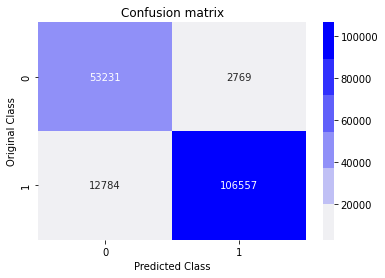

In [195]:
plot_cm(cm_sc)

AUC_SC:  0.9217159809615185


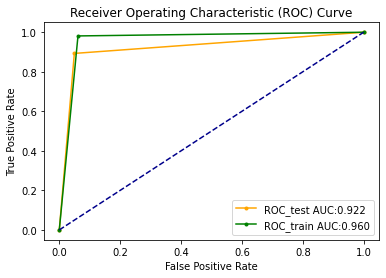

In [196]:
#finding the FPR and TPR for RFC set
fpr_te_sc, tpr_te_sc, t_te_sc = roc_curve(y_test, predict_y_te_sc)
fpr_tr_sc, tpr_tr_sc, t_tr_sc = roc_curve(y_train, predict_y_tr_sc)
auc_te_sc = auc(fpr_te_sc, tpr_te_sc)
print("AUC_SC: ",auc_te_sc)
plot_roc_curve(fpr_tr_sc,tpr_tr_sc,fpr_te_sc, tpr_te_sc)

## 6.6 Model Evaluation

In [197]:
x = PrettyTable()
x.field_names = ["Model", "F1 Score", "ACC","FPR %","FNR %","FAR %"]
x.add_row(["Logistic Regression", "{0:.4}".format(lr_f1), "{0:.4}".format(auc_te_lr),"%.2f" % float(fpr_lr),"%.2f" % float(fnr_lr),"%.2f" % float(far_lr)])
x.add_row(["Linear SVM", "{0:.4}".format(svm_f1), "{0:.4}".format(auc_te_svm),"%.2f" % float(fpr_svm),"%.2f" % float(fnr_svm),"%.2f" % float(far_svm)])
x.add_row(["Random Forest", "{0:.4}".format(rfc_f1), "{0:.4}".format(auc_te_rfc),"%.2f" % float(fpr_rfc),"%.2f" % float(fnr_rfc),"%.2f" % float(far_rfc)])
x.add_row(["Stacking Classifier", "{0:.4}".format(sc_f1), "{0:.4}".format(auc_te_sc),"%.2f" % float(fpr_sc),"%.2f" % float(fnr_sc),"%.2f" % float(far_sc)])
print(x)

+---------------------+----------+--------+-------+-------+-------+
|        Model        | F1 Score |  ACC   | FPR % | FNR % | FAR % |
+---------------------+----------+--------+-------+-------+-------+
| Logistic Regression |  0.8138  | 0.8381 |  1.47 | 30.91 | 16.19 |
|      Linear SVM     |  0.8516  | 0.8604 |  3.19 | 24.73 | 13.96 |
|    Random Forest    |  0.9457  | 0.9255 |  7.91 |  6.98 |  7.45 |
| Stacking Classifier |  0.932   | 0.9217 |  4.94 | 10.71 |  7.83 |
+---------------------+----------+--------+-------+-------+-------+


# 7. Machine Learning Models (One Hot Encoding)

## 7.1 Reading Train and Test data

In [198]:
train_data = pd.read_csv("../idiot/data/UNSW/UNSW_NB15_training-set.csv")
print(train_data.shape)
train_data.head()

(82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [199]:
df_train = train_data[list(col_set)]
df_train.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,state,...,ct_state_ttl,dload,swin,sttl,spkts,tcprtt,sjit,ct_dst_ltm,dttl,proto
0,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,1,0,udp
1,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,1,0,udp
2,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,1,0,udp
3,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,2,0,udp
4,0,0,0,0.0,0.0,0,0,0,0.0,INT,...,2,0.0,0,254,2,0.0,0.0,2,0,udp


In [200]:
cat_features = df_train.select_dtypes(include=['category', object]).columns
cat_features

Index(['state', 'service', 'proto'], dtype='object')

In [201]:
ohe = OneHotEncoder()
cat_f = pd.DataFrame(ohe.fit_transform(train_data[cat_features]).toarray())

In [202]:
cat_f.shape

(82332, 151)

In [203]:
df_train = df_train.drop(cat_features, axis=1)
df_train.shape

(82332, 30)

In [204]:
df_train = df_train.join(cat_f)

In [205]:
df_train.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,dtcpb,...,141,142,143,144,145,146,147,148,149,150
0,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0.0,0.0,0,0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=150).fit_transform(df_train, train_data['label'])

In [207]:
X_new.shape

(82332, 150)

In [208]:
test_data = pd.read_csv("/home/pail/cngvng/UNSW_NB15_full/data/UNSW_NB15_testing-set.csv")
print(test_data.shape)
test_data.head()

(175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [209]:
df_test = test_data[list(col_set)]
df_test.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,state,...,ct_state_ttl,dload,swin,sttl,spkts,tcprtt,sjit,ct_dst_ltm,dttl,proto
0,0,43,0,0.000000,0.000000,0,4,621772692,11.830604,FIN,...,0,8495.365234,255,252,6,0.000000,30.177547,1,254,tcp
1,0,1106,0,0.000000,0.000000,0,38,1417884146,1387.778330,FIN,...,1,503571.312500,255,62,14,0.000000,61.426934,1,252,tcp
2,0,824,0,0.061458,0.050439,0,16,2116150707,11420.926230,FIN,...,1,60929.230470,255,62,8,0.111897,17179.586860,2,252,tcp
3,0,64,0,0.000000,0.000000,0,12,1107119177,4991.784669,FIN,...,1,3358.622070,255,62,12,0.000000,259.080172,2,252,tcp
4,0,45,0,0.071147,0.057234,0,6,2436137549,115.807000,FIN,...,1,3987.059814,255,254,10,0.128381,2415.837634,2,252,tcp


In [210]:
cat_feature = df_test.select_dtypes(include=['category', object]).columns
cat_feature

Index(['state', 'service', 'proto'], dtype='object')

In [211]:
ohe = OneHotEncoder()
cat_f_t = pd.DataFrame(ohe.fit_transform(df_test[cat_feature]).toarray())

In [212]:
cat_f_t.shape

(175341, 155)

In [213]:
df_test = df_test.drop(cat_features, axis=1)
df_test.shape

(175341, 30)

In [214]:
df_test = df_test.join(cat_f_t)

In [215]:
df_test.head()

,trans_depth,dmean,ct_flw_http_mthd,synack,ackdat,response_body_len,dpkts,stcpb,djit,dtcpb,...,145,146,147,148,149,150,151,152,153,154
0,0,43,0,0.000000,0.000000,0,4,621772692,11.830604,2202533631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1106,0,0.000000,0.000000,0,38,1417884146,1387.778330,3077387971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,824,0,0.061458,0.050439,0,16,2116150707,11420.926230,2963114973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,64,0,0.000000,0.000000,0,12,1107119177,4991.784669,1047442890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,45,0,0.071147,0.057234,0,6,2436137549,115.807000,1977154190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
from sklearn.feature_selection import SelectKBest, chi2
X_new_test = SelectKBest(chi2, k=150).fit_transform(df_test, test_data['label'])

In [217]:
X_new_test.shape

(175341, 150)

### 7.1.1 Standardize the data

In [218]:
std_scaler = preprocessing.MinMaxScaler()
std_scaler.fit(X_new)
x_scaled = std_scaler.transform(X_new)
df_train = pd.DataFrame(x_scaled)
x_scaled_test = std_scaler.transform(X_new_test)
df_test = pd.DataFrame(x_scaled_test)

In [219]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
y_train = train_data['label']
y_test = test_data['label']
print("train data shape", df_train.shape, y_train.shape)
print("test data shape", df_test.shape, y_test.shape)

train data shape (82332, 150) (82332,)
test data shape (175341, 150) (175341,)


## 7.2 Logistic Regression Model

In [221]:
prams={
    'alpha':[10 ** x for x in range(-4, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-4, 1)]
}
lr_cfl=GridSearchCV(SGDClassifier(penalty='l2', loss='log', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
lr_cfl.fit(df_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 2/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 3/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 5/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 4/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 4/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 3/5; 1/125] START alpha=0.0001, eta0=0.0001, max_iter=5.....................
[CV 5/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 1/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 2/5; 2/125] START alpha=0.0001, eta0=0.0001, max_iter=10....................
[CV 1/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 2/5; 3/125] START alpha=0.0001, eta0=0.000

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.982 total time=   1.2s
[CV 5/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.775 total time=   1.2s
[CV 4/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................
[CV 5/5; 3/125] START alpha=0.0001, eta0=0.0001, max_iter=20....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.747 total time=   1.5s
[CV 1/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 3/5; 1/125] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.856 total time=   1.6s
[CV 2/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 3/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.863 total time=   1.8s
[CV 4/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.824 total time=   1.8s
[CV 3/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 4/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.971 total time=   1.7s
[CV 2/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.976 total time=   1.2s
[CV 5/5; 4/125] START alpha=0.0001, eta0=0.0001, max_iter=50....................
[CV 1/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 1/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.876 total time=   1.8s
[CV 1/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.829 total time=   2.0s
[CV 2/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 5/5; 2/125] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.796 total time=   2.2s
[CV 3/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 3/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.874 total time=   1.5s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 4/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.731 total time=   1.3s
[CV 5/5; 5/125] START alpha=0.0001, eta0=0.0001, max_iter=100...................
[CV 1/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 5/5; 3/125] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.802 total time=   1.5s
[CV 2/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 3/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.842 total time=   1.1s
[CV 3/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 1/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.904 total time=   1.4s
[CV 4/5; 6/125] START alpha=0.0001, eta0=0.001, max_iter=5......................
[CV 2/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.931 total time=   1.5s
[CV 5/5; 6/125] START alpha=0.0001, eta0=0.001, max_it

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.942 total time=   0.8s
[CV 4/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.781 total time=   0.7s
[CV 5/5; 4/125] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.815 total time=   1.6s
[CV 5/5; 7/125] START alpha=0.0001, eta0=0.001, max_iter=10.....................
[CV 1/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 3/5; 6/125] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.872 total time=   0.8s
[CV 2/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 5/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.820 total time=   1.3s
[CV 3/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 2/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.952 total time=   1.6s
[CV 4/5; 8/125] START alpha=0.0001, eta0=0.001, max_iter=20.....................
[CV 4/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.772 total time=   1.5s
[CV 5/5; 8/125] START alpha=0.0001, eta0=0.0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 5/125] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.850 total time=   1.8s
[CV 2/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.744 total time=   1.1s
[CV 1/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.896 total time=   1.4s
[CV 3/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 4/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 2/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.987 total time=   1.3s
[CV 5/5; 9/125] START alpha=0.0001, eta0=0.001, max_iter=50.....................
[CV 3/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.839 total time=   1.4s
[CV 1/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 5/5; 7/125] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.795 total time=   1.1s
[CV 2/5; 10/125] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 3/5; 8/125] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.875 total time=   1.3s
[CV 1/5; 8/125] END alpha=0.0001, eta0=0.001, max

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.808 total time=   0.8s
[CV 3/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 2/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.944 total time=   0.7s
[CV 4/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 2/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.966 total time=   1.3s
[CV 5/5; 12/125] START alpha=0.0001, eta0=0.01, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.856 total time=   0.8s
[CV 1/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 4/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.655 total time=   0.7s
[CV 2/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 5/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.721 total time=   1.3s
[CV 3/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.906 total time=   1.8s
[CV 5/5; 11/125] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.648 total time=   0.7s
[CV 4/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 5/5; 13/125] START alpha=0.0001, eta0=0.01, max_iter=20.....................
[CV 4/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.695 total time=   1.6s
[CV 1/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 3/5; 10/125] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.849 total time=   1.6s
[CV 2/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.934 total time=   1.2s
[CV 3/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 2/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.984 total time=   1.3s
[CV 4/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 4/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.804 total time=   1.2s
[CV 5/5; 14/125] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 5/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.773 total time=   1.1s
[CV 1/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 12/125] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.863 total time=   1.5s
[CV 2/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 1/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.871 total time=   1.3s
[CV 3/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 5/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.827 total time=   1.2s
[CV 4/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 1/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.931 total time=   1.0s
[CV 5/5; 15/125] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 3/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.869 total time=   1.3s
[CV 1/5; 16/125] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 4/5; 13/125] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.827 total time=   1.4s
[CV 2/5; 13/125] END alpha=0.0001, eta0=0.01, max

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.810 total time=   0.6s
[CV 1/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.844 total time=   0.8s
[CV 2/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 3/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 2/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.938 total time=   0.7s
[CV 2/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.945 total time=   1.2s
[CV 4/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 5/5; 17/125] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 5/5; 14/125] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.795 total time=   1.4s
[CV 1/5; 18/125] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 1/5; 15/125] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.871 total time=   1.5s
[CV 2/5; 18/125] START alpha=0.0001, eta0=0.1, max_it

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 5/5; 16/125] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.708 total time=   0.9s
[CV 2/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.849 total time=   1.2s
[CV 3/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 4/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.658 total time=   1.3s
[CV 4/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 1/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.894 total time=   1.5s
[CV 5/5; 19/125] START alpha=0.0001, eta0=0.1, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.819 total time=   1.4s
[CV 1/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 3/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.853 total time=   1.0s
[CV 2/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 1/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.900 total time=   1.5s
[CV 2/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.958 total time=   1.4s
[CV 3/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................[CV 4/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................

[CV 4/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.677 total time=   1.2s
[CV 5/5; 20/125] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 2/5; 17/125] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.989 total time=   1.8s
[CV 1/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 5/5; 18/125] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.665 total time=   1.5s
[CV 3/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 2/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.966 total time=   1.3s
[CV 4/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.876 total time=   1.3s
[CV 5/5; 21/125] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 1/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.923 total time=   0.8s
[CV 1/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 2/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.922 total time=   0.8s
[CV 2/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 2/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.959 total time=   1.3s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 3/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.872 total time=   0.6s
[CV 4/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 1/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.910 total time=   1.4s
[CV 5/5; 22/125] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 4/5; 19/125] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.693 total time=   1.5s
[CV 4/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.783 total time=   1.2s
[CV 1/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 2/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 4/5; 21/125] END alpha=0.0001, eta0=1, max_iter=5;, score=0.836 total time=   0.8s
[CV 3/5; 23/125] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 3/5; 20/125] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.849 total time=   1.2s
[CV 3/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 2/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.971 total time=   1.3s
[CV 4/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 1/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.867 total time=   1.2s
[CV 5/5; 24/125] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.931 total time=   1.6s
[CV 1/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 2/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.962 total time=   1.3s
[CV 3/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.865 total time=   1.3s[CV 2/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................

[CV 3/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 4/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.795 total time=   1.3s
[CV 5/5; 23/125] END alpha=0.0001, eta0=1, max_iter=20;, score=0.775 total time=   1.0s
[CV 4/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 5/5; 25/125] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 5/5; 22/125] END alpha=0.0001, eta0=1, max_iter=10;, score=0.710 total time=   1.5s
[CV 1/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.903 total time=   1.4s
[CV 3/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 2/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.959 total time=   1.5s
[CV 4/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................
[CV 3/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.869 total time=   1.1s
[CV 5/5; 26/125] START alpha=0.001, eta0=0.0001, max_iter=5.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.805 total time=   1.2s
[CV 1/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.858 total time=   0.8s
[CV 1/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 2/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 2/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.962 total time=   0.8s
[CV 3/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 3/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.834 total time=   0.7s
[CV 4/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 4/5; 26/125] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.630 total time=   0.7s
[CV 5/5; 27/125] START alpha=0.001, eta0=0.0001, max_iter=10....................
[CV 4/5; 24/125] END alpha=0.0001, eta0=1, max_iter=50;, score=0.668 total time=   1.6s
[CV 2/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 25/125] END alpha=0.0001, eta0=1, max_iter=100;, score=0.769 total time=   1.6s
[CV 2/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 2/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.956 total time=   1.0s
[CV 1/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.893 total time=   1.0s
[CV 3/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 4/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 3/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.831 total time=   1.0s
[CV 5/5; 29/125] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 5/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.712 total time=   0.9s
[CV 1/5; 30/125] START alpha=0.001, eta0=0.0001, max_iter=100...................
[CV 4/5; 27/125] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.693 total time=   1.2s
[CV 2/5; 30/125] START alpha=0.001, eta0=0.000

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 30/125] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.634 total time=   1.2s[CV 4/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.637 total time=   0.8s

[CV 3/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.841 total time=   1.0s
[CV 4/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 5/5; 33/125] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 1/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 5/5; 31/125] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.716 total time=   0.8s
[CV 2/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 1/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.860 total time=   1.1s
[CV 3/5; 34/125] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 3/5; 32/125] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.829 total time=   1.0s
[CV 4/5; 34/125] START alpha=0.001, eta0=0.001, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.873 total time=   0.9s
[CV 2/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 2/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.952 total time=   0.9s
[CV 3/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 4/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.632 total time=   0.8s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.831 total time=   0.9s
[CV 4/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 5/5; 38/125] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 5/5; 35/125] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.715 total time=   1.3s
[CV 1/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 1/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.891 total time=   1.0s
[CV 2/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 5/5; 36/125] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.717 total time=   1.1s
[CV 3/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.827 total time=   1.0s
[CV 4/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 4/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.638 total time=   1.0s
[CV 5/5; 39/125] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 2/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.961 total time=   1.4s
[CV 1/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 5/5; 37/125] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.727 total time=   1.1s
[CV 2/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 1/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.898 total time=   1.1s
[CV 3/5; 40/125] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 3/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.863 total time=   1.0s
[CV 2/5; 38/125] END alpha=0.001, eta0=0.01, max_iter=2

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.962 total time=   0.8s
[CV 1/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.871 total time=   1.2s
[CV 1/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 2/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 3/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 4/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.694 total time=   1.1s
[CV 4/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.725 total time=   0.8s
[CV 5/5; 43/125] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 4/5; 41/125] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.638 total time=   0.9s
[CV 1/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 5/5; 40/125] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.732 total time=   1.6s
[CV 2/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 3/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.829 total time=   1.0s
[CV 2/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.964 total time=   1.1s
[CV 3/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 4/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 1/5; 42/125] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.863 total time=   1.2s
[CV 5/5; 44/125] START alpha=0.001, eta0=0.1, max_iter=50....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.952 total time=   0.7s
[CV 1/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.892 total time=   1.1s
[CV 4/5; 44/125] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.640 total time=   1.1s
[CV 5/5; 46/125] START alpha=0.001, eta0=1, max_iter=5..........................
[CV 1/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 1/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.857 total time=   0.7s
[CV 2/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 2/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.965 total time=   1.0s
[CV 3/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 3/5; 45/125] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.830 total time=   0.9s
[CV 5/5; 47/125] START alpha=0.001, eta0=1, max_iter=10.........................[CV 4/5; 47/125] START alpha=0.001, eta0=1, max_iter=10..........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.644 total time=   0.9s
[CV 1/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 46/125] END alpha=0.001, eta0=1, max_iter=5;, score=0.719 total time=   0.9s
[CV 2/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 1/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.901 total time=   1.1s
[CV 4/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.635 total time=   1.1s
[CV 3/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 4/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 3/5; 47/125] END alpha=0.001, eta0=1, max_iter=10;, score=0.831 total time=   1.2s
[CV 5/5; 49/125] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 1/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.868 total time=   1.2s
[CV 1/5; 50/125] START alpha=0.001, eta0=1, max_iter=100........................
[CV 2/5; 48/125] END alpha=0.001, eta0=1, max_iter=20;, score=0.955 total time=   1.2s
[CV 2/5; 50/125] START alpha=0.001, eta0=1, max_iter=100..................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.878 total time=   0.8s
[CV 1/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 3/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.823 total time=   1.1s
[CV 2/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 5/5; 49/125] END alpha=0.001, eta0=1, max_iter=50;, score=0.715 total time=   1.1s
[CV 3/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 2/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.938 total time=   0.7s
[CV 4/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.805 total time=   0.8s
[CV 5/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.716 total time=   1.0s
[CV 5/5; 52/125] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 1/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 1/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.889 total time=   1.3s
[CV 2/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.950 total time=   1.3s
[CV 2/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 3/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.617 total time=   0.7s
[CV 4/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 3/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.832 total time=   1.4s
[CV 5/5; 53/125] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 4/5; 50/125] END alpha=0.001, eta0=1, max_iter=100;, score=0.738 total time=   1.5s
[CV 1/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 51/125] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.686 total time=   0.8s
[CV 2/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 3/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.801 total time=   1.0s
[CV 3/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 5/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.686 total time=   1.0s
[CV 4/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 2/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.940 total time=   1.2s
[CV 1/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.885 total time=   1.2s
[CV 5/5; 54/125] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 1/5; 55/125] START alpha=0.01, eta0=0.0001, max_iter=100....................
[CV 4/5; 52/125] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.617 total time=   1.2s
[CV 2/5; 55/125] START alpha=0.01, eta0=0.0001, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 5/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.678 total time=   1.0s[CV 1/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.884 total time=   0.7s

[CV 3/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 4/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 2/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.953 total time=   0.7s
[CV 2/5; 55/125] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.940 total time=   1.2s
[CV 5/5; 54/125] END alpha=0.01, eta0=0.0001, max_iter=50;, score=0.686 total time=   1.3s
[CV 5/5; 57/125] START alpha=0.01, eta0=0.001, max_iter=10......................
[CV 1/5; 58/125] START alpha=0.01, eta0=0.001, max_iter=20......................
[CV 4/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.617 total time=   0.7s
[CV 3/5; 56/125] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.805 total time=   0.7s
[CV 2/5; 58/125] START alpha=0.01, eta0=0.001

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.617 total time=   1.1s
[CV 1/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 4/5; 59/125] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.617 total time=   1.3s
[CV 4/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.617 total time=   0.8s
[CV 2/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 3/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.800 total time=   1.2s
[CV 3/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 4/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................
[CV 5/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.685 total time=   1.2s
[CV 5/5; 63/125] START alpha=0.01, eta0=0.01, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 60/125] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.948 total time=   1.3s
[CV 1/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 5/5; 61/125] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.683 total time=   0.9s

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



[CV 2/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 1/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.884 total time=   1.2s
[CV 4/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.617 total time=   1.0s
[CV 2/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.947 total time=   1.1s
[CV 3/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 4/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 5/5; 64/125] START alpha=0.01, eta0=0.01, max_iter=50.......................
[CV 4/5; 63/125] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.617 total time=   0.9s
[CV 1/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 3/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.800 total time=   1.2s
[CV 2/5; 65/125] START alpha=0.01, eta0=0.01, max_iter=100......................
[CV 5/5; 62/125] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.68

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.686 total time=   1.0s
[CV 3/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.807 total time=   1.0s
[CV 4/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................
[CV 3/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.800 total time=   0.7s
[CV 1/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.881 total time=   0.8s
[CV 1/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 5/5; 67/125] START alpha=0.01, eta0=0.1, max_iter=10........................
[CV 2/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 3/5; 64/125] END alpha=0.01, eta0=0.01, max_iter=50;, score=0.800 total time=   1.4s

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



[CV 2/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.939 total time=   0.9s
[CV 4/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.617 total time=   0.9s
[CV 3/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 5/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 4/5; 68/125] START alpha=0.01, eta0=0.1, max_iter=20........................
[CV 4/5; 65/125] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.617 total time=   1.3s
[CV 1/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 66/125] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.686 total time=   0.8s
[CV 2/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 2/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.938 total time=   1.0s
[CV 3/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 4/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.617 total time=   1.0s
[CV 1/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.876 total time=   1.1s
[CV 4/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 3/5; 67/125] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.800 total time=   1.1s
[CV 5/5; 69/125] START alpha=0.01, eta0=0.1, max_iter=50........................
[CV 1/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100.......................
[CV 2/5; 68/125] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.943 total time=   1.1s
[CV 2/5; 70/125] START alpha=0.01, eta0=0.1, max_iter=100...........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 3/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.805 total time=   0.7s
[CV 5/5; 72/125] START alpha=0.01, eta0=1, max_iter=10..........................
[CV 4/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.617 total time=   0.7s
[CV 4/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.617 total time=   1.1s[CV 3/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.800 total time=   1.1s

[CV 2/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 3/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................[CV 1/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................

[CV 2/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.941 total time=   0.9s
[CV 4/5; 73/125] START alpha=0.01, eta0=1, max_iter=20..........................
[CV 2/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.940 total time=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 70/125] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.686 total time=   1.3s
[CV 1/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 71/125] END alpha=0.01, eta0=1, max_iter=5;, score=0.686 total time=   0.9s
[CV 2/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 2/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.947 total time=   1.1s
[CV 1/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.876 total time=   1.1s
[CV 3/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 4/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 5/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.686 total time=   0.9s
[CV 5/5; 74/125] START alpha=0.01, eta0=1, max_iter=50..........................
[CV 3/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.800 total time=   1.2s
[CV 1/5; 75/125] START alpha=0.01, eta0=1, max_iter=100.........................
[CV 4/5; 72/125] END alpha=0.01, eta0=1, max_iter=10;, score=0.617 total time=   1.1s
[CV 1/5; 73/125] END alpha=0.01, eta0=1, max_iter=20;, score=0.867 total time=  

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.750 total time=   0.9s
[CV 2/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 4/5; 75/125] END alpha=0.01, eta0=1, max_iter=100;, score=0.617 total time=   1.2s
[CV 3/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................
[CV 2/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.807 total time=   0.9s
[CV 4/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.723 total time=   1.0s
[CV 4/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.745 total time=   0.9s
[CV 1/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 5/5; 78/125] START alpha=0.1, eta0=0.0001, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 76/125] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.707 total time=   0.9s
[CV 2/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 5/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.707 total time=   0.9s
[CV 3/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 1/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.748 total time=   1.0s
[CV 4/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................
[CV 2/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.807 total time=   1.1s
[CV 4/5; 77/125] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.745 total time=   1.0s
[CV 5/5; 79/125] START alpha=0.1, eta0=0.0001, max_iter=50......................[CV 1/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=100.....................

[CV 2/5; 78/125] END alpha=0.1, eta0=0.0001, max_iter=20;, score=0.807 total time=   0.9s
[CV 2/5; 80/125] START alpha=0.1, eta0=0.0001, max_iter=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



[CV 3/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 4/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.745 total time=   1.0s
[CV 3/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.723 total time=   1.0s
[CV 4/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 83/125] START alpha=0.1, eta0=0.001, max_iter=20.......................
[CV 5/5; 80/125] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.707 total time=   1.3s
[CV 1/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 81/125] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.707 total time=   1.0s
[CV 2/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 1/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.752 total time=   1.0s
[CV 2/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.807 total time=   1.0s
[CV 3/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 4/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 5/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.707 total time=   0.9s
[CV 3/5; 82/125] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.723 total time=   1.0s
[CV 5/5; 84/125] START alpha=0.1, eta0=0.001, max_iter=50.......................
[CV 1/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100......................
[CV 1/5; 83/125] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.754 total time=   1.0s
[CV 2/5; 85/125] START alpha=0.1, eta0=0.001, max_iter=100....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 2/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.807 total time=   1.0s
[CV 3/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 5/5; 85/125] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.707 total time=   1.2s
[CV 4/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 4/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.745 total time=   0.8s
[CV 5/5; 88/125] START alpha=0.1, eta0=0.01, max_iter=20........................
[CV 5/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.707 total time=   0.9s
[CV 1/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 2/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.807 total time=   0.9s
[CV 2/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 86/125] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.723 total time=   1.1s
[CV 3/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 3/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.723 total time=   1.0s
[CV 4/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 5/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.707 total time=   0.9s
[CV 5/5; 89/125] START alpha=0.1, eta0=0.01, max_iter=50........................
[CV 4/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.745 total time=   1.0s
[CV 1/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 1/5; 87/125] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.752 total time=   1.3s
[CV 2/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100.......................
[CV 1/5; 88/125] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.747 total time=   0.9s
[CV 3/5; 90/125] START alpha=0.1, eta0=0.01, max_iter=100...........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 1/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.749 total time=   1.0s
[CV 4/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 4/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.745 total time=   0.9s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 93/125] START alpha=0.1, eta0=0.1, max_iter=20.........................
[CV 2/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.807 total time=   1.1s
[CV 1/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 5/5; 91/125] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.707 total time=   1.0s
[CV 2/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 1/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.752 total time=   1.0s
[CV 3/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 3/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.723 total time=   0.9s
[CV 4/5; 92/125] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.745 total time=   0.9s
[CV 4/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 5/5; 94/125] START alpha=0.1, eta0=0.1, max_iter=50.........................
[CV 1/5; 93/125] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.751 total time=  

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.745 total time=   0.7s
[CV 3/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.723 total time=   0.8s
[CV 4/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 5/5; 98/125] START alpha=0.1, eta0=1, max_iter=20...........................
[CV 3/5; 95/125] END alpha=0.1, eta0=0.1, max_iter=100;, score=0.723 total time=   1.3s
[CV 1/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 1/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.752 total time=   0.9s
[CV 2/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 5/5; 96/125] END alpha=0.1, eta0=1, max_iter=5;, score=0.707 total time=   1.0s
[CV 3/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 2/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.807 total time=   0.9s
[CV 4/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.723 total time=   1.0s
[CV 5/5; 99/125] START alpha=0.1, eta0=1, max_iter=50...........................
[CV 4/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.745 total time=   1.0s
[CV 1/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 4/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.745 total time=   0.8s[CV 2/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.807 total time=   1.0s

[CV 2/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 3/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 5/5; 97/125] END alpha=0.1, eta0=1, max_iter=10;, score=0.707 total time=   1.2s
[CV 4/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 1/5; 98/125] END alpha=0.1, eta0=1, max_iter=20;, score=0.748 total time=   1.2s
[CV 5/5; 100/125] START alpha=0.1, eta0=1, max_iter=100.........................
[CV 

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 2/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.740 total time=   0.8s
[CV 4/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.745 total time=   0.9s
[CV 3/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 2/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 1/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.669 total time=   0.9s
[CV 5/5; 100/125] END alpha=0.1, eta0=1, max_iter=100;, score=0.707 total time=   1.0s
[CV 4/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 5/5; 103/125] START alpha=1, eta0=0.0001, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.568 total time=   1.1s
[CV 1/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 2/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.744 total time=   0.8s
[CV 2/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 5/5; 101/125] END alpha=1, eta0=0.0001, max_iter=5;, score=0.673 total time=   1.0s
[CV 3/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 1/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.664 total time=   1.2s
[CV 4/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 3/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.663 total time=   1.0s
[CV 5/5; 104/125] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 5/5; 102/125] END alpha=1, eta0=0.0001, max_iter=10;, score=0.586 total time=   1.0s
[CV 1/5; 105/125] START alpha=1, eta0=0.0001, max_iter=100.....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.522 total time=   0.9s
[CV 1/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 4/5; 106/125] END alpha=1, eta0=0.001, max_iter=5;, score=0.632 total time=   1.0s
[CV 2/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 1/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.697 total time=   1.0s
[CV 3/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.656 total time=   0.9s
[CV 4/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 2/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.768 total time=   1.0s
[CV 5/5; 109/125] START alpha=1, eta0=0.001, max_iter=50........................
[CV 4/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.705 total time=   1.1s
[CV 1/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 2/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.746 total time=   0.8s
[CV 2/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 5/5; 107/125] END alpha=1, eta0=0.001, max_iter=10;, score=0.679 total time=   1.1s
[CV 3/5; 110/125] START alpha=1, eta0=0.001, max_iter=100.......................
[CV 5/5; 108/125] END alpha=1, eta0=0.001, max_iter=20;, score=0.655 total time=   0.8s
[CV 4/5; 110/125] START alpha=1, eta0=0.001, max_iter=100..........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python


[CV 3/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.676 total time=   0.9s
[CV 4/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 5/5; 113/125] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 5/5; 111/125] END alpha=1, eta0=0.01, max_iter=5;, score=0.616 total time=   0.7s
[CV 1/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 2/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 2/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.766 total time=   1.0s
[CV 3/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 3/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.677 total time=   0.9s
[CV 4/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 1/5; 112/125] END alpha=1, eta0=0.01, max_iter=10;, score=0.665 total time=   1.2s
[CV 5/5; 114/125] START alpha=1, eta0=0.01, max_iter=50.........................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.715 total time=   0.8s
[CV 2/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 5/5; 115/125] END alpha=1, eta0=0.01, max_iter=100;, score=0.534 total time=   0.9s
[CV 3/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 1/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.660 total time=   0.9s
[CV 4/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.693 total time=   0.9s
[CV 5/5; 118/125] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 3/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.661 total time=   1.1s
[CV 1/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 2/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.756 total time=   0.9s
[CV 2/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 5/5; 116/125] END alpha=1, eta0=0.1, max_iter=5;, score=0.550 total time=   1.1s
[CV 3/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 1/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.662 total time=   1.1s
[CV 4/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.665 total time=   0.8s
[CV 5/5; 119/125] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 3/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.677 total time=   1.1s
[CV 2/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.767 total time=   0.8s
[CV 1/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 2/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 4/5; 117/125] END alpha=1, eta0=0.1, max_iter=10;, score=0.645 total time=   1.0s
[CV 3/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 1/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.660 total time=   1.1s
[CV 5/5; 118/125] END alpha=1, eta0=0.1, max_iter=20;, score=0.600 total time=   0.8s
[CV 4/5; 120/125] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 5/5; 120/125] START alpha=1, eta0=0.1, max_iter=100........................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 120/125] END alpha=1, eta0=0.1, max_iter=100;, score=0.681 total time=   1.0s
[CV 4/5; 123/125] START alpha=1, eta0=1, max_iter=20............................
[CV 3/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.670 total time=   1.0s
[CV 5/5; 123/125] START alpha=1, eta0=1, max_iter=20............................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.677 total time=   0.8s
[CV 1/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 4/5; 121/125] END alpha=1, eta0=1, max_iter=5;, score=0.712 total time=   1.1s
[CV 2/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 1/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.660 total time=   1.0s
[CV 3/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 2/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.740 total time=   1.0s
[CV 4/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 3/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.649 total time=   1.0s
[CV 5/5; 124/125] START alpha=1, eta0=1, max_iter=50............................
[CV 5/5; 122/125] END alpha=1, eta0=1, max_iter=10;, score=0.550 total time=   1.0s
[CV 1/5; 125/125] START alpha=1, eta0=1, max_iter=100...........................
[CV 3/5; 123

GridSearchCV(estimator=SGDClassifier(loss='log', n_jobs=-1), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [222]:
results = pd.DataFrame.from_dict(lr_cfl.cv_results_)
results = results.sort_values(['rank_test_score'])
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta0,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,1.248764,0.104616,0.016029,0.004379,0.0001,0.01,10,"{'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 10}",0.933928,0.984029,0.862626,0.803717,0.772501,0.871360,0.078783,1
12,1.344050,0.135031,0.017911,0.006071,0.0001,0.01,20,"{'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 20}",0.871197,0.961134,0.869064,0.826916,0.827402,0.871143,0.048933,2
24,1.490920,0.124814,0.022548,0.010044,0.0001,1,100,"{'alpha': 0.0001, 'eta0': 1, 'max_iter': 100}",0.937208,0.972248,0.876230,0.769404,0.800316,0.871081,0.077434,3
20,0.736072,0.056489,0.019091,0.004378,0.0001,1,5,"{'alpha': 0.0001, 'eta0': 1, 'max_iter': 5}",0.923180,0.921965,0.872343,0.836329,0.794243,0.869612,0.049812,4
19,1.336357,0.120240,0.026650,0.008000,0.0001,0.1,100,"{'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 100}",0.909698,0.959434,0.878781,0.783190,0.802502,0.866721,0.065863,5


In [223]:
print(lr_cfl.best_params_)

{'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 10}


In [224]:
logisticR=SGDClassifier(alpha=lr_cfl.best_params_['alpha'],eta0=lr_cfl.best_params_['eta0'], penalty='l2', loss='log', n_jobs = -1, max_iter=lr_cfl.best_params_['max_iter'])
logisticR.fit(df_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(df_train, y_train)
predict_y_tr_lr = sig_clf.predict(df_train)
predict_y_te_lr = sig_clf.predict(df_test)
lr_f1 = f1_score(y_test, predict_y_te_lr)
print(lr_f1)

0.9305521280137885


In [225]:
cm_lr = confusion_matrix(y_test, predict_y_te_lr)

In [226]:
tn, fp, fn, tp = cm_lr.ravel()

In [227]:
fpr_lr = (fp/(fp+tn))*100
fnr_lr = (fn/(fn+tp))*100
far_lr = (fpr_lr+fnr_lr)/2
print("FAR:",far_lr)

FAR: 15.562664414816128


In [228]:
def plot_cm(cm):
    sns.heatmap(cm, annot=True, cmap=sns.light_palette("blue"), fmt="g")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

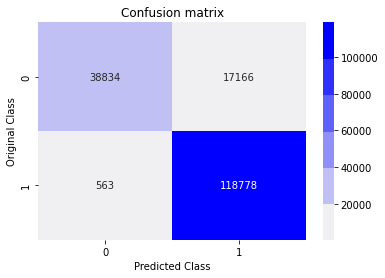

In [229]:
plot_cm(cm_lr)

In [230]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(fpr_tr, tpr_tr,fpr_te, tpr_te):
    '''
    plot the ROC curve for the FPR and TPR value
    '''
    plt.plot(fpr_te, tpr_te, 'k.-', color='orange', label='ROC_test AUC:%.3f'% auc(fpr_te, tpr_te))
    plt.plot(fpr_tr, tpr_tr, 'k.-', color='green', label='ROC_train AUC:%.3f'% auc(fpr_tr, tpr_tr))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC_LR:  0.8443733558518387


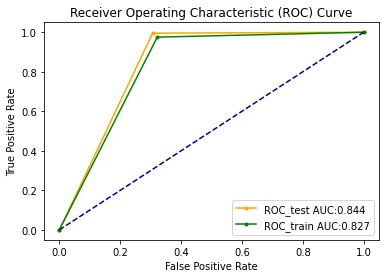

In [231]:
#finding the FPR and TPR for logistic reg model set
fpr_te_lr, tpr_te_lr, t_te_lr = roc_curve(y_test, predict_y_te_lr)
fpr_tr_lr, tpr_tr_lr, t_tr_lr = roc_curve(y_train, predict_y_tr_lr)
auc_te_lr = auc(fpr_te_lr, tpr_te_lr)
print("AUC_LR: ",auc_te_lr)
plot_roc_curve(fpr_tr_lr,tpr_tr_lr,fpr_te_lr, tpr_te_lr)

## 7.3 Support Vector Machine Model

In [232]:
prams={
    'alpha':[10 ** x for x in range(-5, 1)],
     'max_iter':[5, 10, 20, 50, 100],
    'eta0': [10 ** x for x in range(-5, 1)]
}
svm_cfl=GridSearchCV(SGDClassifier(penalty='l2', loss='hinge', n_jobs = -1), param_grid=prams,verbose=10,n_jobs=-1)
svm_cfl.fit(df_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5; 1/180] START alpha=1e-05, eta0=1e-05, max_iter=5.......................
[CV 2/5; 1/180] START alpha=1e-05, eta0=1e-05, max_iter=5.......................
[CV 3/5; 1/180] START alpha=1e-05, eta0=1e-05, max_iter=5.......................
[CV 4/5; 1/180] START alpha=1e-05, eta0=1e-05, max_iter=5.......................
[CV 5/5; 1/180] START alpha=1e-05, eta0=1e-05, max_iter=5.......................
[CV 1/5; 2/180] START alpha=1e-05, eta0=1e-05, max_iter=10......................
[CV 2/5; 2/180] START alpha=1e-05, eta0=1e-05, max_iter=10......................
[CV 3/5; 2/180] START alpha=1e-05, eta0=1e-05, max_iter=10......................
[CV 4/5; 2/180] START alpha=1e-05, eta0=1e-05, max_iter=10......................
[CV 5/5; 2/180] START alpha=1e-05, eta0=1e-05, max_iter=10......................
[CV 1/5; 3/180] START alpha=1e-05, eta0=1e-05, max_iter=20......................
[CV 2/5; 3/180] START alpha=1e-05, eta0=1e-05,

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 1/180] END alpha=1e-05, eta0=1e-05, max_iter=5;, score=0.987 total time=   0.9s
[CV 4/5; 1/180] END alpha=1e-05, eta0=1e-05, max_iter=5;, score=0.693 total time=   0.9s
[CV 3/5; 3/180] START alpha=1e-05, eta0=1e-05, max_iter=20......................
[CV 4/5; 3/180] START alpha=1e-05, eta0=1e-05, max_iter=20......................
[CV 3/5; 1/180] END alpha=1e-05, eta0=1e-05, max_iter=5;, score=0.856 total time=   1.0s
[CV 1/5; 1/180] END alpha=1e-05, eta0=1e-05, max_iter=5;, score=0.835 total time=   1.0s
[CV 1/5; 4/180] START alpha=1e-05, eta0=1e-05, max_iter=50......................
[CV 5/5; 3/180] START alpha=1e-05, eta0=1e-05, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 1/180] END alpha=1e-05, eta0=1e-05, max_iter=5;, score=0.820 total time=   1.2s
[CV 2/5; 4/180] START alpha=1e-05, eta0=1e-05, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 2/180] END alpha=1e-05, eta0=1e-05, max_iter=10;, score=0.795 total time=   1.5s
[CV 3/5; 4/180] START alpha=1e-05, eta0=1e-05, max_iter=50......................
[CV 1/5; 2/180] END alpha=1e-05, eta0=1e-05, max_iter=10;, score=0.813 total time=   1.6s
[CV 4/5; 2/180] END alpha=1e-05, eta0=1e-05, max_iter=10;, score=0.694 total time=   1.5s
[CV 4/5; 4/180] START alpha=1e-05, eta0=1e-05, max_iter=50......................
[CV 5/5; 4/180] START alpha=1e-05, eta0=1e-05, max_iter=50......................
[CV 2/5; 2/180] END alpha=1e-05, eta0=1e-05, max_iter=10;, score=0.895 total time=   1.6s
[CV 1/5; 5/180] START alpha=1e-05, eta0=1e-05, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 2/180] END alpha=1e-05, eta0=1e-05, max_iter=10;, score=0.859 total time=   1.8s
[CV 2/5; 5/180] START alpha=1e-05, eta0=1e-05, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 3/180] END alpha=1e-05, eta0=1e-05, max_iter=20;, score=0.934 total time=   2.2s
[CV 3/5; 5/180] START alpha=1e-05, eta0=1e-05, max_iter=100.....................
[CV 2/5; 3/180] END alpha=1e-05, eta0=1e-05, max_iter=20;, score=0.986 total time=   2.4s
[CV 4/5; 5/180] START alpha=1e-05, eta0=1e-05, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 3/180] END alpha=1e-05, eta0=1e-05, max_iter=20;, score=0.870 total time=   1.9s
[CV 5/5; 5/180] START alpha=1e-05, eta0=1e-05, max_iter=100.....................
[CV 5/5; 3/180] END alpha=1e-05, eta0=1e-05, max_iter=20;, score=0.732 total time=   1.9s
[CV 1/5; 6/180] START alpha=1e-05, eta0=0.0001, max_iter=5......................
[CV 4/5; 3/180] END alpha=1e-05, eta0=1e-05, max_iter=20;, score=0.808 total time=   2.0s
[CV 2/5; 6/180] START alpha=1e-05, eta0=0.0001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 6/180] END alpha=1e-05, eta0=0.0001, max_iter=5;, score=0.960 total time=   0.6s
[CV 3/5; 6/180] START alpha=1e-05, eta0=0.0001, max_iter=5......................
[CV 1/5; 6/180] END alpha=1e-05, eta0=0.0001, max_iter=5;, score=0.915 total time=   0.7s
[CV 4/5; 6/180] START alpha=1e-05, eta0=0.0001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 6/180] END alpha=1e-05, eta0=0.0001, max_iter=5;, score=0.850 total time=   0.6s
[CV 5/5; 6/180] START alpha=1e-05, eta0=0.0001, max_iter=5......................
[CV 3/5; 6/180] END alpha=1e-05, eta0=0.0001, max_iter=5;, score=0.827 total time=   0.6s
[CV 1/5; 7/180] START alpha=1e-05, eta0=0.0001, max_iter=10.....................
[CV 1/5; 4/180] END alpha=1e-05, eta0=1e-05, max_iter=50;, score=0.912 total time=   3.6s
[CV 2/5; 7/180] START alpha=1e-05, eta0=0.0001, max_iter=10.....................
[CV 4/5; 4/180] END alpha=1e-05, eta0=1e-05, max_iter=50;, score=0.862 total time=   3.1s
[CV 3/5; 7/180] START alpha=1e-05, eta0=0.0001, max_iter=10.....................
[CV 3/5; 5/180] END alpha=1e-05, eta0=1e-05, max_iter=100;, score=0.857 total time=   2.4s
[CV 4/5; 7/180] START alpha=1e-05, eta0=0.0001, max_iter=10.....................
[CV 5/5; 6/180] END alpha=1e-05, eta0=0.0001, max_iter=5;, score=0.789 total time=   0.7s
[CV 5/5; 7/180] START alpha=1e-05, eta0=0.0001, max_it

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 5/180] END alpha=1e-05, eta0=1e-05, max_iter=100;, score=0.925 total time=   3.6s
[CV 2/5; 8/180] START alpha=1e-05, eta0=0.0001, max_iter=20.....................
[CV 3/5; 4/180] END alpha=1e-05, eta0=1e-05, max_iter=50;, score=0.877 total time=   3.8s
[CV 3/5; 8/180] START alpha=1e-05, eta0=0.0001, max_iter=20.....................
[CV 1/5; 7/180] END alpha=1e-05, eta0=0.0001, max_iter=10;, score=0.942 total time=   1.1s
[CV 4/5; 5/180] END alpha=1e-05, eta0=1e-05, max_iter=100;, score=0.720 total time=   2.8s
[CV 4/5; 8/180] START alpha=1e-05, eta0=0.0001, max_iter=20.....................
[CV 5/5; 8/180] START alpha=1e-05, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 4/180] END alpha=1e-05, eta0=1e-05, max_iter=50;, score=0.843 total time=   4.0s
[CV 1/5; 9/180] START alpha=1e-05, eta0=0.0001, max_iter=50.....................
[CV 2/5; 7/180] END alpha=1e-05, eta0=0.0001, max_iter=10;, score=0.928 total time=   1.2s
[CV 5/5; 5/180] END alpha=1e-05, eta0=1e-05, max_iter=100;, score=0.863 total time=   3.0s
[CV 2/5; 9/180] START alpha=1e-05, eta0=0.0001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 9/180] START alpha=1e-05, eta0=0.0001, max_iter=50.....................
[CV 3/5; 7/180] END alpha=1e-05, eta0=0.0001, max_iter=10;, score=0.805 total time=   1.2s
[CV 4/5; 9/180] START alpha=1e-05, eta0=0.0001, max_iter=50.....................
[CV 4/5; 7/180] END alpha=1e-05, eta0=0.0001, max_iter=10;, score=0.719 total time=   1.1s
[CV 5/5; 9/180] START alpha=1e-05, eta0=0.0001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 4/180] END alpha=1e-05, eta0=1e-05, max_iter=50;, score=0.931 total time=   5.1s
[CV 1/5; 10/180] START alpha=1e-05, eta0=0.0001, max_iter=100...................
[CV 5/5; 7/180] END alpha=1e-05, eta0=0.0001, max_iter=10;, score=0.785 total time=   1.3s
[CV 2/5; 10/180] START alpha=1e-05, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 8/180] END alpha=1e-05, eta0=0.0001, max_iter=20;, score=0.929 total time=   1.9s
[CV 3/5; 10/180] START alpha=1e-05, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 8/180] END alpha=1e-05, eta0=0.0001, max_iter=20;, score=0.846 total time=   1.8s
[CV 4/5; 10/180] START alpha=1e-05, eta0=0.0001, max_iter=100...................
[CV 2/5; 8/180] END alpha=1e-05, eta0=0.0001, max_iter=20;, score=0.989 total time=   2.0s
[CV 5/5; 10/180] START alpha=1e-05, eta0=0.0001, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 8/180] END alpha=1e-05, eta0=0.0001, max_iter=20;, score=0.809 total time=   2.0s
[CV 3/5; 8/180] END alpha=1e-05, eta0=0.0001, max_iter=20;, score=0.845 total time=   2.1s
[CV 1/5; 11/180] START alpha=1e-05, eta0=0.001, max_iter=5......................
[CV 2/5; 11/180] START alpha=1e-05, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 11/180] END alpha=1e-05, eta0=0.001, max_iter=5;, score=0.923 total time=   0.6s
[CV 3/5; 11/180] START alpha=1e-05, eta0=0.001, max_iter=5......................
[CV 1/5; 11/180] END alpha=1e-05, eta0=0.001, max_iter=5;, score=0.936 total time=   0.7s
[CV 4/5; 11/180] START alpha=1e-05, eta0=0.001, max_iter=5......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 11/180] END alpha=1e-05, eta0=0.001, max_iter=5;, score=0.843 total time=   0.6s
[CV 5/5; 11/180] START alpha=1e-05, eta0=0.001, max_iter=5......................
[CV 4/5; 11/180] END alpha=1e-05, eta0=0.001, max_iter=5;, score=0.718 total time=   0.6s
[CV 1/5; 12/180] START alpha=1e-05, eta0=0.001, max_iter=10.....................
[CV 3/5; 9/180] END alpha=1e-05, eta0=0.0001, max_iter=50;, score=0.884 total time=   3.0s
[CV 2/5; 12/180] START alpha=1e-05, eta0=0.001, max_iter=10.....................
[CV 2/5; 9/180] END alpha=1e-05, eta0=0.0001, max_iter=50;, score=0.960 total time=   3.4s
[CV 3/5; 12/180] START alpha=1e-05, eta0=0.001, max_iter=10.....................
[CV 5/5; 11/180] END alpha=1e-05, eta0=0.001, max_iter=5;, score=0.707 total time=   0.6s
[CV 4/5; 12/180] START alpha=1e-05, eta0=0.001, max_iter=10.....................
[CV 1/5; 10/180] END alpha=1e-05, eta0=0.0001, max_iter=100;, score=0.874 total time=   3.0s
[CV 5/5; 12/180] START alpha=1e-05, eta0=0.001, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 9/180] END alpha=1e-05, eta0=0.0001, max_iter=50;, score=0.927 total time=   3.9s
[CV 1/5; 13/180] START alpha=1e-05, eta0=0.001, max_iter=20.....................
[CV 5/5; 9/180] END alpha=1e-05, eta0=0.0001, max_iter=50;, score=0.815 total time=   3.6s
[CV 2/5; 13/180] START alpha=1e-05, eta0=0.001, max_iter=20.....................
[CV 3/5; 10/180] END alpha=1e-05, eta0=0.0001, max_iter=100;, score=0.859 total time=   2.8s
[CV 3/5; 13/180] START alpha=1e-05, eta0=0.001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 12/180] END alpha=1e-05, eta0=0.001, max_iter=10;, score=0.946 total time=   1.0s
[CV 4/5; 13/180] START alpha=1e-05, eta0=0.001, max_iter=20.....................
[CV 1/5; 12/180] END alpha=1e-05, eta0=0.001, max_iter=10;, score=0.913 total time=   1.2s
[CV 5/5; 13/180] START alpha=1e-05, eta0=0.001, max_iter=20.....................
[CV 4/5; 9/180] END alpha=1e-05, eta0=0.0001, max_iter=50;, score=0.706 total time=   4.2s
[CV 1/5; 14/180] START alpha=1e-05, eta0=0.001, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 12/180] END alpha=1e-05, eta0=0.001, max_iter=10;, score=0.689 total time=   1.1s
[CV 2/5; 14/180] START alpha=1e-05, eta0=0.001, max_iter=50.....................
[CV 4/5; 12/180] END alpha=1e-05, eta0=0.001, max_iter=10;, score=0.827 total time=   1.2s
[CV 3/5; 14/180] START alpha=1e-05, eta0=0.001, max_iter=50.....................
[CV 3/5; 12/180] END alpha=1e-05, eta0=0.001, max_iter=10;, score=0.888 total time=   1.3s
[CV 4/5; 14/180] START alpha=1e-05, eta0=0.001, max_iter=50.....................
[CV 4/5; 10/180] END alpha=1e-05, eta0=0.0001, max_iter=100;, score=0.857 total time=   3.8s
[CV 5/5; 14/180] START alpha=1e-05, eta0=0.001, max_iter=50.....................
[CV 2/5; 10/180] END alpha=1e-05, eta0=0.0001, max_iter=100;, score=0.982 total time=   4.8s
[CV 1/5; 15/180] START alpha=1e-05, eta0=0.001, max_iter=100....................
[CV 5/5; 10/180] END alpha=1e-05, eta0=0.0001, max_iter=100;, score=0.736 total time=   4.1s
[CV 2/5; 15/180] START alpha=1e-05, eta0=0.

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 15/180] START alpha=1e-05, eta0=0.001, max_iter=100....................
[CV 2/5; 13/180] END alpha=1e-05, eta0=0.001, max_iter=20;, score=0.947 total time=   2.2s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 16/180] START alpha=1e-05, eta0=0.01, max_iter=5.......................
[CV 5/5; 13/180] END alpha=1e-05, eta0=0.001, max_iter=20;, score=0.862 total time=   1.8s
[CV 2/5; 16/180] START alpha=1e-05, eta0=0.01, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 16/180] END alpha=1e-05, eta0=0.01, max_iter=5;, score=0.843 total time=   0.6s
[CV 3/5; 16/180] START alpha=1e-05, eta0=0.01, max_iter=5.......................
[CV 2/5; 16/180] END alpha=1e-05, eta0=0.01, max_iter=5;, score=0.987 total time=   0.6s
[CV 4/5; 16/180] START alpha=1e-05, eta0=0.01, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 16/180] END alpha=1e-05, eta0=0.01, max_iter=5;, score=0.836 total time=   0.5s
[CV 5/5; 16/180] START alpha=1e-05, eta0=0.01, max_iter=5.......................
[CV 4/5; 16/180] END alpha=1e-05, eta0=0.01, max_iter=5;, score=0.653 total time=   0.6s
[CV 1/5; 17/180] START alpha=1e-05, eta0=0.01, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 16/180] END alpha=1e-05, eta0=0.01, max_iter=5;, score=0.778 total time=   0.6s
[CV 2/5; 17/180] START alpha=1e-05, eta0=0.01, max_iter=10......................
[CV 2/5; 14/180] END alpha=1e-05, eta0=0.001, max_iter=50;, score=0.948 total time=   3.6s
[CV 3/5; 17/180] START alpha=1e-05, eta0=0.01, max_iter=10......................
[CV 1/5; 17/180] END alpha=1e-05, eta0=0.01, max_iter=10;, score=0.921 total time=   1.1s
[CV 4/5; 17/180] START alpha=1e-05, eta0=0.01, max_iter=10......................
[CV 5/5; 14/180] END alpha=1e-05, eta0=0.001, max_iter=50;, score=0.850 total time=   3.1s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 17/180] START alpha=1e-05, eta0=0.01, max_iter=10......................
[CV 4/5; 14/180] END alpha=1e-05, eta0=0.001, max_iter=50;, score=0.730 total time=   3.8s
[CV 1/5; 18/180] START alpha=1e-05, eta0=0.01, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 17/180] END alpha=1e-05, eta0=0.01, max_iter=10;, score=0.965 total time=   0.9s
[CV 2/5; 18/180] START alpha=1e-05, eta0=0.01, max_iter=20......................
[CV 1/5; 15/180] END alpha=1e-05, eta0=0.001, max_iter=100;, score=0.921 total time=   3.4s
[CV 3/5; 14/180] END alpha=1e-05, eta0=0.001, max_iter=50;, score=0.879 total time=   4.1s
[CV 3/5; 18/180] START alpha=1e-05, eta0=0.01, max_iter=20......................
[CV 4/5; 18/180] START alpha=1e-05, eta0=0.01, max_iter=20......................
[CV 1/5; 14/180] END alpha=1e-05, eta0=0.001, max_iter=50;, score=0.913 total time=   4.5s
[CV 5/5; 18/180] START alpha=1e-05, eta0=0.01, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 17/180] END alpha=1e-05, eta0=0.01, max_iter=10;, score=0.893 total time=   1.0s
[CV 1/5; 19/180] START alpha=1e-05, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 17/180] END alpha=1e-05, eta0=0.01, max_iter=10;, score=0.859 total time=   1.2s
[CV 2/5; 19/180] START alpha=1e-05, eta0=0.01, max_iter=50......................
[CV 5/5; 17/180] END alpha=1e-05, eta0=0.01, max_iter=10;, score=0.684 total time=   1.3s
[CV 3/5; 19/180] START alpha=1e-05, eta0=0.01, max_iter=50......................
[CV 5/5; 15/180] END alpha=1e-05, eta0=0.001, max_iter=100;, score=0.777 total time=   3.9s
[CV 4/5; 19/180] START alpha=1e-05, eta0=0.01, max_iter=50......................
[CV 3/5; 15/180] END alpha=1e-05, eta0=0.001, max_iter=100;, score=0.874 total time=   4.2s
[CV 5/5; 19/180] START alpha=1e-05, eta0=0.01, max_iter=50......................
[CV 2/5; 15/180] END alpha=1e-05, eta0=0.001, max_iter=100;, score=0.965 total time=   4.5s
[CV 4/5; 15/180] END alpha=1e-05, eta0=0.001, max_iter=100;, score=0.856 total time=   4.4s[CV 1/5; 20/180] START alpha=1e-05, eta0=0.01, max_iter=100.....................

[CV 2/5; 20/180] START alpha=1e-05, eta0=0.01, 

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 18/180] END alpha=1e-05, eta0=0.01, max_iter=20;, score=0.971 total time=   1.8s
[CV 3/5; 20/180] START alpha=1e-05, eta0=0.01, max_iter=100.....................
[CV 4/5; 18/180] END alpha=1e-05, eta0=0.01, max_iter=20;, score=0.853 total time=   1.8s
[CV 4/5; 20/180] START alpha=1e-05, eta0=0.01, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 18/180] END alpha=1e-05, eta0=0.01, max_iter=20;, score=0.883 total time=   1.9s
[CV 5/5; 20/180] START alpha=1e-05, eta0=0.01, max_iter=100.....................
[CV 5/5; 18/180] END alpha=1e-05, eta0=0.01, max_iter=20;, score=0.799 total time=   1.9s
[CV 1/5; 21/180] START alpha=1e-05, eta0=0.1, max_iter=5........................
[CV 1/5; 18/180] END alpha=1e-05, eta0=0.01, max_iter=20;, score=0.903 total time=   2.3s
[CV 2/5; 21/180] START alpha=1e-05, eta0=0.1, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 21/180] END alpha=1e-05, eta0=0.1, max_iter=5;, score=0.864 total time=   0.5s
[CV 3/5; 21/180] START alpha=1e-05, eta0=0.1, max_iter=5........................
[CV 2/5; 21/180] END alpha=1e-05, eta0=0.1, max_iter=5;, score=0.925 total time=   0.7s
[CV 4/5; 21/180] START alpha=1e-05, eta0=0.1, max_iter=5........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 21/180] END alpha=1e-05, eta0=0.1, max_iter=5;, score=0.866 total time=   0.5s
[CV 5/5; 21/180] START alpha=1e-05, eta0=0.1, max_iter=5........................
[CV 4/5; 21/180] END alpha=1e-05, eta0=0.1, max_iter=5;, score=0.845 total time=   0.5s
[CV 1/5; 22/180] START alpha=1e-05, eta0=0.1, max_iter=10.......................
[CV 5/5; 19/180] END alpha=1e-05, eta0=0.01, max_iter=50;, score=0.828 total time=   2.4s
[CV 2/5; 22/180] START alpha=1e-05, eta0=0.1, max_iter=10.......................
[CV 5/5; 21/180] END alpha=1e-05, eta0=0.1, max_iter=5;, score=0.832 total time=   0.6s
[CV 3/5; 22/180] START alpha=1e-05, eta0=0.1, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 22/180] END alpha=1e-05, eta0=0.1, max_iter=10;, score=0.803 total time=   0.9s
[CV 4/5; 22/180] START alpha=1e-05, eta0=0.1, max_iter=10.......................
[CV 1/5; 20/180] END alpha=1e-05, eta0=0.01, max_iter=100;, score=0.929 total time=   3.1s
[CV 5/5; 22/180] START alpha=1e-05, eta0=0.1, max_iter=10.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 22/180] END alpha=1e-05, eta0=0.1, max_iter=10;, score=0.836 total time=   0.9s
[CV 2/5; 22/180] END alpha=1e-05, eta0=0.1, max_iter=10;, score=0.911 total time=   1.1s
[CV 1/5; 23/180] START alpha=1e-05, eta0=0.1, max_iter=20.......................
[CV 1/5; 19/180] END alpha=1e-05, eta0=0.01, max_iter=50;, score=0.923 total time=   4.2s
[CV 2/5; 23/180] START alpha=1e-05, eta0=0.1, max_iter=20.......................
[CV 3/5; 23/180] START alpha=1e-05, eta0=0.1, max_iter=20.......................
[CV 4/5; 19/180] END alpha=1e-05, eta0=0.01, max_iter=50;, score=0.862 total time=   3.7s
[CV 4/5; 23/180] START alpha=1e-05, eta0=0.1, max_iter=20.......................
[CV 2/5; 20/180] END alpha=1e-05, eta0=0.01, max_iter=100;, score=0.945 total time=   3.6s
[CV 5/5; 23/180] START alpha=1e-05, eta0=0.1, max_iter=20.......................
[CV 2/5; 19/180] END alpha=1e-05, eta0=0.01, max_iter=50;, score=0.966 total time=   4.4s
[CV 1/5; 24/180] START alpha=1e-05, eta0=0.1, max_iter=5

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 24/180] START alpha=1e-05, eta0=0.1, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 22/180] END alpha=1e-05, eta0=0.1, max_iter=10;, score=0.809 total time=   1.3s
[CV 5/5; 24/180] START alpha=1e-05, eta0=0.1, max_iter=50.......................
[CV 4/5; 20/180] END alpha=1e-05, eta0=0.01, max_iter=100;, score=0.862 total time=   4.1s
[CV 1/5; 25/180] START alpha=1e-05, eta0=0.1, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 23/180] END alpha=1e-05, eta0=0.1, max_iter=20;, score=0.867 total time=   1.7s
[CV 2/5; 25/180] START alpha=1e-05, eta0=0.1, max_iter=100......................
[CV 5/5; 20/180] END alpha=1e-05, eta0=0.01, max_iter=100;, score=0.833 total time=   4.5s
[CV 3/5; 25/180] START alpha=1e-05, eta0=0.1, max_iter=100......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 23/180] END alpha=1e-05, eta0=0.1, max_iter=20;, score=0.959 total time=   2.0s
[CV 4/5; 25/180] START alpha=1e-05, eta0=0.1, max_iter=100......................
[CV 4/5; 23/180] END alpha=1e-05, eta0=0.1, max_iter=20;, score=0.886 total time=   2.0s
[CV 5/5; 25/180] START alpha=1e-05, eta0=0.1, max_iter=100......................
[CV 2/5; 23/180] END alpha=1e-05, eta0=0.1, max_iter=20;, score=0.964 total time=   2.1s
[CV 1/5; 26/180] START alpha=1e-05, eta0=1, max_iter=5..........................
[CV 5/5; 23/180] END alpha=1e-05, eta0=0.1, max_iter=20;, score=0.794 total time=   1.8s
[CV 2/5; 26/180] START alpha=1e-05, eta0=1, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 26/180] END alpha=1e-05, eta0=1, max_iter=5;, score=0.835 total time=   0.5s
[CV 3/5; 26/180] START alpha=1e-05, eta0=1, max_iter=5..........................
[CV 2/5; 26/180] END alpha=1e-05, eta0=1, max_iter=5;, score=0.983 total time=   0.6s
[CV 4/5; 26/180] START alpha=1e-05, eta0=1, max_iter=5..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 26/180] END alpha=1e-05, eta0=1, max_iter=5;, score=0.815 total time=   0.5s
[CV 5/5; 26/180] START alpha=1e-05, eta0=1, max_iter=5..........................
[CV 4/5; 26/180] END alpha=1e-05, eta0=1, max_iter=5;, score=0.845 total time=   0.5s
[CV 1/5; 27/180] START alpha=1e-05, eta0=1, max_iter=10.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 26/180] END alpha=1e-05, eta0=1, max_iter=5;, score=0.789 total time=   0.5s
[CV 2/5; 27/180] START alpha=1e-05, eta0=1, max_iter=10.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 27/180] END alpha=1e-05, eta0=1, max_iter=10;, score=0.864 total time=   0.9s[CV 4/5; 24/180] END alpha=1e-05, eta0=0.1, max_iter=50;, score=0.804 total time=   3.4s

[CV 3/5; 27/180] START alpha=1e-05, eta0=1, max_iter=10.........................
[CV 4/5; 27/180] START alpha=1e-05, eta0=1, max_iter=10.........................
[CV 5/5; 24/180] END alpha=1e-05, eta0=0.1, max_iter=50;, score=0.834 total time=   3.4s
[CV 5/5; 27/180] START alpha=1e-05, eta0=1, max_iter=10.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 27/180] END alpha=1e-05, eta0=1, max_iter=10;, score=0.958 total time=   1.0s
[CV 1/5; 28/180] START alpha=1e-05, eta0=1, max_iter=20.........................
[CV 1/5; 24/180] END alpha=1e-05, eta0=0.1, max_iter=50;, score=0.882 total time=   4.1s
[CV 2/5; 28/180] START alpha=1e-05, eta0=1, max_iter=20.........................
[CV 3/5; 24/180] END alpha=1e-05, eta0=0.1, max_iter=50;, score=0.887 total time=   4.0s
[CV 3/5; 28/180] START alpha=1e-05, eta0=1, max_iter=20.........................
[CV 3/5; 25/180] END alpha=1e-05, eta0=0.1, max_iter=100;, score=0.854 total time=   3.2s
[CV 4/5; 28/180] START alpha=1e-05, eta0=1, max_iter=20.........................
[CV 4/5; 27/180] END alpha=1e-05, eta0=1, max_iter=10;, score=0.863 total time=   1.0s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 28/180] START alpha=1e-05, eta0=1, max_iter=20.........................
[CV 2/5; 24/180] END alpha=1e-05, eta0=0.1, max_iter=50;, score=0.961 total time=   4.7s
[CV 1/5; 29/180] START alpha=1e-05, eta0=1, max_iter=50.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 27/180] END alpha=1e-05, eta0=1, max_iter=10;, score=0.860 total time=   1.2s
[CV 2/5; 29/180] START alpha=1e-05, eta0=1, max_iter=50.........................
[CV 5/5; 25/180] END alpha=1e-05, eta0=0.1, max_iter=100;, score=0.843 total time=   3.4s
[CV 3/5; 29/180] START alpha=1e-05, eta0=1, max_iter=50.........................
[CV 5/5; 27/180] END alpha=1e-05, eta0=1, max_iter=10;, score=0.807 total time=   1.1s
[CV 4/5; 29/180] START alpha=1e-05, eta0=1, max_iter=50.........................
[CV 4/5; 25/180] END alpha=1e-05, eta0=0.1, max_iter=100;, score=0.798 total time=   3.6s
[CV 5/5; 29/180] START alpha=1e-05, eta0=1, max_iter=50.........................
[CV 2/5; 25/180] END alpha=1e-05, eta0=0.1, max_iter=100;, score=0.974 total time=   4.1s
[CV 1/5; 30/180] START alpha=1e-05, eta0=1, max_iter=100........................
[CV 1/5; 25/180] END alpha=1e-05, eta0=0.1, max_iter=100;, score=0.953 total time=   4.8s
[CV 2/5; 30/180] START alpha=1e-05, eta0=1, max_iter=100.....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 28/180] END alpha=1e-05, eta0=1, max_iter=20;, score=0.853 total time=   1.9s
[CV 3/5; 30/180] START alpha=1e-05, eta0=1, max_iter=100........................
[CV 2/5; 28/180] END alpha=1e-05, eta0=1, max_iter=20;, score=0.975 total time=   2.0s
[CV 4/5; 30/180] START alpha=1e-05, eta0=1, max_iter=100........................
[CV 1/5; 28/180] END alpha=1e-05, eta0=1, max_iter=20;, score=0.913 total time=   2.0s
[CV 5/5; 30/180] START alpha=1e-05, eta0=1, max_iter=100........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 28/180] END alpha=1e-05, eta0=1, max_iter=20;, score=0.793 total time=   1.8s
[CV 1/5; 31/180] START alpha=0.0001, eta0=1e-05, max_iter=5.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 28/180] END alpha=1e-05, eta0=1, max_iter=20;, score=0.848 total time=   2.3s
[CV 2/5; 31/180] START alpha=0.0001, eta0=1e-05, max_iter=5.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 31/180] END alpha=0.0001, eta0=1e-05, max_iter=5;, score=0.903 total time=   0.5s
[CV 3/5; 31/180] START alpha=0.0001, eta0=1e-05, max_iter=5.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 31/180] END alpha=0.0001, eta0=1e-05, max_iter=5;, score=0.917 total time=   0.6s
[CV 4/5; 31/180] START alpha=0.0001, eta0=1e-05, max_iter=5.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 31/180] END alpha=0.0001, eta0=1e-05, max_iter=5;, score=0.852 total time=   0.6s
[CV 5/5; 31/180] START alpha=0.0001, eta0=1e-05, max_iter=5.....................
[CV 4/5; 31/180] END alpha=0.0001, eta0=1e-05, max_iter=5;, score=0.726 total time=   0.5s
[CV 1/5; 32/180] START alpha=0.0001, eta0=1e-05, max_iter=10....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 31/180] END alpha=0.0001, eta0=1e-05, max_iter=5;, score=0.835 total time=   0.5s
[CV 2/5; 32/180] START alpha=0.0001, eta0=1e-05, max_iter=10....................
[CV 4/5; 29/180] END alpha=1e-05, eta0=1, max_iter=50;, score=0.868 total time=   3.2s
[CV 3/5; 32/180] START alpha=0.0001, eta0=1e-05, max_iter=10....................
[CV 2/5; 29/180] END alpha=1e-05, eta0=1, max_iter=50;, score=0.944 total time=   3.4s
[CV 4/5; 32/180] START alpha=0.0001, eta0=1e-05, max_iter=10....................
[CV 3/5; 29/180] END alpha=1e-05, eta0=1, max_iter=50;, score=0.896 total time=   3.7s
[CV 5/5; 32/180] START alpha=0.0001, eta0=1e-05, max_iter=10....................
[CV 1/5; 30/180] END alpha=1e-05, eta0=1, max_iter=100;, score=0.880 total time=   3.3s
[CV 1/5; 33/180] START alpha=0.0001, eta0=1e-05, max_iter=20....................
[CV 1/5; 29/180] END alpha=1e-05, eta0=1, max_iter=50;, score=0.934 total time=   4.0s
[CV 2/5; 33/180] START alpha=0.0001, eta0=1e-05, max_iter=20........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 32/180] END alpha=0.0001, eta0=1e-05, max_iter=10;, score=0.871 total time=   1.0s
[CV 5/5; 33/180] START alpha=0.0001, eta0=1e-05, max_iter=20....................
[CV 2/5; 32/180] END alpha=0.0001, eta0=1e-05, max_iter=10;, score=0.983 total time=   1.2s
[CV 1/5; 34/180] START alpha=0.0001, eta0=1e-05, max_iter=50....................
[CV 4/5; 32/180] END alpha=0.0001, eta0=1e-05, max_iter=10;, score=0.662 total time=   1.1s
[CV 2/5; 30/180] END alpha=1e-05, eta0=1, max_iter=100;, score=0.936 total time=   3.9s
[CV 2/5; 34/180] START alpha=0.0001, eta0=1e-05, max_iter=50....................
[CV 3/5; 34/180] START alpha=0.0001, eta0=1e-05, max_iter=50....................
[CV 3/5; 30/180] END alpha=1e-05, eta0=1, max_iter=100;, score=0.890 total time=   3.6s
[CV 4/5; 34/180] START alpha=0.0001, eta0=1e-05, max_iter=50....................
[CV 4/5; 30/180] END alpha=1e-05, eta0=1, max_iter=100;, score=0.767 total time=   3.6s
[CV 5/5; 34/180] START alpha=0.0001, eta0=1e-05, max_it

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 35/180] START alpha=0.0001, eta0=1e-05, max_iter=100...................
[CV 3/5; 33/180] END alpha=0.0001, eta0=1e-05, max_iter=20;, score=0.842 total time=   1.6s
[CV 3/5; 35/180] START alpha=0.0001, eta0=1e-05, max_iter=100...................
[CV 1/5; 33/180] END alpha=0.0001, eta0=1e-05, max_iter=20;, score=0.870 total time=   1.9s
[CV 4/5; 35/180] START alpha=0.0001, eta0=1e-05, max_iter=100...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 33/180] END alpha=0.0001, eta0=1e-05, max_iter=20;, score=0.969 total time=   1.9s
[CV 5/5; 35/180] START alpha=0.0001, eta0=1e-05, max_iter=100...................
[CV 4/5; 33/180] END alpha=0.0001, eta0=1e-05, max_iter=20;, score=0.677 total time=   1.8s
[CV 1/5; 36/180] START alpha=0.0001, eta0=0.0001, max_iter=5....................
[CV 5/5; 33/180] END alpha=0.0001, eta0=1e-05, max_iter=20;, score=0.777 total time=   1.7s
[CV 2/5; 36/180] START alpha=0.0001, eta0=0.0001, max_iter=5....................
[CV 2/5; 34/180] END alpha=0.0001, eta0=1e-05, max_iter=50;, score=0.959 total time=   1.8s
[CV 5/5; 34/180] END alpha=0.0001, eta0=1e-05, max_iter=50;, score=0.768 total time=   1.5s
[CV 3/5; 36/180] START alpha=0.0001, eta0=0.0001, max_iter=5....................
[CV 4/5; 36/180] START alpha=0.0001, eta0=0.0001, max_iter=5....................
[CV 1/5; 36/180] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.940 total time=   0.6s
[CV 5/5; 36/180] START alpha=0.0001, eta0=0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 34/180] END alpha=0.0001, eta0=1e-05, max_iter=50;, score=0.838 total time=   2.0s
[CV 1/5; 37/180] START alpha=0.0001, eta0=0.0001, max_iter=10...................
[CV 2/5; 36/180] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.985 total time=   0.6s
[CV 2/5; 37/180] START alpha=0.0001, eta0=0.0001, max_iter=10...................
[CV 1/5; 34/180] END alpha=0.0001, eta0=1e-05, max_iter=50;, score=0.890 total time=   2.3s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 37/180] START alpha=0.0001, eta0=0.0001, max_iter=10...................
[CV 4/5; 34/180] END alpha=0.0001, eta0=1e-05, max_iter=50;, score=0.731 total time=   2.1s
[CV 4/5; 37/180] START alpha=0.0001, eta0=0.0001, max_iter=10...................
[CV 1/5; 35/180] END alpha=0.0001, eta0=1e-05, max_iter=100;, score=0.888 total time=   2.1s
[CV 5/5; 37/180] START alpha=0.0001, eta0=0.0001, max_iter=10...................
[CV 4/5; 36/180] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.811 total time=   0.6s
[CV 1/5; 38/180] START alpha=0.0001, eta0=0.0001, max_iter=20...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 35/180] END alpha=0.0001, eta0=1e-05, max_iter=100;, score=0.957 total time=   2.0s
[CV 2/5; 38/180] START alpha=0.0001, eta0=0.0001, max_iter=20...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 36/180] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.837 total time=   0.9s
[CV 3/5; 38/180] START alpha=0.0001, eta0=0.0001, max_iter=20...................
[CV 5/5; 36/180] END alpha=0.0001, eta0=0.0001, max_iter=5;, score=0.769 total time=   0.8s
[CV 4/5; 38/180] START alpha=0.0001, eta0=0.0001, max_iter=20...................
[CV 5/5; 35/180] END alpha=0.0001, eta0=1e-05, max_iter=100;, score=0.794 total time=   1.7s
[CV 5/5; 38/180] START alpha=0.0001, eta0=0.0001, max_iter=20...................
[CV 3/5; 35/180] END alpha=0.0001, eta0=1e-05, max_iter=100;, score=0.845 total time=   2.1s
[CV 1/5; 39/180] START alpha=0.0001, eta0=0.0001, max_iter=50...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 37/180] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.927 total time=   1.2s
[CV 2/5; 39/180] START alpha=0.0001, eta0=0.0001, max_iter=50...................
[CV 4/5; 35/180] END alpha=0.0001, eta0=1e-05, max_iter=100;, score=0.773 total time=   2.2s
[CV 3/5; 39/180] START alpha=0.0001, eta0=0.0001, max_iter=50...................
[CV 4/5; 37/180] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.814 total time=   1.2s
[CV 4/5; 39/180] START alpha=0.0001, eta0=0.0001, max_iter=50...................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 37/180] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.795 total time=   1.1s
[CV 3/5; 37/180] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.860 total time=   1.3s
[CV 5/5; 39/180] START alpha=0.0001, eta0=0.0001, max_iter=50...................
[CV 1/5; 40/180] START alpha=0.0001, eta0=0.0001, max_iter=100..................
[CV 2/5; 37/180] END alpha=0.0001, eta0=0.0001, max_iter=10;, score=0.934 total time=   1.5s
[CV 2/5; 40/180] START alpha=0.0001, eta0=0.0001, max_iter=100..................
[CV 1/5; 38/180] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.879 total time=   1.8s
[CV 3/5; 40/180] START alpha=0.0001, eta0=0.0001, max_iter=100..................
[CV 2/5; 38/180] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.970 total time=   1.9s
[CV 4/5; 40/180] START alpha=0.0001, eta0=0.0001, max_iter=100..................
[CV 4/5; 38/180] END alpha=0.0001, eta0=0.0001, max_iter=20;, score=0.820 total time=   1.7s
[CV 5/5; 40/180] START alpha=0.0001, 

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 41/180] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.865 total time=   0.7s
[CV 2/5; 39/180] END alpha=0.0001, eta0=0.0001, max_iter=50;, score=0.975 total time=   2.2s
[CV 4/5; 42/180] START alpha=0.0001, eta0=0.001, max_iter=10....................
[CV 5/5; 42/180] START alpha=0.0001, eta0=0.001, max_iter=10....................
[CV 5/5; 41/180] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.787 total time=   0.7s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 43/180] START alpha=0.0001, eta0=0.001, max_iter=20....................
[CV 2/5; 41/180] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.955 total time=   1.0s
[CV 2/5; 43/180] START alpha=0.0001, eta0=0.001, max_iter=20....................
[CV 3/5; 40/180] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.861 total time=   1.6s
[CV 3/5; 43/180] START alpha=0.0001, eta0=0.001, max_iter=20....................
[CV 4/5; 41/180] END alpha=0.0001, eta0=0.001, max_iter=5;, score=0.700 total time=   0.9s
[CV 4/5; 43/180] START alpha=0.0001, eta0=0.001, max_iter=20....................
[CV 4/5; 40/180] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.813 total time=   1.6s
[CV 1/5; 40/180] END alpha=0.0001, eta0=0.0001, max_iter=100;, score=0.896 total time=   2.4s
[CV 5/5; 43/180] START alpha=0.0001, eta0=0.001, max_iter=20....................
[CV 1/5; 44/180] START alpha=0.0001, eta0=0.001, max_iter=50....................
[CV 5/5; 40/180] END alpha=0.0001, eta0=0.0001, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 42/180] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.887 total time=   1.3s[CV 2/5; 42/180] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.947 total time=   1.2s

[CV 3/5; 44/180] START alpha=0.0001, eta0=0.001, max_iter=50....................
[CV 4/5; 44/180] START alpha=0.0001, eta0=0.001, max_iter=50....................
[CV 3/5; 42/180] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.858 total time=   1.1s
[CV 5/5; 44/180] START alpha=0.0001, eta0=0.001, max_iter=50....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 42/180] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.800 total time=   1.3s
[CV 1/5; 45/180] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 4/5; 42/180] END alpha=0.0001, eta0=0.001, max_iter=10;, score=0.702 total time=   1.4s
[CV 2/5; 45/180] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 1/5; 43/180] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.887 total time=   1.6s
[CV 3/5; 45/180] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 4/5; 43/180] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.822 total time=   1.7s
[CV 4/5; 45/180] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 5/5; 43/180] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.768 total time=   1.6s
[CV 5/5; 45/180] START alpha=0.0001, eta0=0.001, max_iter=100...................
[CV 3/5; 43/180] END alpha=0.0001, eta0=0.001, max_iter=20;, score=0.848 total time=   1.9s
[CV 1/5; 46/180] START alpha=0.0001, eta0=0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 44/180] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.657 total time=   1.9s
[CV 3/5; 44/180] END alpha=0.0001, eta0=0.001, max_iter=50;, score=0.843 total time=   1.9s
[CV 1/5; 47/180] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 2/5; 47/180] START alpha=0.0001, eta0=0.01, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 2/5; 46/180] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.925 total time=   0.8s
[CV 3/5; 46/180] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.846 total time=   0.7s
[CV 4/5; 46/180] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.642 total time=   0.6s
[CV 3/5; 47/180] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 5/5; 47/180] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 4/5; 47/180] START alpha=0.0001, eta0=0.01, max_iter=10.....................
[CV 1/5; 46/180] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.952 total time=   0.9s[CV 5/5; 46/180] END alpha=0.0001, eta0=0.01, max_iter=5;, score=0.769 total time=   0.6s

[CV 1/5; 48/180] START alpha=0.0001, eta0=0.01, max_iter=20.....................[CV 1/5; 45/180] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.889 total time=   1.9s
[CV 2/5; 48/180] START alpha=0.0001, eta0=0.01, max_iter=20.....................

[CV 3/5; 48/180] START alpha=0.0001, eta0=0.01, max_

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



[CV 1/5; 47/180] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.879 total time=   1.2s
[CV 2/5; 49/180] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 5/5; 45/180] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.763 total time=   2.0s
[CV 3/5; 49/180] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 4/5; 45/180] END alpha=0.0001, eta0=0.001, max_iter=100;, score=0.691 total time=   2.2s
[CV 4/5; 49/180] START alpha=0.0001, eta0=0.01, max_iter=50.....................
[CV 5/5; 47/180] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.790 total time=   1.2s
[CV 5/5; 49/180] START alpha=0.0001, eta0=0.01, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 47/180] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.864 total time=   1.3s
[CV 4/5; 47/180] END alpha=0.0001, eta0=0.01, max_iter=10;, score=0.752 total time=   1.3s
[CV 1/5; 50/180] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 2/5; 50/180] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 1/5; 48/180] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.885 total time=   1.9s
[CV 3/5; 50/180] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 5/5; 48/180] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.775 total time=   1.4s
[CV 4/5; 50/180] START alpha=0.0001, eta0=0.01, max_iter=100....................
[CV 3/5; 48/180] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.839 total time=   2.0s
[CV 5/5; 50/180] START alpha=0.0001, eta0=0.01, max_iter=100....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 48/180] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.699 total time=   2.0s
[CV 1/5; 51/180] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 4/5; 49/180] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.696 total time=   1.3s
[CV 2/5; 51/180] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 2/5; 48/180] END alpha=0.0001, eta0=0.01, max_iter=20;, score=0.967 total time=   2.4s
[CV 3/5; 51/180] START alpha=0.0001, eta0=0.1, max_iter=5.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 49/180] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.949 total time=   1.8s
[CV 4/5; 51/180] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 3/5; 49/180] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.846 total time=   1.7s
[CV 5/5; 51/180] START alpha=0.0001, eta0=0.1, max_iter=5.......................
[CV 5/5; 49/180] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.767 total time=   1.7s
[CV 1/5; 52/180] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 1/5; 51/180] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.871 total time=   0.7s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 52/180] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 1/5; 49/180] END alpha=0.0001, eta0=0.01, max_iter=50;, score=0.888 total time=   2.2s
[CV 3/5; 52/180] START alpha=0.0001, eta0=0.1, max_iter=10......................
[CV 2/5; 51/180] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.956 total time=   0.6s
[CV 4/5; 52/180] START alpha=0.0001, eta0=0.1, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 51/180] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.854 total time=   0.8s
[CV 5/5; 52/180] START alpha=0.0001, eta0=0.1, max_iter=10......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 51/180] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.825 total time=   0.8s
[CV 1/5; 53/180] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 5/5; 50/180] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.782 total time=   1.5s
[CV 1/5; 50/180] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.919 total time=   2.3s
[CV 2/5; 53/180] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 3/5; 53/180] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 5/5; 51/180] END alpha=0.0001, eta0=0.1, max_iter=5;, score=0.800 total time=   0.8s
[CV 4/5; 53/180] START alpha=0.0001, eta0=0.1, max_iter=20......................
[CV 4/5; 50/180] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.790 total time=   1.6s
[CV 2/5; 50/180] END alpha=0.0001, eta0=0.01, max_iter=100;, score=0.948 total time=   2.4s
[CV 1/5; 54/180] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 5/5; 53/180] START alpha=0.0001, eta0=0.1, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 54/180] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 2/5; 52/180] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.976 total time=   1.3s
[CV 3/5; 52/180] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.849 total time=   1.2s
[CV 5/5; 54/180] START alpha=0.0001, eta0=0.1, max_iter=50......................
[CV 1/5; 55/180] START alpha=0.0001, eta0=0.1, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 52/180] END alpha=0.0001, eta0=0.1, max_iter=10;, score=0.771 total time=   1.4s
[CV 2/5; 55/180] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 5/5; 53/180] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.760 total time=   1.5s
[CV 3/5; 55/180] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 3/5; 53/180] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.848 total time=   1.7s
[CV 4/5; 55/180] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 2/5; 53/180] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.943 total time=   1.9s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 55/180] START alpha=0.0001, eta0=0.1, max_iter=100.....................
[CV 1/5; 53/180] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.866 total time=   2.0s
[CV 1/5; 56/180] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 4/5; 53/180] END alpha=0.0001, eta0=0.1, max_iter=20;, score=0.665 total time=   2.2s[CV 5/5; 54/180] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.765 total time=   1.5s
[CV 1/5; 54/180] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.892 total time=   2.1s

[CV 2/5; 56/180] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 3/5; 56/180] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 4/5; 56/180] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 3/5; 54/180] END alpha=0.0001, eta0=0.1, max_iter=50;, score=0.862 total time=   1.7s
[CV 5/5; 56/180] START alpha=0.0001, eta0=1, max_iter=5.........................
[CV 2/5; 54/180] END alpha=0.0001, eta0=0.1, max_iter=50;, score

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 56/180] END alpha=0.0001, eta0=1, max_iter=5;, score=0.846 total time=   0.9s
[CV 3/5; 57/180] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 3/5; 56/180] END alpha=0.0001, eta0=1, max_iter=5;, score=0.868 total time=   0.7s
[CV 4/5; 57/180] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 5/5; 56/180] END alpha=0.0001, eta0=1, max_iter=5;, score=0.777 total time=   0.6s
[CV 4/5; 56/180] END alpha=0.0001, eta0=1, max_iter=5;, score=0.655 total time=   0.7s
[CV 5/5; 57/180] START alpha=0.0001, eta0=1, max_iter=10........................
[CV 1/5; 58/180] START alpha=0.0001, eta0=1, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 56/180] END alpha=0.0001, eta0=1, max_iter=5;, score=0.986 total time=   0.8s
[CV 2/5; 58/180] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 1/5; 55/180] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.862 total time=   2.4s
[CV 3/5; 58/180] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 2/5; 55/180] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.979 total time=   2.3s
[CV 4/5; 58/180] START alpha=0.0001, eta0=1, max_iter=20........................
[CV 1/5; 57/180] END alpha=0.0001, eta0=1, max_iter=10;, score=0.887 total time=   1.1s
[CV 5/5; 58/180] START alpha=0.0001, eta0=1, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 55/180] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.857 total time=   2.0s
[CV 1/5; 59/180] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 2/5; 57/180] END alpha=0.0001, eta0=1, max_iter=10;, score=0.973 total time=   1.2s
[CV 2/5; 59/180] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 4/5; 55/180] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.652 total time=   2.1s
[CV 3/5; 59/180] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 3/5; 57/180] END alpha=0.0001, eta0=1, max_iter=10;, score=0.840 total time=   1.0s
[CV 4/5; 59/180] START alpha=0.0001, eta0=1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 55/180] END alpha=0.0001, eta0=0.1, max_iter=100;, score=0.762 total time=   2.1s
[CV 5/5; 59/180] START alpha=0.0001, eta0=1, max_iter=50........................
[CV 5/5; 57/180] END alpha=0.0001, eta0=1, max_iter=10;, score=0.763 total time=   1.2s
[CV 1/5; 60/180] START alpha=0.0001, eta0=1, max_iter=100.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 57/180] END alpha=0.0001, eta0=1, max_iter=10;, score=0.661 total time=   1.4s
[CV 2/5; 60/180] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 2/5; 58/180] END alpha=0.0001, eta0=1, max_iter=20;, score=0.976 total time=   1.7s
[CV 3/5; 60/180] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 1/5; 58/180] END alpha=0.0001, eta0=1, max_iter=20;, score=0.888 total time=   1.9s
[CV 4/5; 60/180] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 4/5; 58/180] END alpha=0.0001, eta0=1, max_iter=20;, score=0.824 total time=   1.5s
[CV 5/5; 60/180] START alpha=0.0001, eta0=1, max_iter=100.......................
[CV 2/5; 59/180] END alpha=0.0001, eta0=1, max_iter=50;, score=0.948 total time=   1.5s
[CV 5/5; 58/180] END alpha=0.0001, eta0=1, max_iter=20;, score=0.768 total time=   1.7s
[CV 1/5; 61/180] START alpha=0.001, eta0=1e-05, max_iter=5......................
[CV 2/5; 61/180] START alpha=0.001, eta0=1e-05, max_iter=5.........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 59/180] END alpha=0.0001, eta0=1, max_iter=50;, score=0.866 total time=   2.1s
[CV 3/5; 62/180] START alpha=0.001, eta0=1e-05, max_iter=10.....................
[CV 2/5; 61/180] END alpha=0.001, eta0=1e-05, max_iter=5;, score=0.944 total time=   0.7s
[CV 4/5; 62/180] START alpha=0.001, eta0=1e-05, max_iter=10.....................
[CV 1/5; 61/180] END alpha=0.001, eta0=1e-05, max_iter=5;, score=0.871 total time=   0.7s
[CV 5/5; 62/180] START alpha=0.001, eta0=1e-05, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 60/180] END alpha=0.0001, eta0=1, max_iter=100;, score=0.958 total time=   1.9s
[CV 1/5; 63/180] START alpha=0.001, eta0=1e-05, max_iter=20.....................
[CV 3/5; 61/180] END alpha=0.001, eta0=1e-05, max_iter=5;, score=0.827 total time=   0.8s
[CV 2/5; 63/180] START alpha=0.001, eta0=1e-05, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 61/180] END alpha=0.001, eta0=1e-05, max_iter=5;, score=0.636 total time=   0.8s
[CV 3/5; 63/180] START alpha=0.001, eta0=1e-05, max_iter=20.....................
[CV 5/5; 61/180] END alpha=0.001, eta0=1e-05, max_iter=5;, score=0.750 total time=   0.9s
[CV 4/5; 63/180] START alpha=0.001, eta0=1e-05, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 60/180] END alpha=0.0001, eta0=1, max_iter=100;, score=0.659 total time=   1.9s
[CV 5/5; 63/180] START alpha=0.001, eta0=1e-05, max_iter=20.....................
[CV 3/5; 60/180] END alpha=0.0001, eta0=1, max_iter=100;, score=0.840 total time=   2.0s
[CV 1/5; 64/180] START alpha=0.001, eta0=1e-05, max_iter=50.....................
[CV 5/5; 60/180] END alpha=0.0001, eta0=1, max_iter=100;, score=0.756 total time=   1.9s
[CV 2/5; 64/180] START alpha=0.001, eta0=1e-05, max_iter=50.....................
[CV 5/5; 62/180] END alpha=0.001, eta0=1e-05, max_iter=10;, score=0.719 total time=   0.9s
[CV 3/5; 64/180] START alpha=0.001, eta0=1e-05, max_iter=50.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 62/180] END alpha=0.001, eta0=1e-05, max_iter=10;, score=0.827 total time=   1.1s
[CV 4/5; 64/180] START alpha=0.001, eta0=1e-05, max_iter=50.....................
[CV 4/5; 62/180] END alpha=0.001, eta0=1e-05, max_iter=10;, score=0.635 total time=   1.1s
[CV 1/5; 62/180] END alpha=0.001, eta0=1e-05, max_iter=10;, score=0.872 total time=   1.4s
[CV 5/5; 64/180] START alpha=0.001, eta0=1e-05, max_iter=50.....................
[CV 1/5; 65/180] START alpha=0.001, eta0=1e-05, max_iter=100....................
[CV 2/5; 62/180] END alpha=0.001, eta0=1e-05, max_iter=10;, score=0.944 total time=   1.4s
[CV 2/5; 65/180] START alpha=0.001, eta0=1e-05, max_iter=100....................
[CV 2/5; 63/180] END alpha=0.001, eta0=1e-05, max_iter=20;, score=0.945 total time=   1.1s
[CV 3/5; 65/180] START alpha=0.001, eta0=1e-05, max_iter=100....................
[CV 4/5; 63/180] END alpha=0.001, eta0=1e-05, max_iter=20;, score=0.635 total time=   1.1s
[CV 4/5; 65/180] START alpha=0.001, eta0=1e-05, m

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 66/180] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.945 total time=   0.7s[CV 3/5; 66/180] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.827 total time=   0.7s
[CV 1/5; 68/180] START alpha=0.001, eta0=0.0001, max_iter=20....................

[CV 2/5; 68/180] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 1/5; 66/180] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.872 total time=   1.0s
[CV 3/5; 68/180] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 4/5; 65/180] END alpha=0.001, eta0=1e-05, max_iter=100;, score=0.635 total time=   1.2s
[CV 4/5; 68/180] START alpha=0.001, eta0=0.0001, max_iter=20....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 66/180] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.635 total time=   0.9s
[CV 5/5; 68/180] START alpha=0.001, eta0=0.0001, max_iter=20....................
[CV 5/5; 66/180] END alpha=0.001, eta0=0.0001, max_iter=5;, score=0.743 total time=   0.9s
[CV 1/5; 69/180] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 5/5; 65/180] END alpha=0.001, eta0=1e-05, max_iter=100;, score=0.749 total time=   1.5s
[CV 2/5; 69/180] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 1/5; 67/180] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.871 total time=   1.1s
[CV 3/5; 69/180] START alpha=0.001, eta0=0.0001, max_iter=50....................
[CV 2/5; 67/180] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.944 total time=   1.1s
[CV 4/5; 67/180] END alpha=0.001, eta0=0.0001, max_iter=10;, score=0.635 total time=   1.1s
[CV 4/5; 69/180] START alpha=0.001, eta0=0.0001, max_iter=50....................[CV 5/5; 69/180] START alpha=0.001, eta0=0.000

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 69/180] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.716 total time=   1.1s
[CV 1/5; 71/180] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.874 total time=   0.6s
[CV 1/5; 72/180] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 2/5; 72/180] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 4/5; 69/180] END alpha=0.001, eta0=0.0001, max_iter=50;, score=0.635 total time=   1.2s
[CV 3/5; 72/180] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 1/5; 70/180] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.874 total time=   1.1s
[CV 4/5; 72/180] START alpha=0.001, eta0=0.001, max_iter=10.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 71/180] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.636 total time=   0.6s
[CV 5/5; 72/180] START alpha=0.001, eta0=0.001, max_iter=10.....................
[CV 2/5; 71/180] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.945 total time=   0.8s
[CV 1/5; 73/180] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 5/5; 71/180] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.742 total time=   0.7s
[CV 3/5; 70/180] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.826 total time=   1.3s[CV 2/5; 73/180] START alpha=0.001, eta0=0.001, max_iter=20.....................

[CV 3/5; 73/180] START alpha=0.001, eta0=0.001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 71/180] END alpha=0.001, eta0=0.001, max_iter=5;, score=0.827 total time=   0.8s
[CV 4/5; 73/180] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 2/5; 70/180] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.944 total time=   1.4s
[CV 5/5; 73/180] START alpha=0.001, eta0=0.001, max_iter=20.....................
[CV 5/5; 70/180] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.719 total time=   1.4s
[CV 1/5; 74/180] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 4/5; 70/180] END alpha=0.001, eta0=0.0001, max_iter=100;, score=0.635 total time=   1.5s
[CV 2/5; 74/180] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 2/5; 72/180] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.946 total time=   1.2s
[CV 3/5; 74/180] START alpha=0.001, eta0=0.001, max_iter=50.....................
[CV 5/5; 72/180] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.719 total time=   1.0s
[CV 4/5; 74/180] START alpha=0.001, eta0=0.0

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 72/180] END alpha=0.001, eta0=0.001, max_iter=10;, score=0.827 total time=   1.4s
[CV 3/5; 75/180] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 4/5; 73/180] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.635 total time=   1.2s
[CV 4/5; 75/180] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 3/5; 73/180] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.827 total time=   1.2s
[CV 5/5; 75/180] START alpha=0.001, eta0=0.001, max_iter=100....................
[CV 1/5; 74/180] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.872 total time=   1.1s
[CV 1/5; 76/180] START alpha=0.001, eta0=0.01, max_iter=5.......................
[CV 2/5; 73/180] END alpha=0.001, eta0=0.001, max_iter=20;, score=0.944 total time=   1.5s
[CV 2/5; 76/180] START alpha=0.001, eta0=0.01, max_iter=5.......................
[CV 2/5; 74/180] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.945 total time=   1.3s
[CV 3/5; 76/180] START alpha=0.001, eta0=0.01, ma

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 74/180] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.637 total time=   1.2s
[CV 2/5; 77/180] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 2/5; 75/180] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.944 total time=   1.2s
[CV 2/5; 76/180] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.944 total time=   0.6s
[CV 3/5; 77/180] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 4/5; 77/180] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 5/5; 74/180] END alpha=0.001, eta0=0.001, max_iter=50;, score=0.718 total time=   1.3s
[CV 5/5; 77/180] START alpha=0.001, eta0=0.01, max_iter=10......................
[CV 4/5; 75/180] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.635 total time=   1.1s
[CV 1/5; 78/180] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 3/5; 76/180] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.827 total time=   0.7s
[CV 2/5; 78/180] START alpha=0.001, eta0=0.01, max_

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 75/180] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.752 total time=   1.3s
[CV 4/5; 78/180] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 5/5; 76/180] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.751 total time=   0.8s
[CV 5/5; 78/180] START alpha=0.001, eta0=0.01, max_iter=20......................
[CV 3/5; 75/180] END alpha=0.001, eta0=0.001, max_iter=100;, score=0.826 total time=   1.5s
[CV 1/5; 79/180] START alpha=0.001, eta0=0.01, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 76/180] END alpha=0.001, eta0=0.01, max_iter=5;, score=0.636 total time=   1.2s
[CV 2/5; 79/180] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 1/5; 77/180] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.874 total time=   1.1s
[CV 3/5; 79/180] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 2/5; 77/180] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.944 total time=   1.1s
[CV 4/5; 79/180] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 4/5; 77/180] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.635 total time=   1.1s
[CV 5/5; 79/180] START alpha=0.001, eta0=0.01, max_iter=50......................
[CV 5/5; 77/180] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.717 total time=   1.2s
[CV 1/5; 80/180] START alpha=0.001, eta0=0.01, max_iter=100.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 77/180] END alpha=0.001, eta0=0.01, max_iter=10;, score=0.826 total time=   1.3s
[CV 2/5; 80/180] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 3/5; 78/180] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.826 total time=   1.1s
[CV 3/5; 80/180] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 2/5; 78/180] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.944 total time=   1.3s
[CV 4/5; 80/180] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 1/5; 78/180] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.872 total time=   1.4s
[CV 5/5; 80/180] START alpha=0.001, eta0=0.01, max_iter=100.....................
[CV 5/5; 78/180] END alpha=0.001, eta0=0.01, max_iter=20;, score=0.717 total time=   1.1s
[CV 1/5; 81/180] START alpha=0.001, eta0=0.1, max_iter=5........................
[CV 1/5; 79/180] END alpha=0.001, eta0=0.01, max_iter=50;, score=0.874 total time=   1.2s
[CV 2/5; 81/180] START alpha=0.001, eta0=0.1, max_iter=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 82/180] START alpha=0.001, eta0=0.1, max_iter=10.......................
[CV 3/5; 81/180] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.828 total time=   0.8s
[CV 1/5; 83/180] START alpha=0.001, eta0=0.1, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 80/180] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.946 total time=   1.4s
[CV 2/5; 83/180] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 1/5; 80/180] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.871 total time=   1.5s
[CV 3/5; 83/180] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 4/5; 80/180] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.638 total time=   1.5s
[CV 5/5; 80/180] END alpha=0.001, eta0=0.01, max_iter=100;, score=0.747 total time=   1.5s
[CV 4/5; 83/180] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 5/5; 83/180] START alpha=0.001, eta0=0.1, max_iter=20.......................
[CV 4/5; 81/180] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.637 total time=   0.9s
[CV 1/5; 84/180] START alpha=0.001, eta0=0.1, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 81/180] END alpha=0.001, eta0=0.1, max_iter=5;, score=0.734 total time=   1.0s
[CV 2/5; 84/180] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 5/5; 82/180] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.719 total time=   1.1s
[CV 3/5; 84/180] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 3/5; 82/180] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.827 total time=   1.2s
[CV 4/5; 84/180] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 2/5; 82/180] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.944 total time=   1.3s
[CV 5/5; 84/180] START alpha=0.001, eta0=0.1, max_iter=50.......................
[CV 1/5; 82/180] END alpha=0.001, eta0=0.1, max_iter=10;, score=0.874 total time=   1.5s
[CV 1/5; 85/180] START alpha=0.001, eta0=0.1, max_iter=100......................
[CV 2/5; 83/180] END alpha=0.001, eta0=0.1, max_iter=20;, score=0.944 total time=   1.1s
[CV 2/5; 85/180] START alpha=0.001, eta0=0.1, max_iter=100....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 84/180] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.827 total time=   1.3s
[CV 1/5; 85/180] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.874 total time=   1.0s
[CV 1/5; 86/180] END alpha=0.001, eta0=1, max_iter=5;, score=0.872 total time=   0.7s
[CV 2/5; 87/180] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 1/5; 87/180] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 5/5; 84/180] END alpha=0.001, eta0=0.1, max_iter=50;, score=0.753 total time=   1.2s
[CV 3/5; 87/180] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 4/5; 87/180] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 2/5; 85/180] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.944 total time=   1.3s
[CV 5/5; 87/180] START alpha=0.001, eta0=1, max_iter=10.........................
[CV 2/5; 86/180] END alpha=0.001, eta0=1, max_iter=5;, score=0.944 total time=   0.8s
[CV 1/5; 88/180] START alpha=0.001, eta0=1, max_iter=20..........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 85/180] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.636 total time=   1.3s
[CV 3/5; 86/180] END alpha=0.001, eta0=1, max_iter=5;, score=0.827 total time=   0.8s
[CV 4/5; 88/180] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 3/5; 85/180] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.826 total time=   1.4s
[CV 5/5; 88/180] START alpha=0.001, eta0=1, max_iter=20.........................
[CV 1/5; 89/180] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 5/5; 85/180] END alpha=0.001, eta0=0.1, max_iter=100;, score=0.724 total time=   1.5s
[CV 2/5; 89/180] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 4/5; 87/180] END alpha=0.001, eta0=1, max_iter=10;, score=0.635 total time=   1.1s
[CV 3/5; 89/180] START alpha=0.001, eta0=1, max_iter=50.........................
[CV 3/5; 87/180] END alpha=0.001, eta0=1, max_iter=10;, score=0.827 total time=   1.2s
[CV 2/5; 87/180] END alpha=0.001, eta0=1, max_iter=10;, score=0.9

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 88/180] END alpha=0.001, eta0=1, max_iter=20;, score=0.635 total time=   0.9s
[CV 1/5; 90/180] START alpha=0.001, eta0=1, max_iter=100........................
[CV 1/5; 87/180] END alpha=0.001, eta0=1, max_iter=10;, score=0.873 total time=   1.5s
[CV 2/5; 90/180] START alpha=0.001, eta0=1, max_iter=100........................
[CV 1/5; 88/180] END alpha=0.001, eta0=1, max_iter=20;, score=0.872 total time=   1.2s
[CV 3/5; 90/180] START alpha=0.001, eta0=1, max_iter=100........................
[CV 2/5; 88/180] END alpha=0.001, eta0=1, max_iter=20;, score=0.944 total time=   1.2s
[CV 4/5; 90/180] START alpha=0.001, eta0=1, max_iter=100........................
[CV 2/5; 89/180] END alpha=0.001, eta0=1, max_iter=50;, score=0.944 total time=   1.0s
[CV 5/5; 90/180] START alpha=0.001, eta0=1, max_iter=100........................
[CV 5/5; 87/180] END alpha=0.001, eta0=1, max_iter=10;, score=0.751 total time=   1.5s
[CV 3/5; 88/180] END alpha=0.001, eta0=1, max_iter=20;, score=0.827 total

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 91/180] END alpha=0.01, eta0=1e-05, max_iter=5;, score=0.625 total time=   0.9s
[CV 4/5; 90/180] END alpha=0.001, eta0=1, max_iter=100;, score=0.635 total time=   1.1s
[CV 3/5; 93/180] START alpha=0.01, eta0=1e-05, max_iter=20......................
[CV 4/5; 93/180] START alpha=0.01, eta0=1e-05, max_iter=20......................
[CV 5/5; 90/180] END alpha=0.001, eta0=1, max_iter=100;, score=0.722 total time=   1.3s
[CV 5/5; 93/180] START alpha=0.01, eta0=1e-05, max_iter=20......................
[CV 3/5; 90/180] END alpha=0.001, eta0=1, max_iter=100;, score=0.827 total time=   1.5s
[CV 1/5; 94/180] START alpha=0.01, eta0=1e-05, max_iter=50......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 91/180] END alpha=0.01, eta0=1e-05, max_iter=5;, score=0.595 total time=   0.9s
[CV 2/5; 94/180] START alpha=0.01, eta0=1e-05, max_iter=50......................
[CV 3/5; 92/180] END alpha=0.01, eta0=1e-05, max_iter=10;, score=0.822 total time=   1.0s
[CV 3/5; 94/180] START alpha=0.01, eta0=1e-05, max_iter=50......................
[CV 1/5; 93/180] END alpha=0.01, eta0=1e-05, max_iter=20;, score=0.870 total time=   0.9s
[CV 4/5; 94/180] START alpha=0.01, eta0=1e-05, max_iter=50......................
[CV 2/5; 92/180] END alpha=0.01, eta0=1e-05, max_iter=10;, score=0.944 total time=   1.1s
[CV 5/5; 94/180] START alpha=0.01, eta0=1e-05, max_iter=50......................
[CV 4/5; 92/180] END alpha=0.01, eta0=1e-05, max_iter=10;, score=0.625 total time=   1.1s
[CV 1/5; 95/180] START alpha=0.01, eta0=1e-05, max_iter=100.....................
[CV 1/5; 92/180] END alpha=0.01, eta0=1e-05, max_iter=10;, score=0.870 total time=   1.5s
[CV 2/5; 95/180] START alpha=0.01, eta0=1e-05, max_iter=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 95/180] END alpha=0.01, eta0=1e-05, max_iter=100;, score=0.625 total time=   0.9s
[CV 1/5; 96/180] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.870 total time=   0.9s
[CV 4/5; 97/180] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 5/5; 97/180] START alpha=0.01, eta0=0.0001, max_iter=10.....................
[CV 2/5; 95/180] END alpha=0.01, eta0=1e-05, max_iter=100;, score=0.944 total time=   1.0s
[CV 1/5; 98/180] START alpha=0.01, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 96/180] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.944 total time=   1.1s
[CV 2/5; 98/180] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 4/5; 96/180] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.625 total time=   0.8s
[CV 3/5; 98/180] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 3/5; 96/180] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.801 total time=   0.9s
[CV 4/5; 98/180] START alpha=0.01, eta0=0.0001, max_iter=20.....................
[CV 5/5; 95/180] END alpha=0.01, eta0=1e-05, max_iter=100;, score=0.597 total time=   1.2s
[CV 5/5; 98/180] START alpha=0.01, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 95/180] END alpha=0.01, eta0=1e-05, max_iter=100;, score=0.807 total time=   1.5s
[CV 5/5; 96/180] END alpha=0.01, eta0=0.0001, max_iter=5;, score=0.595 total time=   0.8s
[CV 1/5; 99/180] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 2/5; 99/180] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 2/5; 97/180] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.944 total time=   1.1s
[CV 3/5; 99/180] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 3/5; 97/180] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.816 total time=   1.1s
[CV 4/5; 97/180] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.625 total time=   0.9s
[CV 4/5; 99/180] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 5/5; 99/180] START alpha=0.01, eta0=0.0001, max_iter=50.....................
[CV 5/5; 97/180] END alpha=0.01, eta0=0.0001, max_iter=10;, score=0.595 total time=   1.0s[CV 1/5; 97/180] END alpha=0.01, eta0=0.0001, max_i

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 103/180] START alpha=0.01, eta0=0.001, max_iter=20.....................
[CV 5/5; 100/180] END alpha=0.01, eta0=0.0001, max_iter=100;, score=0.597 total time=   0.9s
[CV 3/5; 103/180] START alpha=0.01, eta0=0.001, max_iter=20.....................
[CV 1/5; 101/180] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.870 total time=   1.0s
[CV 4/5; 103/180] START alpha=0.01, eta0=0.001, max_iter=20.....................
[CV 2/5; 101/180] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.944 total time=   1.0s
[CV 5/5; 103/180] START alpha=0.01, eta0=0.001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 101/180] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.625 total time=   1.0s
[CV 1/5; 104/180] START alpha=0.01, eta0=0.001, max_iter=50.....................
[CV 5/5; 101/180] END alpha=0.01, eta0=0.001, max_iter=5;, score=0.595 total time=   1.0s
[CV 2/5; 104/180] START alpha=0.01, eta0=0.001, max_iter=50.....................
[CV 1/5; 102/180] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.870 total time=   1.1s
[CV 4/5; 102/180] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.625 total time=   1.0s
[CV 3/5; 104/180] START alpha=0.01, eta0=0.001, max_iter=50.....................
[CV 4/5; 104/180] START alpha=0.01, eta0=0.001, max_iter=50.....................
[CV 2/5; 102/180] END alpha=0.01, eta0=0.001, max_iter=10;, score=0.944 total time=   1.1s
[CV 5/5; 104/180] START alpha=0.01, eta0=0.001, max_iter=50.....................[CV 4/5; 103/180] END alpha=0.01, eta0=0.001, max_iter=20;, score=0.625 total time=   0.8s

[CV 1/5; 105/180] START alpha=0.01, eta0=0.001, max

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 105/180] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.870 total time=   1.3s
[CV 4/5; 107/180] START alpha=0.01, eta0=0.01, max_iter=10......................
[CV 1/5; 106/180] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.870 total time=   0.8s
[CV 3/5; 104/180] END alpha=0.01, eta0=0.001, max_iter=50;, score=0.824 total time=   1.4s[CV 5/5; 107/180] START alpha=0.01, eta0=0.01, max_iter=10......................

[CV 1/5; 108/180] START alpha=0.01, eta0=0.01, max_iter=20......................
[CV 2/5; 106/180] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.944 total time=   0.8s
[CV 4/5; 105/180] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.625 total time=   1.1s
[CV 5/5; 105/180] END alpha=0.01, eta0=0.001, max_iter=100;, score=0.596 total time=   1.0s
[CV 2/5; 108/180] START alpha=0.01, eta0=0.01, max_iter=20......................
[CV 3/5; 108/180] START alpha=0.01, eta0=0.01, max_iter=20......................
[CV 4/5; 108/180] START alpha=0.01, eta0=0.01, max

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 106/180] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.819 total time=   1.0s
[CV 4/5; 106/180] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.625 total time=   1.0s
[CV 5/5; 108/180] START alpha=0.01, eta0=0.01, max_iter=20......................
[CV 1/5; 109/180] START alpha=0.01, eta0=0.01, max_iter=50......................
[CV 5/5; 106/180] END alpha=0.01, eta0=0.01, max_iter=5;, score=0.595 total time=   0.9s
[CV 2/5; 109/180] START alpha=0.01, eta0=0.01, max_iter=50......................
[CV 1/5; 107/180] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.870 total time=   1.1s
[CV 3/5; 109/180] START alpha=0.01, eta0=0.01, max_iter=50......................
[CV 2/5; 107/180] END alpha=0.01, eta0=0.01, max_iter=10;, score=0.944 total time=   1.1s
[CV 4/5; 109/180] START alpha=0.01, eta0=0.01, max_iter=50......................
[CV 3/5; 108/180] END alpha=0.01, eta0=0.01, max_iter=20;, score=0.802 total time=   0.8s
[CV 5/5; 109/180] START alpha=0.01, eta0=0.01, max_iter=50

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 110/180] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.823 total time=   1.1s[CV 2/5; 111/180] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.944 total time=   0.7s

[CV 5/5; 112/180] START alpha=0.01, eta0=0.1, max_iter=10.......................
[CV 1/5; 113/180] START alpha=0.01, eta0=0.1, max_iter=20.......................[CV 2/5; 110/180] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.944 total time=   1.1s

[CV 2/5; 113/180] START alpha=0.01, eta0=0.1, max_iter=20.......................
[CV 4/5; 110/180] END alpha=0.01, eta0=0.01, max_iter=100;, score=0.625 total time=   1.1s
[CV 3/5; 113/180] START alpha=0.01, eta0=0.1, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 111/180] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.870 total time=   1.0s
[CV 4/5; 113/180] START alpha=0.01, eta0=0.1, max_iter=20.......................
[CV 3/5; 111/180] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.802 total time=   0.9s
[CV 5/5; 113/180] START alpha=0.01, eta0=0.1, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 111/180] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.625 total time=   0.9s
[CV 1/5; 114/180] START alpha=0.01, eta0=0.1, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 111/180] END alpha=0.01, eta0=0.1, max_iter=5;, score=0.596 total time=   0.9s
[CV 2/5; 114/180] START alpha=0.01, eta0=0.1, max_iter=50.......................
[CV 1/5; 112/180] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.870 total time=   1.1s
[CV 3/5; 114/180] START alpha=0.01, eta0=0.1, max_iter=50.......................
[CV 4/5; 112/180] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.625 total time=   1.0s
[CV 4/5; 114/180] START alpha=0.01, eta0=0.1, max_iter=50.......................
[CV 2/5; 112/180] END alpha=0.01, eta0=0.1, max_iter=10;, score=0.944 total time=   1.3s
[CV 1/5; 113/180] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.870 total time=   1.1s
[CV 5/5; 114/180] START alpha=0.01, eta0=0.1, max_iter=50.......................
[CV 1/5; 115/180] START alpha=0.01, eta0=0.1, max_iter=100......................
[CV 4/5; 113/180] END alpha=0.01, eta0=0.1, max_iter=20;, score=0.625 total time=   0.9s
[CV 2/5; 115/180] START alpha=0.01, eta0=0.1, max_iter=100....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 116/180] END alpha=0.01, eta0=1, max_iter=5;, score=0.824 total time=   0.6s
[CV 4/5; 117/180] START alpha=0.01, eta0=1, max_iter=10.........................
[CV 2/5; 115/180] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.944 total time=   1.1s
[CV 5/5; 117/180] START alpha=0.01, eta0=1, max_iter=10.........................
[CV 1/5; 115/180] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.870 total time=   1.2s
[CV 1/5; 118/180] START alpha=0.01, eta0=1, max_iter=20.........................[CV 3/5; 115/180] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.819 total time=   1.2s

[CV 5/5; 115/180] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.597 total time=   1.1s
[CV 2/5; 118/180] START alpha=0.01, eta0=1, max_iter=20.........................
[CV 3/5; 118/180] START alpha=0.01, eta0=1, max_iter=20.........................
[CV 1/5; 116/180] END alpha=0.01, eta0=1, max_iter=5;, score=0.870 total time=   1.0s
[CV 4/5; 118/180] START alpha=0.01, eta0=1, max_iter=20........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 115/180] END alpha=0.01, eta0=0.1, max_iter=100;, score=0.625 total time=   1.4s
[CV 5/5; 118/180] START alpha=0.01, eta0=1, max_iter=20.........................
[CV 4/5; 116/180] END alpha=0.01, eta0=1, max_iter=5;, score=0.625 total time=   0.9s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 119/180] START alpha=0.01, eta0=1, max_iter=50.........................
[CV 5/5; 116/180] END alpha=0.01, eta0=1, max_iter=5;, score=0.595 total time=   1.0s
[CV 2/5; 119/180] START alpha=0.01, eta0=1, max_iter=50.........................
[CV 1/5; 117/180] END alpha=0.01, eta0=1, max_iter=10;, score=0.870 total time=   1.0s
[CV 3/5; 119/180] START alpha=0.01, eta0=1, max_iter=50.........................
[CV 4/5; 117/180] END alpha=0.01, eta0=1, max_iter=10;, score=0.625 total time=   0.8s
[CV 4/5; 119/180] START alpha=0.01, eta0=1, max_iter=50.........................
[CV 2/5; 117/180] END alpha=0.01, eta0=1, max_iter=10;, score=0.944 total time=   1.1s
[CV 5/5; 119/180] START alpha=0.01, eta0=1, max_iter=50.........................
[CV 5/5; 117/180] END alpha=0.01, eta0=1, max_iter=10;, score=0.596 total time=   0.9s
[CV 1/5; 120/180] START alpha=0.01, eta0=1, max_iter=100........................
[CV 3/5; 117/180] END alpha=0.01, eta0=1, max_iter=10;, score=0.804 total time= 

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 120/180] END alpha=0.01, eta0=1, max_iter=100;, score=0.625 total time=   1.1s
[CV 3/5; 123/180] START alpha=0.1, eta0=1e-05, max_iter=20......................
[CV 3/5; 121/180] END alpha=0.1, eta0=1e-05, max_iter=5;, score=0.719 total time=   0.7s
[CV 2/5; 121/180] END alpha=0.1, eta0=1e-05, max_iter=5;, score=0.866 total time=   1.0s
[CV 4/5; 123/180] START alpha=0.1, eta0=1e-05, max_iter=20......................
[CV 5/5; 123/180] START alpha=0.1, eta0=1e-05, max_iter=20......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 121/180] END alpha=0.1, eta0=1e-05, max_iter=5;, score=0.600 total time=   1.0s
[CV 5/5; 121/180] END alpha=0.1, eta0=1e-05, max_iter=5;, score=0.604 total time=   1.0s
[CV 1/5; 124/180] START alpha=0.1, eta0=1e-05, max_iter=50......................
[CV 2/5; 124/180] START alpha=0.1, eta0=1e-05, max_iter=50......................
[CV 4/5; 122/180] END alpha=0.1, eta0=1e-05, max_iter=10;, score=0.600 total time=   0.8s
[CV 3/5; 124/180] START alpha=0.1, eta0=1e-05, max_iter=50......................
[CV 2/5; 122/180] END alpha=0.1, eta0=1e-05, max_iter=10;, score=0.866 total time=   1.1s
[CV 4/5; 124/180] START alpha=0.1, eta0=1e-05, max_iter=50......................
[CV 1/5; 122/180] END alpha=0.1, eta0=1e-05, max_iter=10;, score=0.773 total time=   1.2s
[CV 5/5; 124/180] START alpha=0.1, eta0=1e-05, max_iter=50......................
[CV 3/5; 122/180] END alpha=0.1, eta0=1e-05, max_iter=10;, score=0.719 total time=   1.0s
[CV 1/5; 125/180] START alpha=0.1, eta0=1e-05, max_iter=1

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 126/180] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.866 total time=   0.8s
[CV 1/5; 128/180] START alpha=0.1, eta0=0.0001, max_iter=20.....................
[CV 4/5; 125/180] END alpha=0.1, eta0=1e-05, max_iter=100;, score=0.600 total time=   1.0s
[CV 1/5; 126/180] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.773 total time=   1.0s
[CV 2/5; 128/180] START alpha=0.1, eta0=0.0001, max_iter=20.....................
[CV 3/5; 128/180] START alpha=0.1, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 126/180] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.719 total time=   0.8s
[CV 4/5; 128/180] START alpha=0.1, eta0=0.0001, max_iter=20.....................
[CV 5/5; 125/180] END alpha=0.1, eta0=1e-05, max_iter=100;, score=0.604 total time=   1.3s
[CV 5/5; 128/180] START alpha=0.1, eta0=0.0001, max_iter=20.....................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 126/180] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.604 total time=   0.9s
[CV 1/5; 129/180] START alpha=0.1, eta0=0.0001, max_iter=50.....................
[CV 4/5; 126/180] END alpha=0.1, eta0=0.0001, max_iter=5;, score=0.600 total time=   0.9s
[CV 2/5; 129/180] START alpha=0.1, eta0=0.0001, max_iter=50.....................
[CV 1/5; 127/180] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.773 total time=   1.1s
[CV 3/5; 129/180] START alpha=0.1, eta0=0.0001, max_iter=50.....................
[CV 2/5; 127/180] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.866 total time=   1.0s
[CV 4/5; 129/180] START alpha=0.1, eta0=0.0001, max_iter=50.....................
[CV 3/5; 127/180] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.719 total time=   1.0s
[CV 5/5; 129/180] START alpha=0.1, eta0=0.0001, max_iter=50.....................
[CV 5/5; 127/180] END alpha=0.1, eta0=0.0001, max_iter=10;, score=0.604 total time=   1.0s
[CV 1/5; 128/180] END alpha=0.1, eta0=0.0001, max_i

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 132/180] START alpha=0.1, eta0=0.001, max_iter=10......................
[CV 1/5; 130/180] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.773 total time=   1.3s
[CV 1/5; 133/180] START alpha=0.1, eta0=0.001, max_iter=20......................
[CV 4/5; 130/180] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.600 total time=   1.0s
[CV 2/5; 133/180] START alpha=0.1, eta0=0.001, max_iter=20......................
[CV 2/5; 131/180] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.866 total time=   0.8s
[CV 3/5; 133/180] START alpha=0.1, eta0=0.001, max_iter=20......................
[CV 5/5; 130/180] END alpha=0.1, eta0=0.0001, max_iter=100;, score=0.604 total time=   1.0s
[CV 4/5; 133/180] START alpha=0.1, eta0=0.001, max_iter=20......................
[CV 4/5; 131/180] END alpha=0.1, eta0=0.001, max_iter=5;, score=0.600 total time=   0.9s
[CV 5/5; 133/180] START alpha=0.1, eta0=0.001, max_iter=20......................
[CV 5/5; 131/180] END alpha=0.1, eta0=0.001, max_iter=5;, sc

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 134/180] START alpha=0.1, eta0=0.001, max_iter=50......................
[CV 1/5; 132/180] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.773 total time=   1.2s
[CV 3/5; 134/180] START alpha=0.1, eta0=0.001, max_iter=50......................
[CV 2/5; 132/180] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.866 total time=   1.0s
[CV 4/5; 134/180] START alpha=0.1, eta0=0.001, max_iter=50......................
[CV 3/5; 132/180] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.719 total time=   1.0s
[CV 5/5; 134/180] START alpha=0.1, eta0=0.001, max_iter=50......................
[CV 5/5; 132/180] END alpha=0.1, eta0=0.001, max_iter=10;, score=0.604 total time=   0.9s
[CV 1/5; 135/180] START alpha=0.1, eta0=0.001, max_iter=100.....................
[CV 2/5; 133/180] END alpha=0.1, eta0=0.001, max_iter=20;, score=0.866 total time=   0.9s
[CV 2/5; 135/180] START alpha=0.1, eta0=0.001, max_iter=100.....................
[CV 3/5; 133/180] END alpha=0.1, eta0=0.001, max_iter=20;, score

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 136/180] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.866 total time=   0.9s
[CV 3/5; 138/180] START alpha=0.1, eta0=0.01, max_iter=20.......................
[CV 5/5; 135/180] END alpha=0.1, eta0=0.001, max_iter=100;, score=0.604 total time=   1.2s
[CV 4/5; 138/180] START alpha=0.1, eta0=0.01, max_iter=20.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 136/180] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.719 total time=   0.9s
[CV 5/5; 138/180] START alpha=0.1, eta0=0.01, max_iter=20.......................
[CV 5/5; 136/180] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.604 total time=   0.8s
[CV 1/5; 139/180] START alpha=0.1, eta0=0.01, max_iter=50.......................
[CV 4/5; 136/180] END alpha=0.1, eta0=0.01, max_iter=5;, score=0.600 total time=   1.0s
[CV 2/5; 139/180] START alpha=0.1, eta0=0.01, max_iter=50.......................
[CV 1/5; 137/180] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.773 total time=   1.0s
[CV 3/5; 139/180] START alpha=0.1, eta0=0.01, max_iter=50.......................
[CV 1/5; 138/180] END alpha=0.1, eta0=0.01, max_iter=20;, score=0.773 total time=   0.9s
[CV 4/5; 139/180] START alpha=0.1, eta0=0.01, max_iter=50.......................
[CV 4/5; 137/180] END alpha=0.1, eta0=0.01, max_iter=10;, score=0.600 total time=   1.0s
[CV 5/5; 139/180] START alpha=0.1, eta0=0.01, max_iter=50.......

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 140/180] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.600 total time=   0.9s
[CV 2/5; 140/180] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.866 total time=   1.1s
[CV 5/5; 142/180] START alpha=0.1, eta0=0.1, max_iter=10........................
[CV 1/5; 143/180] START alpha=0.1, eta0=0.1, max_iter=20........................
[CV 2/5; 141/180] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.866 total time=   0.8s
[CV 2/5; 143/180] START alpha=0.1, eta0=0.1, max_iter=20........................
[CV 1/5; 140/180] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.773 total time=   1.3s
[CV 3/5; 143/180] START alpha=0.1, eta0=0.1, max_iter=20........................
[CV 5/5; 140/180] END alpha=0.1, eta0=0.01, max_iter=100;, score=0.604 total time=   1.0s
[CV 4/5; 143/180] START alpha=0.1, eta0=0.1, max_iter=20........................
[CV 3/5; 141/180] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.719 total time=   0.9s
[CV 5/5; 143/180] START alpha=0.1, eta0=0.1, max_iter=20.....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 141/180] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.604 total time=   0.9s
[CV 1/5; 144/180] START alpha=0.1, eta0=0.1, max_iter=50........................
[CV 4/5; 141/180] END alpha=0.1, eta0=0.1, max_iter=5;, score=0.600 total time=   1.1s
[CV 2/5; 144/180] START alpha=0.1, eta0=0.1, max_iter=50........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 142/180] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.773 total time=   1.1s
[CV 3/5; 144/180] START alpha=0.1, eta0=0.1, max_iter=50........................
[CV 3/5; 142/180] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.719 total time=   1.0s
[CV 4/5; 144/180] START alpha=0.1, eta0=0.1, max_iter=50........................
[CV 2/5; 143/180] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.866 total time=   0.9s
[CV 5/5; 144/180] START alpha=0.1, eta0=0.1, max_iter=50........................
[CV 5/5; 142/180] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.604 total time=   1.0s
[CV 1/5; 145/180] START alpha=0.1, eta0=0.1, max_iter=100.......................
[CV 4/5; 142/180] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.600 total time=   1.1s
[CV 2/5; 145/180] START alpha=0.1, eta0=0.1, max_iter=100.......................
[CV 2/5; 142/180] END alpha=0.1, eta0=0.1, max_iter=10;, score=0.866 total time=   1.3s
[CV 3/5; 143/180] END alpha=0.1, eta0=0.1, max_iter=20;, score=0.71

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 148/180] START alpha=0.1, eta0=1, max_iter=20..........................
[CV 1/5; 146/180] END alpha=0.1, eta0=1, max_iter=5;, score=0.773 total time=   1.1s
[CV 5/5; 148/180] START alpha=0.1, eta0=1, max_iter=20..........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 146/180] END alpha=0.1, eta0=1, max_iter=5;, score=0.604 total time=   0.8s
[CV 1/5; 149/180] START alpha=0.1, eta0=1, max_iter=50..........................
[CV 4/5; 146/180] END alpha=0.1, eta0=1, max_iter=5;, score=0.600 total time=   1.2s
[CV 2/5; 149/180] START alpha=0.1, eta0=1, max_iter=50..........................
[CV 2/5; 147/180] END alpha=0.1, eta0=1, max_iter=10;, score=0.866 total time=   1.0s
[CV 3/5; 149/180] START alpha=0.1, eta0=1, max_iter=50..........................
[CV 3/5; 147/180] END alpha=0.1, eta0=1, max_iter=10;, score=0.719 total time=   0.9s
[CV 4/5; 149/180] START alpha=0.1, eta0=1, max_iter=50..........................
[CV 5/5; 147/180] END alpha=0.1, eta0=1, max_iter=10;, score=0.604 total time=   0.9s
[CV 1/5; 147/180] END alpha=0.1, eta0=1, max_iter=10;, score=0.773 total time=   1.3s[CV 5/5; 149/180] START alpha=0.1, eta0=1, max_iter=50..........................

[CV 1/5; 150/180] START alpha=0.1, eta0=1, max_iter=100.........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 151/180] END alpha=1, eta0=1e-05, max_iter=5;, score=0.669 total time=   0.7s
[CV 3/5; 152/180] START alpha=1, eta0=1e-05, max_iter=10........................
[CV 3/5; 150/180] END alpha=0.1, eta0=1, max_iter=100;, score=0.719 total time=   1.0s
[CV 4/5; 152/180] START alpha=1, eta0=1e-05, max_iter=10........................
[CV 2/5; 151/180] END alpha=1, eta0=1e-05, max_iter=5;, score=0.703 total time=   0.9s
[CV 1/5; 150/180] END alpha=0.1, eta0=1, max_iter=100;, score=0.773 total time=   1.2s
[CV 5/5; 152/180] START alpha=1, eta0=1e-05, max_iter=10........................
[CV 1/5; 153/180] START alpha=1, eta0=1e-05, max_iter=20........................
[CV 5/5; 150/180] END alpha=0.1, eta0=1, max_iter=100;, score=0.604 total time=   1.1s
[CV 2/5; 153/180] START alpha=1, eta0=1e-05, max_iter=20........................
[CV 4/5; 150/180] END alpha=0.1, eta0=1, max_iter=100;, score=0.600 total time=   1.2s
[CV 3/5; 153/180] START alpha=1, eta0=1e-05, max_iter=20.................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 152/180] END alpha=1, eta0=1e-05, max_iter=10;, score=0.774 total time=   1.0s
[CV 3/5; 154/180] START alpha=1, eta0=1e-05, max_iter=50........................
[CV 1/5; 152/180] END alpha=1, eta0=1e-05, max_iter=10;, score=0.668 total time=   1.1s
[CV 4/5; 154/180] START alpha=1, eta0=1e-05, max_iter=50........................
[CV 4/5; 152/180] END alpha=1, eta0=1e-05, max_iter=10;, score=0.705 total time=   0.9s
[CV 5/5; 154/180] START alpha=1, eta0=1e-05, max_iter=50........................
[CV 3/5; 152/180] END alpha=1, eta0=1e-05, max_iter=10;, score=0.650 total time=   1.0s
[CV 1/5; 155/180] START alpha=1, eta0=1e-05, max_iter=100.......................
[CV 3/5; 153/180] END alpha=1, eta0=1e-05, max_iter=20;, score=0.648 total time=   0.9s
[CV 2/5; 155/180] START alpha=1, eta0=1e-05, max_iter=100.......................
[CV 1/5; 154/180] END alpha=1, eta0=1e-05, max_iter=50;, score=0.668 total time=   0.9s
[CV 3/5; 155/180] START alpha=1, eta0=1e-05, max_iter=100..........

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 158/180] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 5/5; 155/180] END alpha=1, eta0=1e-05, max_iter=100;, score=0.676 total time=   1.1s
[CV 4/5; 158/180] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 2/5; 156/180] END alpha=1, eta0=0.0001, max_iter=5;, score=0.776 total time=   1.0s
[CV 5/5; 158/180] START alpha=1, eta0=0.0001, max_iter=20.......................
[CV 4/5; 156/180] END alpha=1, eta0=0.0001, max_iter=5;, score=0.698 total time=   0.8s
[CV 1/5; 159/180] START alpha=1, eta0=0.0001, max_iter=50.......................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 156/180] END alpha=1, eta0=0.0001, max_iter=5;, score=0.681 total time=   1.0s
[CV 2/5; 157/180] END alpha=1, eta0=0.0001, max_iter=10;, score=0.777 total time=   0.9s
[CV 3/5; 159/180] START alpha=1, eta0=0.0001, max_iter=50.......................[CV 2/5; 159/180] START alpha=1, eta0=0.0001, max_iter=50.......................

[CV 3/5; 157/180] END alpha=1, eta0=0.0001, max_iter=10;, score=0.649 total time=   0.9s
[CV 4/5; 159/180] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 1/5; 157/180] END alpha=1, eta0=0.0001, max_iter=10;, score=0.660 total time=   1.2s
[CV 5/5; 159/180] START alpha=1, eta0=0.0001, max_iter=50.......................
[CV 4/5; 157/180] END alpha=1, eta0=0.0001, max_iter=10;, score=0.709 total time=   1.0s
[CV 1/5; 160/180] START alpha=1, eta0=0.0001, max_iter=100......................
[CV 1/5; 158/180] END alpha=1, eta0=0.0001, max_iter=20;, score=0.660 total time=   0.9s
[CV 2/5; 160/180] START alpha=1, eta0=0.0001, max_iter=100....

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 161/180] END alpha=1, eta0=0.001, max_iter=5;, score=0.649 total time=   0.8s
[CV 3/5; 163/180] START alpha=1, eta0=0.001, max_iter=20........................[CV 4/5; 160/180] END alpha=1, eta0=0.0001, max_iter=100;, score=0.710 total time=   1.1s

[CV 4/5; 163/180] START alpha=1, eta0=0.001, max_iter=20........................
[CV 4/5; 161/180] END alpha=1, eta0=0.001, max_iter=5;, score=0.699 total time=   0.8s
[CV 5/5; 163/180] START alpha=1, eta0=0.001, max_iter=20........................


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 161/180] END alpha=1, eta0=0.001, max_iter=5;, score=0.681 total time=   0.9s
[CV 1/5; 164/180] START alpha=1, eta0=0.001, max_iter=50........................
[CV 2/5; 161/180] END alpha=1, eta0=0.001, max_iter=5;, score=0.606 total time=   1.0s
[CV 2/5; 164/180] START alpha=1, eta0=0.001, max_iter=50........................
[CV 2/5; 162/180] END alpha=1, eta0=0.001, max_iter=10;, score=0.773 total time=   1.0s
[CV 3/5; 164/180] START alpha=1, eta0=0.001, max_iter=50........................
[CV 3/5; 162/180] END alpha=1, eta0=0.001, max_iter=10;, score=0.668 total time=   1.0s
[CV 4/5; 164/180] START alpha=1, eta0=0.001, max_iter=50........................
[CV 1/5; 163/180] END alpha=1, eta0=0.001, max_iter=20;, score=0.664 total time=   0.8s
[CV 5/5; 164/180] START alpha=1, eta0=0.001, max_iter=50........................
[CV 4/5; 162/180] END alpha=1, eta0=0.001, max_iter=10;, score=0.710 total time=   1.0s
[CV 1/5; 162/180] END alpha=1, eta0=0.001, max_iter=10;, score=0.660 

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 165/180] END alpha=1, eta0=0.001, max_iter=100;, score=0.697 total time=   1.1s
[CV 2/5; 168/180] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 4/5; 166/180] END alpha=1, eta0=0.01, max_iter=5;, score=0.689 total time=   0.8s[CV 5/5; 165/180] END alpha=1, eta0=0.001, max_iter=100;, score=0.678 total time=   1.2s

[CV 3/5; 168/180] START alpha=1, eta0=0.01, max_iter=20.........................[CV 4/5; 168/180] START alpha=1, eta0=0.01, max_iter=20.........................



/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 166/180] END alpha=1, eta0=0.01, max_iter=5;, score=0.670 total time=   1.0s
[CV 5/5; 168/180] START alpha=1, eta0=0.01, max_iter=20.........................
[CV 1/5; 167/180] END alpha=1, eta0=0.01, max_iter=10;, score=0.667 total time=   0.9s
[CV 2/5; 166/180] END alpha=1, eta0=0.01, max_iter=5;, score=0.776 total time=   1.2s
[CV 1/5; 169/180] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 2/5; 169/180] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 5/5; 166/180] END alpha=1, eta0=0.01, max_iter=5;, score=0.681 total time=   1.0s


/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 169/180] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 2/5; 167/180] END alpha=1, eta0=0.01, max_iter=10;, score=0.775 total time=   1.0s
[CV 4/5; 169/180] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 4/5; 167/180] END alpha=1, eta0=0.01, max_iter=10;, score=0.689 total time=   0.9s
[CV 5/5; 169/180] START alpha=1, eta0=0.01, max_iter=50.........................
[CV 3/5; 167/180] END alpha=1, eta0=0.01, max_iter=10;, score=0.664 total time=   1.1s
[CV 1/5; 170/180] START alpha=1, eta0=0.01, max_iter=100........................
[CV 2/5; 168/180] END alpha=1, eta0=0.01, max_iter=20;, score=0.692 total time=   0.8s
[CV 2/5; 170/180] START alpha=1, eta0=0.01, max_iter=100........................
[CV 1/5; 168/180] END alpha=1, eta0=0.01, max_iter=20;, score=0.660 total time=   0.9s
[CV 3/5; 170/180] START alpha=1, eta0=0.01, max_iter=100........................
[CV 5/5; 167/180] END alpha=1, eta0=0.01, max_iter=10;, score=0.644 total time=

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 171/180] END alpha=1, eta0=0.1, max_iter=5;, score=0.668 total time=   1.0s
[CV 3/5; 173/180] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 3/5; 171/180] END alpha=1, eta0=0.1, max_iter=5;, score=0.659 total time=   0.9s
[CV 4/5; 173/180] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 4/5; 171/180] END alpha=1, eta0=0.1, max_iter=5;, score=0.689 total time=   1.0s
[CV 1/5; 172/180] END alpha=1, eta0=0.1, max_iter=10;, score=0.668 total time=   0.9s
[CV 1/5; 174/180] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 5/5; 173/180] START alpha=1, eta0=0.1, max_iter=20..........................
[CV 5/5; 171/180] END alpha=1, eta0=0.1, max_iter=5;, score=0.681 total time=   1.0s
[CV 2/5; 174/180] START alpha=1, eta0=0.1, max_iter=50..........................
[CV 4/5; 172/180] END alpha=1, eta0=0.1, max_iter=10;, score=0.710 total time=   0.8s
[CV 3/5; 174/180] START alpha=1, eta0=0.1, max_iter=50..........................
[C

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 171/180] END alpha=1, eta0=0.1, max_iter=5;, score=0.744 total time=   1.3s
[CV 1/5; 175/180] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 5/5; 172/180] END alpha=1, eta0=0.1, max_iter=10;, score=0.681 total time=   1.0s
[CV 2/5; 175/180] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 2/5; 173/180] END alpha=1, eta0=0.1, max_iter=20;, score=0.679 total time=   0.9s
[CV 3/5; 175/180] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 1/5; 173/180] END alpha=1, eta0=0.1, max_iter=20;, score=0.660 total time=   1.2s
[CV 4/5; 175/180] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 4/5; 173/180] END alpha=1, eta0=0.1, max_iter=20;, score=0.702 total time=   0.9s
[CV 5/5; 175/180] START alpha=1, eta0=0.1, max_iter=100.........................
[CV 3/5; 173/180] END alpha=1, eta0=0.1, max_iter=20;, score=0.648 total time=   1.1s
[CV 1/5; 176/180] START alpha=1, eta0=1, max_iter=5.............................

/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pail/miniconda3/lib/python

[CV 4/5; 176/180] END alpha=1, eta0=1, max_iter=5;, score=0.689 total time=   0.9s
[CV 1/5; 179/180] START alpha=1, eta0=1, max_iter=50............................
[CV 5/5; 176/180] END alpha=1, eta0=1, max_iter=5;, score=0.667 total time=   1.0s
[CV 2/5; 179/180] START alpha=1, eta0=1, max_iter=50............................
[CV 1/5; 177/180] END alpha=1, eta0=1, max_iter=10;, score=0.666 total time=   1.1s
[CV 3/5; 179/180] START alpha=1, eta0=1, max_iter=50............................
[CV 4/5; 177/180] END alpha=1, eta0=1, max_iter=10;, score=0.706 total time=   0.9s
[CV 2/5; 177/180] END alpha=1, eta0=1, max_iter=10;, score=0.740 total time=   1.1s
[CV 4/5; 179/180] START alpha=1, eta0=1, max_iter=50............................
[CV 5/5; 179/180] START alpha=1, eta0=1, max_iter=50............................
[CV 3/5; 177/180] END alpha=1, eta0=1, max_iter=10;, score=0.669 total time=   1.0s
[CV 1/5; 180/180] START alpha=1, eta0=1, max_iter=100...........................
[CV 5/5; 177

GridSearchCV(estimator=SGDClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'eta0': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=10)

In [233]:
print(svm_cfl.best_params_)

{'alpha': 1e-05, 'eta0': 0.01, 'max_iter': 50}


In [234]:
svm=SGDClassifier(alpha=svm_cfl.best_params_['alpha'],eta0=svm_cfl.best_params_['eta0'], penalty='l2', loss='hinge', n_jobs = -1, max_iter=svm_cfl.best_params_['max_iter'])
svm.fit(df_train,y_train)
sig_clf_svm = CalibratedClassifierCV(svm, method="sigmoid")
sig_clf_svm.fit(df_train, y_train)
predict_y_tr_svm = sig_clf.predict(df_train)
predict_y_te_svm = sig_clf_svm.predict(df_test)
svm_f1 = f1_score(y_test, predict_y_te_svm)
print("F1-Score", svm_f1)

F1-Score 0.8933413354261883


In [235]:
cm_svm = confusion_matrix(y_test, predict_y_te_svm)

In [236]:
tn, fp, fn, tp = cm_svm.ravel()

In [237]:
fpr_svm = fp/(fp+tn)*100
fnr_svm = fn/(fn+tp)*100
far_svm = (fpr_svm+fnr_svm)/2
print("FAR:", far_svm)

FAR: 23.219590643318607


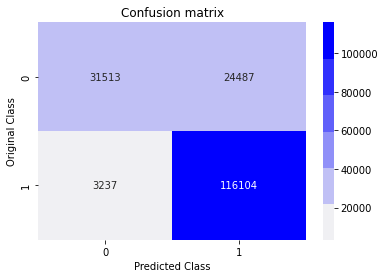

In [238]:
plot_cm(cm_svm)

AUC_SVM:  0.7678040935668139


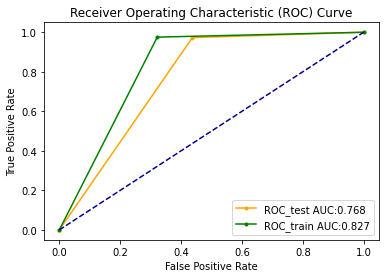

In [239]:
#finding the FPR and TPR for SVM set
fpr_te_svm, tpr_te_svm, t_te_svm = roc_curve(y_test, predict_y_te_svm)
fpr_tr_svm, tpr_tr_svm, t_tr_svm = roc_curve(y_train, predict_y_tr_svm)
auc_te_svm = auc(fpr_te_svm, tpr_te_svm)
print("AUC_SVM: ",auc_te_svm)
plot_roc_curve(fpr_tr_svm,tpr_tr_svm,fpr_te_svm, tpr_te_svm)

## 7.4 Random Forest Model

In [240]:
param_grid = {"n_estimators": [10,100,500,1000, 2000],
    "min_samples_split": [50, 80, 120, 200],
              "max_depth": [3, 5, 10, 50, 100]}
rfc = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1)
gridCV_rfc = GridSearchCV(rfc, param_grid, cv=3, verbose=10, n_jobs=-1)
gridCV_rfc.fit(df_train, y_train)
#grid Search cv results are stored in result for future use
results_rfc = pd.DataFrame.from_dict(gridCV_rfc.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 1/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 1/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 2/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 3/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......[CV 3/3; 4/100] START max_depth=3, min_samples_split=50, n_estimators=1000......
[CV 1/3; 4/100] START max_depth=3, min_samples_split=50, n_estimators=1000......

[CV 3/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 2/3; 1/100] START max_depth=3, min_samples_split=50, n_estimators=10........
[CV 3/3; 3/100] START max_depth=3, min_samples_split=50, n_estimators=500.......
[CV 1/3; 2/100] START max_depth=3, min_samples_split=50, n_estimators=100.......
[CV 2/3; 4/100] START max_depth=3, min_samples

In [241]:
results_rfc = results_rfc.sort_values(['rank_test_score'])
results_rfc.head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
81,12.574658,1.074379,1.212765,0.070896,100,50,100,"{'max_depth': 100, 'min_samples_split': 50, 'n...",0.926432,0.943448,0.898338,0.922740,0.018600,1
82,53.950475,4.258455,3.370093,0.531446,100,50,500,"{'max_depth': 100, 'min_samples_split': 50, 'n...",0.927416,0.942610,0.898047,0.922691,0.018497,2
62,52.645009,4.039032,3.175479,0.334645,50,50,500,"{'max_depth': 50, 'min_samples_split': 50, 'n_...",0.927379,0.942282,0.898083,0.922582,0.018360,3
61,12.766008,0.982197,1.239089,0.082341,50,50,100,"{'max_depth': 50, 'min_samples_split': 50, 'n_...",0.926432,0.943558,0.897318,0.922436,0.019088,4
64,200.155926,16.680666,13.344275,0.543478,50,50,2000,"{'max_depth': 50, 'min_samples_split': 50, 'n_...",0.927525,0.941663,0.897901,0.922363,0.018235,5


In [242]:
print(gridCV_rfc.best_params_)

{'max_depth': 100, 'min_samples_split': 50, 'n_estimators': 100}


In [243]:
rfc= RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=gridCV_rfc.best_params_['max_depth'],min_samples_split=gridCV_rfc.best_params_['min_samples_split'], n_estimators=gridCV_rfc.best_params_['n_estimators'])
rfc.fit(df_train,y_train)
sig_clf_rfc = CalibratedClassifierCV(rfc, method="sigmoid")
sig_clf_rfc.fit(df_train, y_train)
predict_y_tr_rfc = sig_clf_rfc.predict(df_train)
predict_y_te_rfc = sig_clf_rfc.predict(df_test)
rfc_f1 = f1_score(y_test, predict_y_te_rfc)
print(rfc_f1)

0.9515281718686665


In [244]:
cm_rfc = confusion_matrix(y_test, predict_y_te_rfc)

In [245]:
tn, fp, fn, tp = cm_rfc.ravel()

In [246]:
fpr_rfc = fp/(fp+tn)*100
fnr_rfc = fn/(fn+tp)*100
far_rfc = (fpr_rfc+fnr_rfc)/2
print("far:",far_rfc)

far: 9.743223110965337


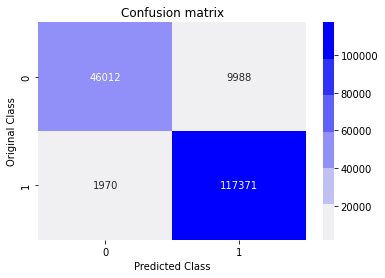

In [247]:
plot_cm(cm_rfc)

AUC_RFC:  0.9025677688903466


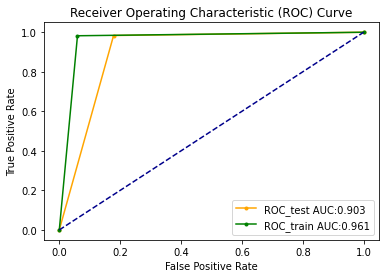

In [248]:
#finding the FPR and TPR for RFC set
fpr_te_rfc, tpr_te_rfc, t_te_rfc = roc_curve(y_test, predict_y_te_rfc)
fpr_tr_rfc, tpr_tr_rfc, t_tr_rfc = roc_curve(y_train, predict_y_tr_rfc)
auc_te_rfc = auc(fpr_te_rfc, tpr_te_rfc)
print("AUC_RFC: ",auc_te_rfc)
plot_roc_curve(fpr_tr_rfc,tpr_tr_rfc,fpr_te_rfc, tpr_te_rfc)

## 7.5 Stacking classifier

In [249]:
clf1 = SGDClassifier(alpha=0.0001,eta0=0.01, penalty='l2', loss='log', n_jobs = -1, max_iter=50)
clf1.fit(df_train, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1e-05,eta0=1e-05, penalty='l2', loss='hinge', n_jobs = -1, max_iter=100)
clf2.fit(df_train, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=-1, max_depth=100,min_samples_split=50, n_estimators=1000)
clf3.fit(df_train, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

In [ ]:
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
    sclf.fit(df_train, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log loss: %0.3f F1-score: %0.3f" % (i, log_loss(y_test, sclf.predict_proba(df_test)),f1_score(y_test, sclf.predict(df_test))))

In [ ]:
lr = LogisticRegression(C=10)
sig_clf_sc = StackingClassifier(estimators=[("lr",sig_clf1), ("svm", sig_clf2),("RF", sig_clf3)], final_estimator=lr, n_jobs=-1)
sig_clf_sc.fit(df_train, y_train)
predict_y_tr_sc= sig_clf_sc.predict(df_train)
predict_y_te_sc = sig_clf_sc.predict(df_test)
sc_f1 = f1_score(y_test, predict_y_te_sc)
print(sc_f1)

In [ ]:
cm_sc = confusion_matrix(y_test, predict_y_te_sc)

In [ ]:
tn, fp, fn, tp = cm_sc.ravel()

In [ ]:
fpr_sc = fp/(fp+tn)*100
fnr_sc = fn/(fn+tp)*100
far_sc = (fpr_sc+fnr_sc)/2
print("far:",far_sc)

far: 12.412772418651475


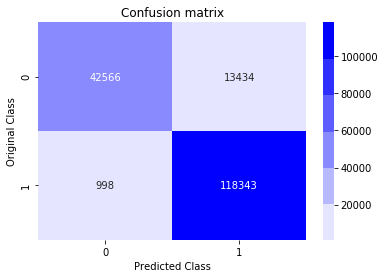

In [ ]:
plot_cm(cm_sc)

AUC_SC:  0.8758722758134853


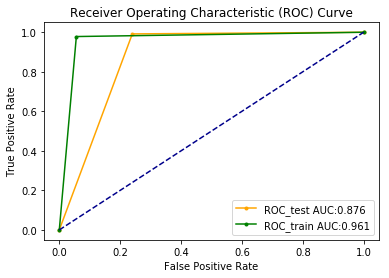

In [ ]:
#finding the FPR and TPR for RFC set
fpr_te_sc, tpr_te_sc, t_te_sc = roc_curve(y_test, predict_y_te_sc)
fpr_tr_sc, tpr_tr_sc, t_tr_sc = roc_curve(y_train, predict_y_tr_sc)
auc_te_sc = auc(fpr_te_sc, tpr_te_sc)
print("AUC_SC: ",auc_te_sc)
plot_roc_curve(fpr_tr_sc,tpr_tr_sc,fpr_te_sc, tpr_te_sc)

# 7.6. Model Evaluation

In [ ]:
x = PrettyTable()
x.field_names = ["Model", "F1 Score", "AUC","FPR %","FNR %","FAR %"]
x.add_row(["Logistic Regression", "{0:.4}".format(lr_f1), "{0:.4}".format(auc_te_lr),"%.2f" % float(fpr_lr),"%.2f" % float(fnr_lr),"%.2f" % float(far_lr)])
x.add_row(["Linear SVM", "{0:.4}".format(svm_f1), "{0:.4}".format(auc_te_svm),"%.2f" % float(fpr_svm),"%.2f" % float(fnr_svm),"%.2f" % float(far_svm)])
x.add_row(["Random Forest", "{0:.4}".format(rfc_f1), "{0:.4}".format(auc_te_rfc),"%.2f" % float(fpr_rfc),"%.2f" % float(fnr_rfc),"%.2f" % float(far_rfc)])
x.add_row(["Stacking Classifier", "{0:.4}".format(sc_f1), "{0:.4}".format(auc_te_sc),"%.2f" % float(fpr_sc),"%.2f" % float(fnr_sc),"%.2f" % float(far_sc)])
print(x)

+---------------------+----------+--------+-------+-------+-------+
|        Model        | F1 Score |  AUC   | FPR % | FNR % | FAR % |
+---------------------+----------+--------+-------+-------+-------+
| Logistic Regression |  0.9307  | 0.8447 |  30.6 |  0.47 | 15.53 |
|      Linear SVM     |  0.8934  | 0.7701 | 43.03 |  2.96 | 22.99 |
|    Random Forest    |  0.9524  | 0.9021 | 18.29 |  1.29 |  9.79 |
| Stacking Classifier |  0.9425  | 0.8759 | 23.99 |  0.84 | 12.41 |
+---------------------+----------+--------+-------+-------+-------+
